# Introduction

With the recent publication of bat speed into Baseball Savant's database, MLB teams have been provided with another metric to leverage in player evaluation & analysis (if they haven't been tracking this metric already, that is). The new metric opens up yet another avenue to explore, providing us insight into how **bat speed may influence a player's success at the plate**. Several different questions can be brought up, including: what bat speed is considered 'above-average'? Does a higher bat speed actually implicate better performance? Are there certain bat speeds which perform better against certain pitches? If bat speed declines as a player grows in age, at what rate does bat speed drop? 

In the following analysis, I will answer all of the questions above while also exploring the player evaluation & development implications of this metric. Specifically, I hope to accomplish the following:
1. Explore & establish the **association between bat speed and batting performance**
2. Create **hitting classifications** based on an individual player's bat speed, identifying them by their perceived batting approach
3. Analyze these new classifications and discuss their **implications on team performance and roster construction**
4. Create a **predictive model** which helps us **identify players who could significantly improve with modifications to their bat speed**, simultaneously identifying other players that are likely to regress from expected decreases in bat speed.
5. Acknowledge the defencies & flaws of my analysis

By answering such questions, I hope to provide another insight for MLB teams & research analysts to add to their player evaluation processes.

This notebook contains all of my code & the data visualizations which I used for my presentation. To limit the size of the notebook, I had to condense some of my thoughts and analysis within the markdown. For my complete analysis & summary, please see my presentation: https://www.canva.com/design/DAGOT5eoigA/cOZjWLsLBVtNujAeWy5goA/edit?utm_content=DAGOT5eoigA&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton


**DATA SOURCES:** Baseball Savant, FanGraphs

**PHOTO CREDITS:** MLB.com, ESPN (For the player headshots)


In [225]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy import stats


# Ignore warnings for all of the future plots
import warnings
warnings.filterwarnings('ignore')

## Importing Player Information & Statistics

To conduct my analysis, I'll start by using the 'Stats as of Aug 16th.csv' dataset. The dataset consists of a player's hitting metrics thus far (as of August 16th), including their average bat speed, wOBA, HardHit%, and other hitting metrics (extracted using Baseball Savant's 'custom leaderboard' function). I set a minimum at 250 PA, being close to the cut-off for being 'qualified' at this point on the season (the cut-off point is approximately 380 PAs at 122 games played. Thus, 250 PAs would allow us to analyze players who've established themselves in the league, but may not have been 'qualified' just yet). As such, the dataset includes **265 different hitters**.

In [226]:
# Load in grouped dataset
grouped = pd.read_csv('../data/Grouped Data 0816.csv')
grouped.head()

last_name, first_name  player_id  year   pa  home_run  k_percent  \
0     Blackmon, Charlie     453568  2024  372         8       16.9   
1     McCutchen, Andrew     457705  2024  437        16       26.1   
2        Turner, Justin     457759  2024  395         7       18.5   
3       Santana, Carlos     467793  2024  446        17       17.3   
4           Pham, Tommy     502054  2024  350         7       20.6   

   bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
0         8.3        0.402            0.328             0.730  ...   
1        11.7        0.405            0.336             0.741  ...   
2        10.6        0.365            0.347             0.712  ...   
3        10.3        0.429            0.330             0.759  ...   
4         8.6        0.396            0.331             0.727  ...   

   avg_best_speed  avg_hyper_speed  whiff_percent  swing_percent  \
0       95.528256        91.861783           18.7           48.6   
1       99.744797        94.015093           29.1           41.8   
2       96.514351        92.314967           17.1           45.2   
3       99.299451        93.901409           23.5           42.9   
4      100.606692        94.632794           22.0           40.7   

   pull_percent  straightaway_percent  opposite_percent  groundballs_percent  \
0          44.0                  35.2              20.9                 38.8   
1          38.1                  41.9              20.0                 41.9   
2          40.4                  34.8              24.8                 34.8   
3          48.9                  32.8              18.3                 37.9   
4          35.4                  37.0              27.6                 43.1   

   flyballs_percent  linedrives_percent  
0              25.3                23.8  
1              27.2                21.9  
2              29.3                28.5  
3              29.3                22.7  
4              20.7                30.5  

[5 rows x 32 columns]

I'll also add the players ages to this dataset. As such, I'll import a dataset containing their ages & merge this to the 'grouped' dataset.

In [227]:
# Load in Age data
Age = pd.read_csv('../data/Age Data.csv')

# Add 'Age' column to 'grouped' dataset
grouped = grouped.merge(Age[['player_id', 'player_age']], on='player_id', how='left')

In [228]:
# Check info of dataset
grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 33 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   last_name, first_name  265 non-null    object 
 1   player_id              265 non-null    int64  
 2   year                   265 non-null    int64  
 3   pa                     265 non-null    int64  
 4   home_run               265 non-null    int64  
 5   k_percent              265 non-null    float64
 6   bb_percent             265 non-null    float64
 7   slg_percent            265 non-null    float64
 8   on_base_percent        265 non-null    float64
 9   on_base_plus_slg       265 non-null    float64
 10  isolated_power         265 non-null    float64
 11  babip                  265 non-null    float64
 12  xba                    265 non-null    float64
 13  xslg                   265 non-null    float64
 14  xwoba                  265 non-null    float64
 15  xiso  

## Importing Pitch-level Data

I'll also be working with the pitch-level data for this analysis (extracted using Baseball Savant's 'search' function). It contains all of 'competitive swings' on pitches recorded until Aug 16th, effectively containing every swing (that's not a bunt) from a player within this season. I'll also use this pitch level dataset to extract the assigned batting stance of the player (via the 'stand' variable). 

**Important Notes:** 
* **Swing data is only up to April 3rd**. This is when Statcast first began recording this new data
* Due to the limit on Statcast's search functionality, I could only download all of the data in intervals (e.g., games from March to April 8th, April 9th to April 22nd, etc.). As such, I'll need to merge all of these datasets to complete the data.
* Due to Statcast's functionality in their search option and 'customer leaderboards' feature, there was a discrepancy in the number of players provided when performing the search. Thus, I performed a search for all of the pitches recorded within the 2024 season (on attempted swings). As the 'custom leaderboards' option is more reliable in this case, I'll create a new dataframe which filters out any players which aren't listed in our original dataset (the min. 250 PA dataset, titled 'grouped' within the analysis). Effectively, I will have all of the pitch data for the names listed in our original dataset

In [229]:
# Load in all of the pitch data
apr3 = pd.read_csv('../data/April 3rd.csv')
apr9 = pd.read_csv('../data/April 9th.csv')
apr24 = pd.read_csv('../data/April 24th.csv')
may9 = pd.read_csv('../data/May 9th.csv')
may23 = pd.read_csv('../data/May 23rd.csv')
jun7 = pd.read_csv('../data/June 7th.csv')
jun21 = pd.read_csv('../data/June 21st.csv')
jul5 = pd.read_csv('../data/July 5th.csv')
jul19 = pd.read_csv('../data/July 19th.csv')
aug2 = pd.read_csv('../data/August 2nd.csv')

# Combine all of the data sets
df = pd.concat([apr3, apr9, apr24, may9, may23, jun7, jun21, jul5, jul19, aug2], ignore_index=True)
df.head()


pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
0         FF  2024-04-08           93.4          -2.77           5.78   
1         KC  2024-04-08           80.1          -3.02           5.70   
2         CU  2024-04-08           82.3          -2.28           5.61   
3         CU  2024-04-08           82.8          -2.28           5.63   
4         CU  2024-04-08           82.5          -2.29           5.63   

    player_name  batter  pitcher     events    description  ...  \
0  Bryant, Kris  592178   668678  field_out  hit_into_play  ...   
1  Bryant, Kris  592178   668678        NaN           foul  ...   
2   Stewart, DJ  621466   450203        NaN           foul  ...   
3   Stewart, DJ  621466   450203        NaN           foul  ...   
4   Stewart, DJ  621466   450203        NaN           foul  ...   

   post_home_score  post_bat_score  post_fld_score  if_fielding_alignment  \
0                3               3               4               Standard   
1                3               3               4               Standard   
2                4               4               4          Infield shade   
3                4               4               4          Infield shade   
4                4               4               4          Infield shade   

   of_fielding_alignment spin_axis delta_home_win_exp delta_run_exp bat_speed  \
0               Standard     208.0             -0.066        -0.458  73.65551   
1               Standard      41.0              0.000        -0.168  72.57554   
2               Standard      59.0              0.000         0.000  66.75303   
3               Standard      61.0              0.000         0.000  67.04687   
4               Standard      59.0              0.000         0.000  79.45243   

  swing_length  
0      7.48645  
1      8.30704  
2      8.07263  
3      8.12449  
4      7.70645  

[5 rows x 94 columns]

As per my note, let's filter for just the players in my original dataset (titled 'grouped'). Effectively, we will have all the swings from players with that satisfy my min. 250 PA rule.

In [230]:
# Filter the 'pitch' dataset to include only rows with IDs present in the 'grouped' dataset
pitch = df[df['batter'].isin(grouped['player_id'])]

pitch.head()

# Check that the dataframe has 265 unique batter IDs
print(len(pitch['batter'].unique()))

265


In [231]:
pitch.info

<bound method DataFrame.info of        pitch_type   game_date  release_speed  release_pos_x  release_pos_z  \
6              KC  2024-04-08           79.9          -3.04           5.66   
7              FF  2024-04-08           91.9          -2.83           5.84   
8              SL  2024-04-08           84.5          -1.96           4.96   
10             FF  2024-04-08           94.1          -1.71           5.14   
11             FF  2024-04-08           91.5          -2.77           5.82   
...           ...         ...            ...            ...            ...   
211416         FF  2024-08-02           89.3          -1.78           6.08   
211417         FF  2024-08-02           92.9          -1.34           5.37   
211418         FF  2024-08-02           93.1          -2.54           6.28   
211419         FF  2024-08-02           95.9          -2.02           5.87   
211420         FF  2024-08-02           96.7           2.51           5.55   

             player_name  batte

### *Adding the batter's stance into the 'grouped' dataset*


Before proceeding into our analysis, I'll quickly add the 'stand' variable (player's stance at the plate, LH or RH). This will be a vital part later on in our analysis.

In [232]:
# Group by 'batter' and calculate the most common 'stand' value
stand_counts = pitch.groupby(['batter', 'stand']).size().unstack(fill_value=0)

# Check player is a switch hitter
stand_mode = stand_counts.apply(lambda x: 'S' if x['L'] > 0 and x['R'] > 0 else x.idxmax(), axis=1)

# Add this as a new column 'side' in the pitch dataset
pitch['side'] = pitch['batter'].map(stand_mode)

In [233]:
pitch['side'].unique()

array(['R', 'L', 'S'], dtype=object)

In [234]:
# Add the batting side of the player into the 'grouped' dataset
grouped = grouped.merge(pitch[['batter', 'side']].drop_duplicates(), left_on='player_id', right_on='batter', how='left')

# Drop 'batter' from the grouped dataset
grouped.drop(columns=['batter'], inplace=True)

In [235]:
grouped.head()

last_name, first_name  player_id  year   pa  home_run  k_percent  \
0     Blackmon, Charlie     453568  2024  372         8       16.9   
1     McCutchen, Andrew     457705  2024  437        16       26.1   
2        Turner, Justin     457759  2024  395         7       18.5   
3       Santana, Carlos     467793  2024  446        17       17.3   
4           Pham, Tommy     502054  2024  350         7       20.6   

   bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
0         8.3        0.402            0.328             0.730  ...   
1        11.7        0.405            0.336             0.741  ...   
2        10.6        0.365            0.347             0.712  ...   
3        10.3        0.429            0.330             0.759  ...   
4         8.6        0.396            0.331             0.727  ...   

   whiff_percent  swing_percent  pull_percent  straightaway_percent  \
0           18.7           48.6          44.0                  35.2   
1           29.1           41.8          38.1                  41.9   
2           17.1           45.2          40.4                  34.8   
3           23.5           42.9          48.9                  32.8   
4           22.0           40.7          35.4                  37.0   

   opposite_percent  groundballs_percent  flyballs_percent  \
0              20.9                 38.8              25.3   
1              20.0                 41.9              27.2   
2              24.8                 34.8              29.3   
3              18.3                 37.9              29.3   
4              27.6                 43.1              20.7   

   linedrives_percent  player_age  side  
0                23.8          37     L  
1                21.9          37     R  
2                28.5          39     R  
3                22.7          38     S  
4                30.5          36     R  

[5 rows x 34 columns]

### *Adding wOBA to the 'grouped' dataset*

In [236]:
# Add dataset with 'wOBA' values
woba = pd.read_csv('../data/wOBA.csv')
woba

# Merging the 'woba' column from wOBA into grouped on the 'player_id' column
grouped = pd.merge(grouped, woba[['player_id', 'woba']], on='player_id', how='left')

# Dataset Exploration - Analyzing Bat Speed & Identifying Different Types of Batters (Creating Batter Classifications)

Before proceeding with our analysis, let's establish the baseline for our results. By answering some of these surface level questions, we can derive further insights as we investigate different aspects of the data

## *What is the average bat speed (mph) for hitters? Is there a discrepancy among left and right-handed batters?*

Let's begin by establishing our expectations regarding bat speed (i.e., what defines an 'above-average' bat speed?). We can do this by observing the mean bat speed and the distribution among players

In [237]:
# Calculate mean bat_speed
print(grouped['avg_swing_speed'].mean())

71.58830188679246


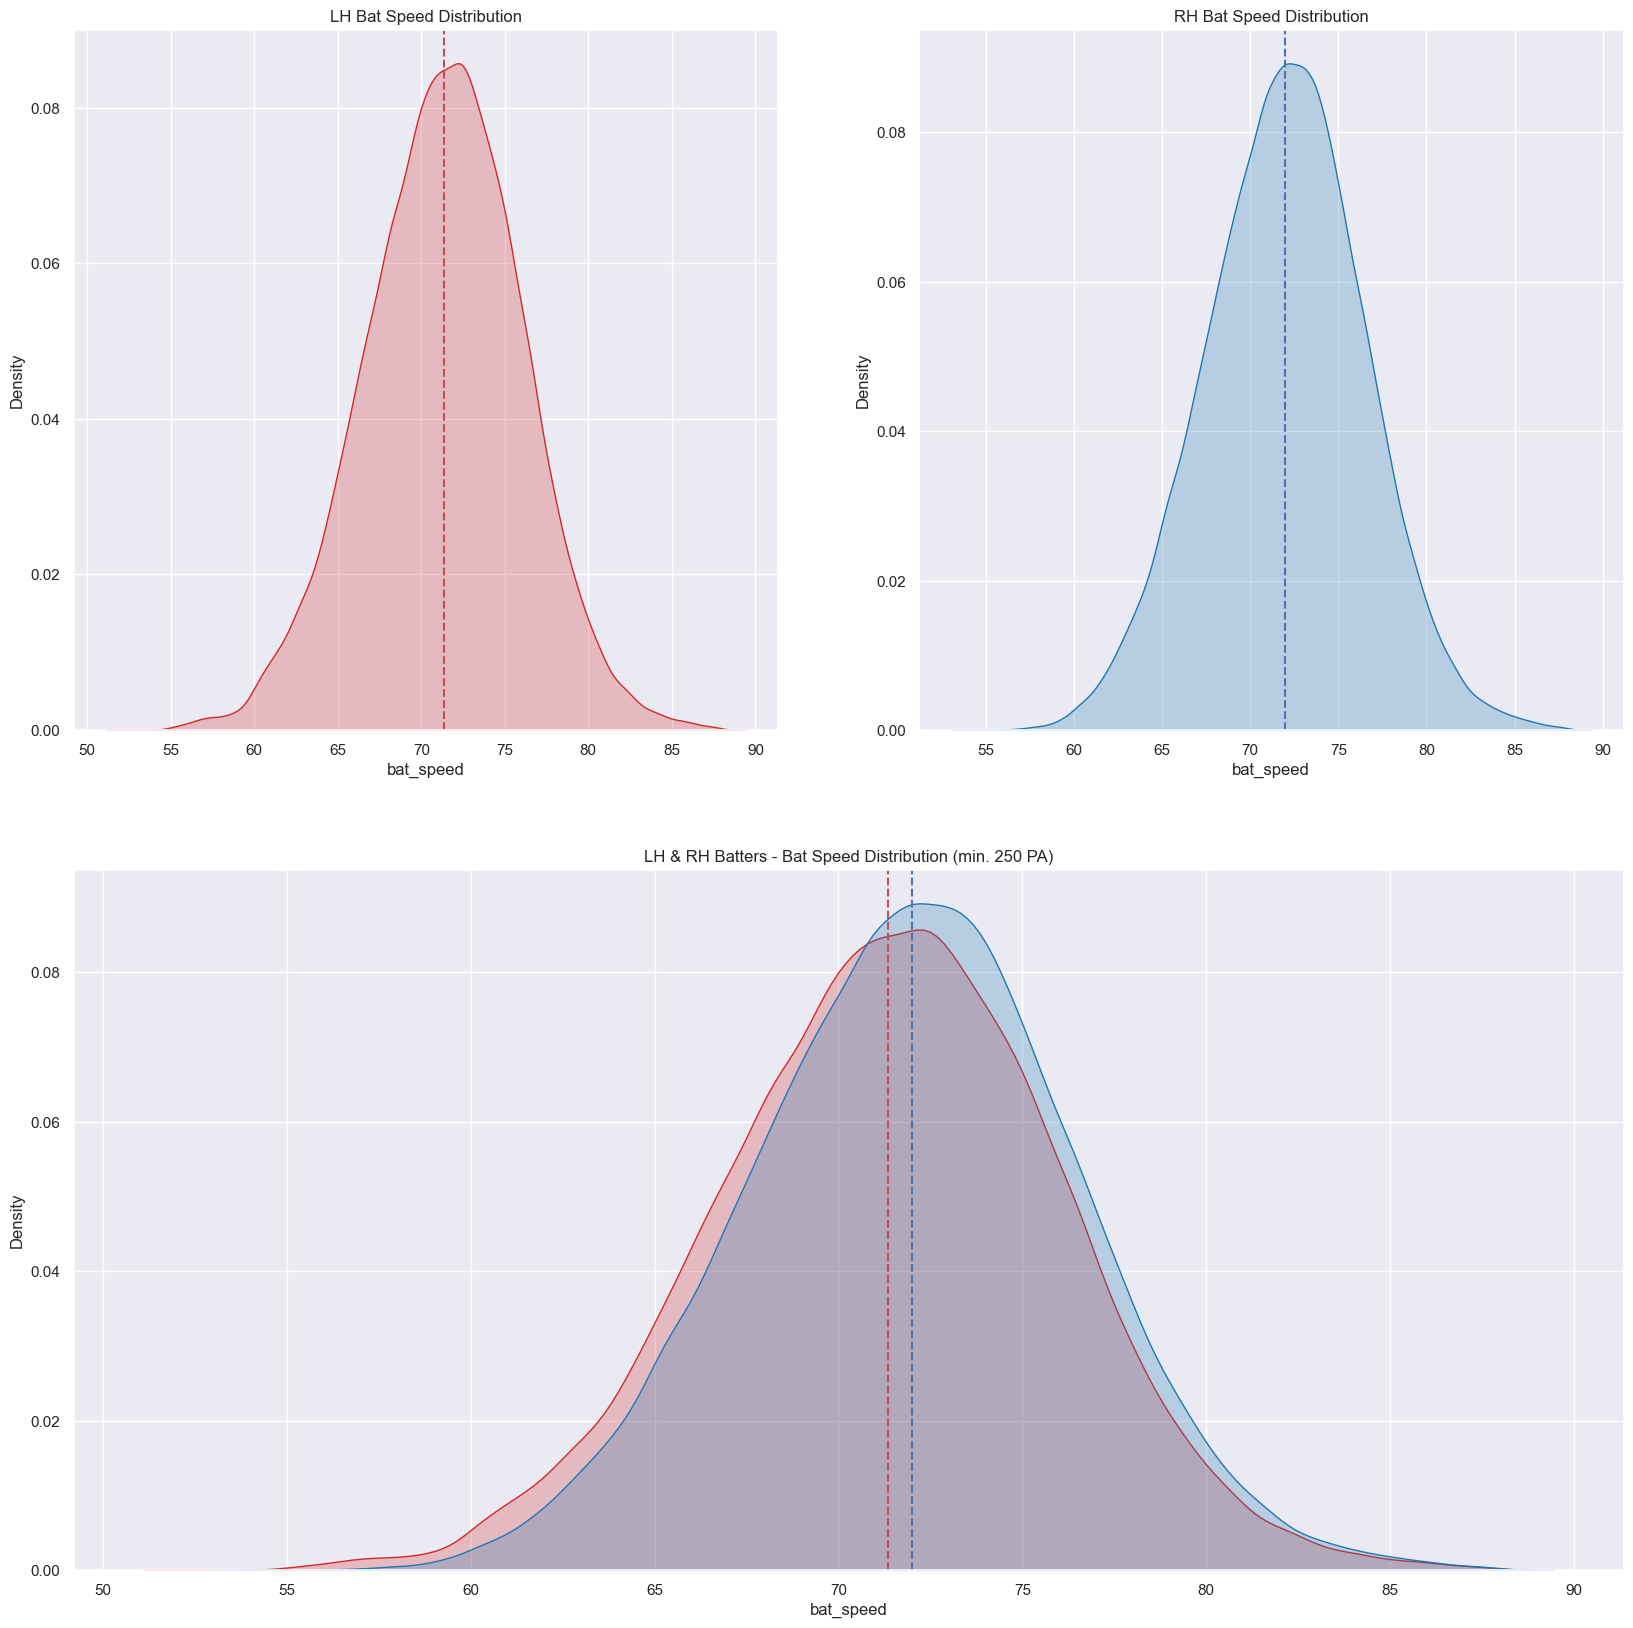

In [238]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (20, 20))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,2), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,1), loc=(1,0))


# INDIVIDUAL GRIDS 

# 'Lefty' Bat Speed Distribution Distribution
Left = pitch[pitch['stand'] == "L"]
sns.set(rc={'figure.figsize':(10,5)})
ax1 = sns.kdeplot(Left['bat_speed'], fill = True, ax=ax1, color = 'tab:red')
ax1.set_title('LH Bat Speed Distribution')
ax1.axvline(x=np.mean(Left['bat_speed']), color='r', linestyle='--')
# 'Righty' Bat Speed Distribution Distribution
Right = pitch[pitch['stand'] == "R"]
ax2 = sns.kdeplot(Right['bat_speed'], fill = True, ax=ax2, color = 'tab:blue')
ax2.set_title('RH Bat Speed Distribution')
ax2.axvline(x=np.mean(Right['bat_speed']), color='b', linestyle='--')


# All hit classes in One Graph (ax5)
sns.kdeplot(Left['bat_speed'], fill = True, ax=ax3, color = 'tab:red')
sns.kdeplot(Right['bat_speed'], fill = True, ax=ax3, color = 'tab:blue')
ax3.set_title('LH & RH Batters - Bat Speed Distribution (min. 250 PA)')
ax3.axvline(x=np.mean(Left['bat_speed']), color='r', linestyle='--')
ax3.axvline(x=np.mean(Right['bat_speed']), color='b', linestyle='--')

**INSIGHTS & IMPLICATION ON ANALYSIS:**

**There is minimal difference in average bat speed among right and left-handed batters (~0.05 mph difference).** Interestingly, right-handed batters slightly have the edge over left-handed batters in bat speed. This may be due to the higher bat speeds right-handed batters have at both the lower and higher ends of the distribution (e.g., ~60mph and ~85 mph), consistently being above left-handed batters. While this difference is quite minimal, it's something we can keep in mind as we analyze RH/LH splits further into this analysis. 

From an overall standpoint, bat speeds will range from 60 - 85 mph. **Most players will sit near the mid-low 70s (~72mph)**, which is in line with our calculated average (71.588 mph). It also aligns with the average Baseball Savant noted when it published swing data, being around 72mph. Understanding this information, we'll want to analyze how deviations from this ~72 mph will influence hitting performance (effectively using it as a benchmark).

## How does Age Influence a Player's Bat Speed? What are the distributions like for different age groups?

Presumtively, bat speed should decrease as a player's age increases. But at what rate? And is the drop-off as significant as we may perceive it to be?

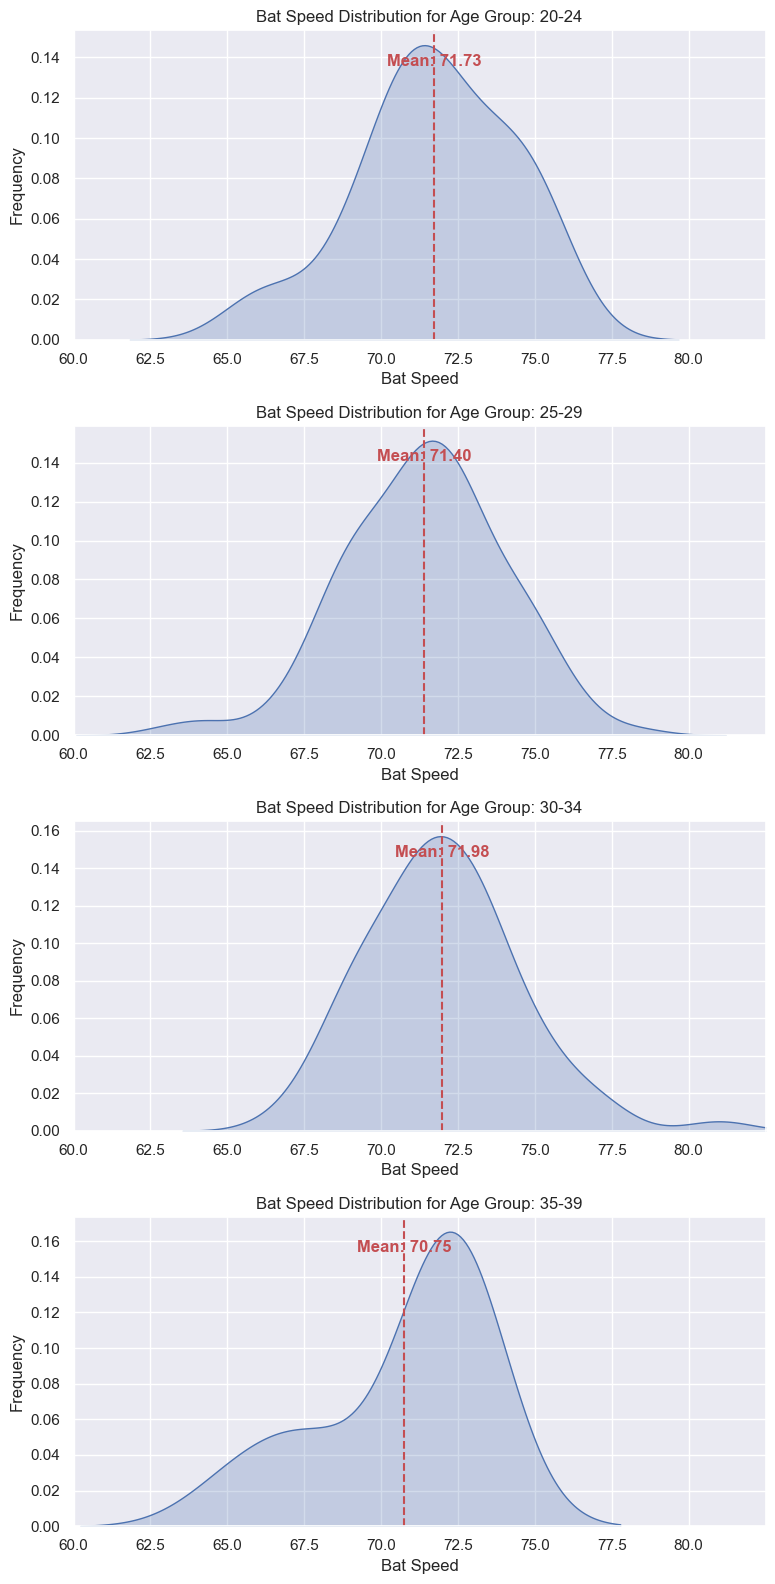

In [239]:
# Create Age Groups (easier for visualization purposes)
bins = [20, 25, 30, 35, 40] 
labels = ['20-24', '25-29', '30-34', '35-39']
grouped['AgeGroup'] = pd.cut(grouped['player_age'], bins=bins, labels=labels, right=False)

# Set up for the distribution plot
age_groups = grouped['AgeGroup'].unique()  # Get unique age groups
age_groups = age_groups.sort_values()  # Sort Age groups
num_groups = len(age_groups)

# Create frame for subplots
fig, axes = plt.subplots(nrows=num_groups, ncols=1, figsize=(8, num_groups * 4))

# Define the fixed x-axis limits and ticks
x_limits = (60, 82.5)
x_ticks = np.arange(60, 82.5, 2.5)

# Iterate over the age groups and create a plot for each
for i, age_group in enumerate(age_groups):
    ax = axes[i]
    sns.kdeplot(data=grouped[grouped['AgeGroup'] == age_group], fill=True, x='avg_swing_speed', ax=ax)
    ax.set_title(f'Bat Speed Distribution for Age Group: {age_group}')
    ax.set_xlabel('Bat Speed')
    ax.set_ylabel('Frequency')
    
    # Set the axis
    ax.set_xlim(x_limits)
    ax.set_xticks(x_ticks)
    
    # Average Line & Label for plots
    avg_speed = np.mean(grouped[grouped['AgeGroup']== age_group]['avg_swing_speed'])
    ax.axvline(x=avg_speed, color='r', linestyle='--')
    ax.text(avg_speed, ax.get_ylim()[1] * 0.9, f'Mean: {avg_speed:.2f}', color='r', ha='center', va='center', fontweight = 'bold')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

**INSIGHTS & IMPLICATIONS**

Based on the results from above, bat speed stays relatively stable as the player's age increases. The main drop-off occurs beyond age 35, with average bat speed dropping 1.2 mph. While this may seem insignificant, it can have a dramatic effect on a player's performance (as we'll establish in the next few sections). In comparison to the range of bat speeds throughout the league (20 mph), a 1.20 mph signifies a 6% drop relative to the rest of the field. 

Without historical data available to us, it makes it difficult to determine how year-over-year changes in bat speed could occur. Nonetheless, the differences in bat speed across each group implicate a drop-off somewhere at the **age 35** mark. 

To fully contextualize the effects of these types of bat speed increases/decreases, we'll need to observe how bat speed influences a player's performance.

## *How does bat speed influence a player's hitting performance? Do higher bat speeds always implicate better performance?*

Based on intuition, we assume that higher bat speeds implicate better-hitting performance (which is quite a reasonable assumption, one would expect a higher bat speed to consistently result in higher exit velocities & more favourable results). Now that we have this data available, let's confirm this assumption & attempt to quantify its strength with different hitting metrics.

The correlation between bat speed and hard hit percent is: 0.7678865956768574
The correlation between bat speed and xISO is: 0.6513287381145276
The correlation between bat speed and xBA is: 0.12595150839708044
The correlation between bat speed and xWOBA is: 0.47951772336195064
 


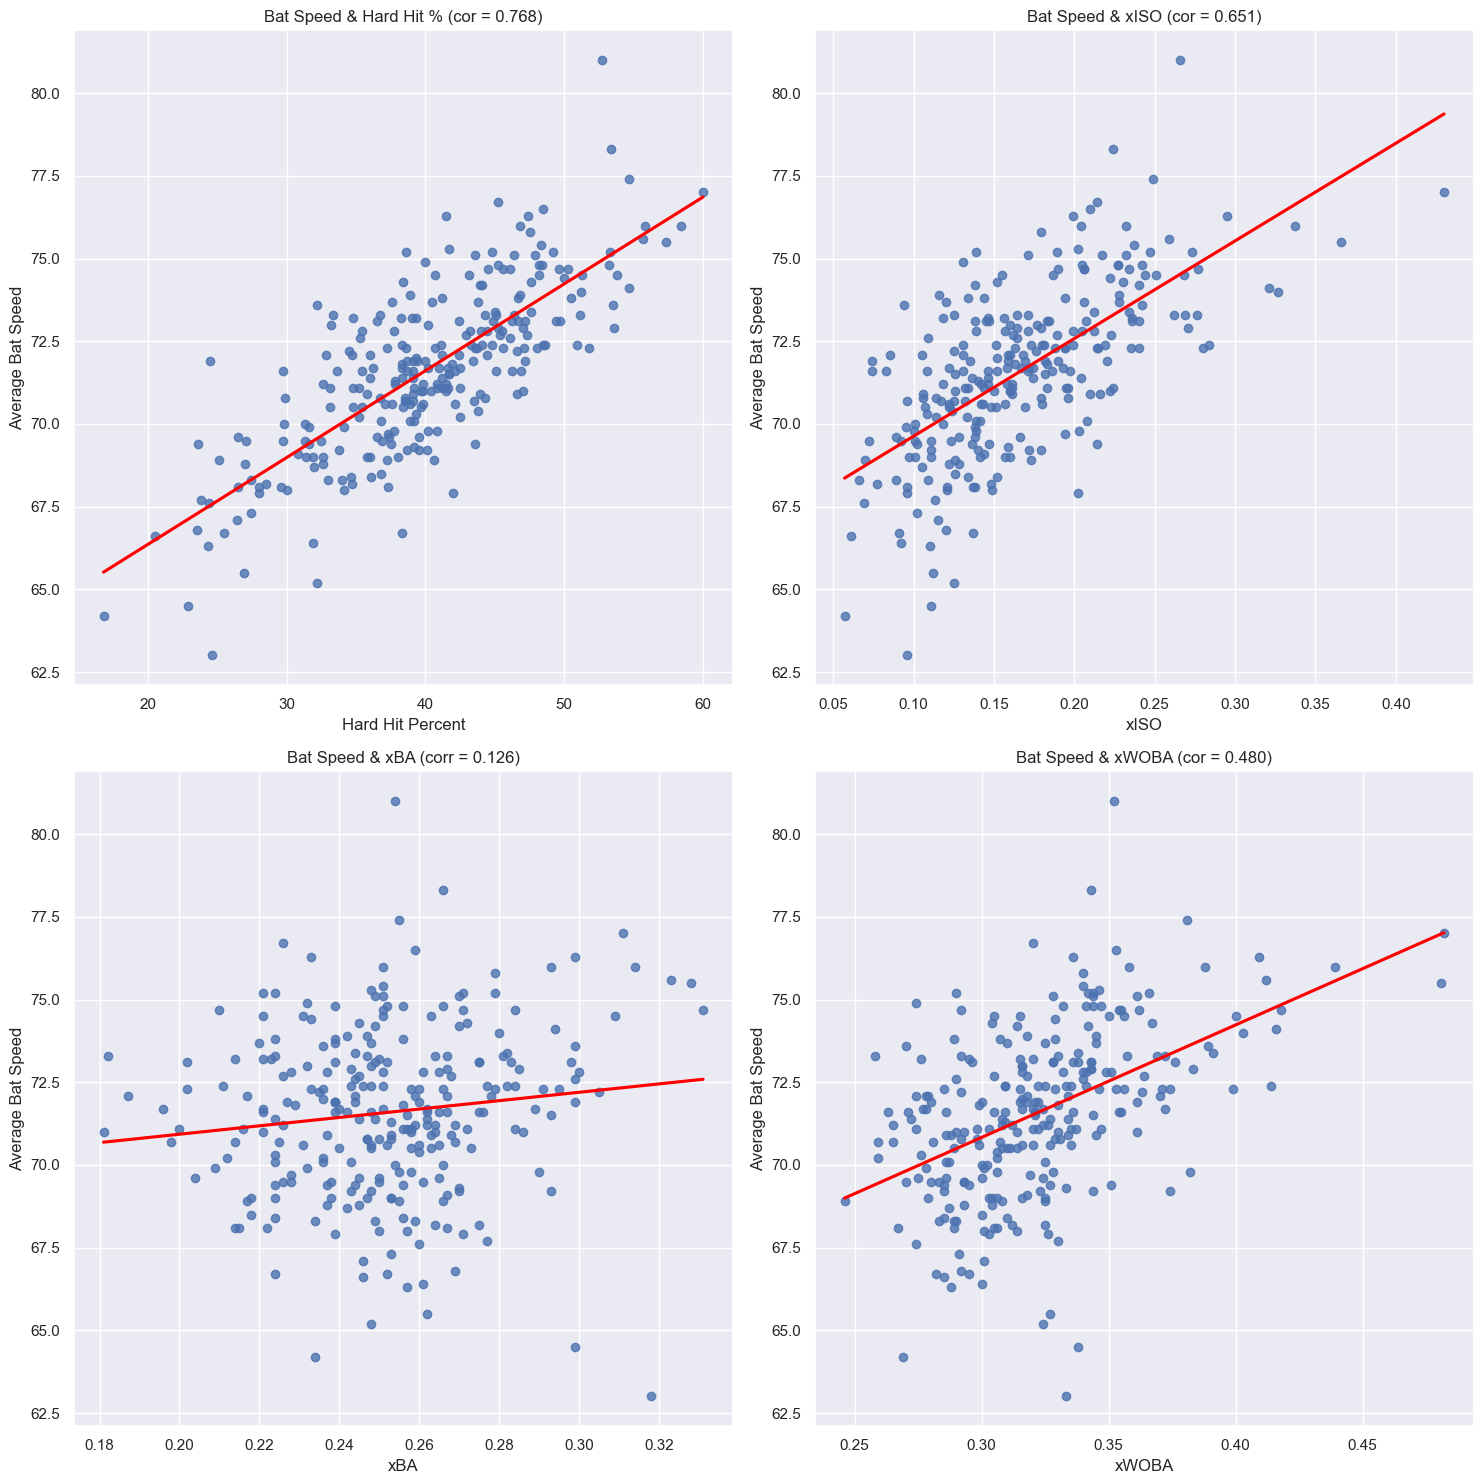

In [240]:
# Create the frame for subplots
fig, ax = plt.subplots(figsize=(15,15))


# Print the correlation between bat speed & each hitting metric
correlation1 = grouped['avg_swing_speed'].corr(grouped['hard_hit_percent'])
print(f"The correlation between bat speed and hard hit percent is: {correlation1}")
correlation2 = grouped['avg_swing_speed'].corr(grouped['xiso'])
print(f"The correlation between bat speed and xISO is: {correlation2}")
correlation3 = grouped['avg_swing_speed'].corr(grouped['xba'])
print(f"The correlation between bat speed and xBA is: {correlation3}")
correlation4 = grouped['avg_swing_speed'].corr(grouped['xwoba'])
print(f"The correlation between bat speed and xWOBA is: {correlation4}")

print(' ') # Add line for spacing

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(2,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,2), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,2), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,2), loc=(1,1))

# Bat Speed by Hard Hit Percent Scatter Plot
sns.regplot(x='hard_hit_percent', y='avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax1, data=grouped)
ax1.set_ylabel('Average Bat Speed')
ax1.set_xlabel('Hard Hit Percent')
ax1.set_title('Bat Speed & Hard Hit % (cor = 0.768)')

# Bat Speed by xISO Scatter Plot
sns.regplot(x='xiso', y='avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax2, data=grouped)
ax2.set_ylabel('Average Bat Speed')
ax2.set_xlabel('xISO')
ax2.set_title('Bat Speed & xISO (cor = 0.651)')

# Bat Speed by xBA Scatter Plot
sns.regplot(x='xba', y='avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax3, data=grouped)
ax3.set_ylabel('Average Bat Speed')
ax3.set_xlabel('xBA')
ax3.set_title('Bat Speed & xBA (corr = 0.126)')

# Bat Speed by xWOBA Scatter Plot
sns.regplot(x='xwoba', y='avg_swing_speed', ci=False, line_kws={'color':'red'}, ax=ax4, data=grouped)
ax4.set_ylabel('Average Bat Speed')
ax4.set_xlabel('xWOBA')
ax4.set_title('Bat Speed & xWOBA (cor = 0.480)')

plt.tight_layout()
plt.show()

**INSIGHTS & IMPLICATIONS ON ANALYSIS**
* As one would expect, **higher bat speeds have a strong and positive, linear association with hard hit percentage (0.768)**. Given the strength of this relationship, it is fair to conclude that a higher bat speed implicates a higher launch speed (on average)
* While not as strong as launch speed, there is a **somewhat strong and positive, linear association between bat speed and xISO (0.651)**. Recognizing this, it is fair to conclude that (on average) players with higher bat speeds will hit for more power, thus resulting in higher xISO values.
* Our main deviation is with the **xBA metric which bat speed has a weaker association to** (evidenced by the lack of concentration around the trend line and its less steep slope). This may be due to the varying batting approaches which hitters take, with some choosing to slow down their bat in an attempt to hit for higher averages (thus having a higher xBA despite a low avg. bat speed). In the next section, I will further analyze this idea and attempt to create classifications for these different batting approaches.
* There is a **moderately strong, positive linear assosciation between bat speed & xWOBA (0.480)**. As xwOBA is a bit of a combination of xBA and power output metrics, it makes sense for this correlation to fall in between all of our other metrics. 

 ## *What are the types of players at each level of bat speed? Using their xBA, can we categorize any of these players?*
 
Now that we've explored the relationship between bat speed and different hitting metrics, let's attempt to classify each hitter. Specifically, what types of hitters do we notice at varying levels of bat speed and how does their performance vary? To create these classificaitons, I'll rely on the xBA and bat speed plot. 

I chose to focus on the xBA and bat speed plot as xBA serves as a perfect indicator for a player's intention at the plate. It factors in the player's ability to hit to get on base, while also considering the bat speeds which they generate. Thus, it serves as a perfect metric to distinguish players who hit for higher batting averages vs. those who solely hit for power, especially when its plotted against bat speed data. 

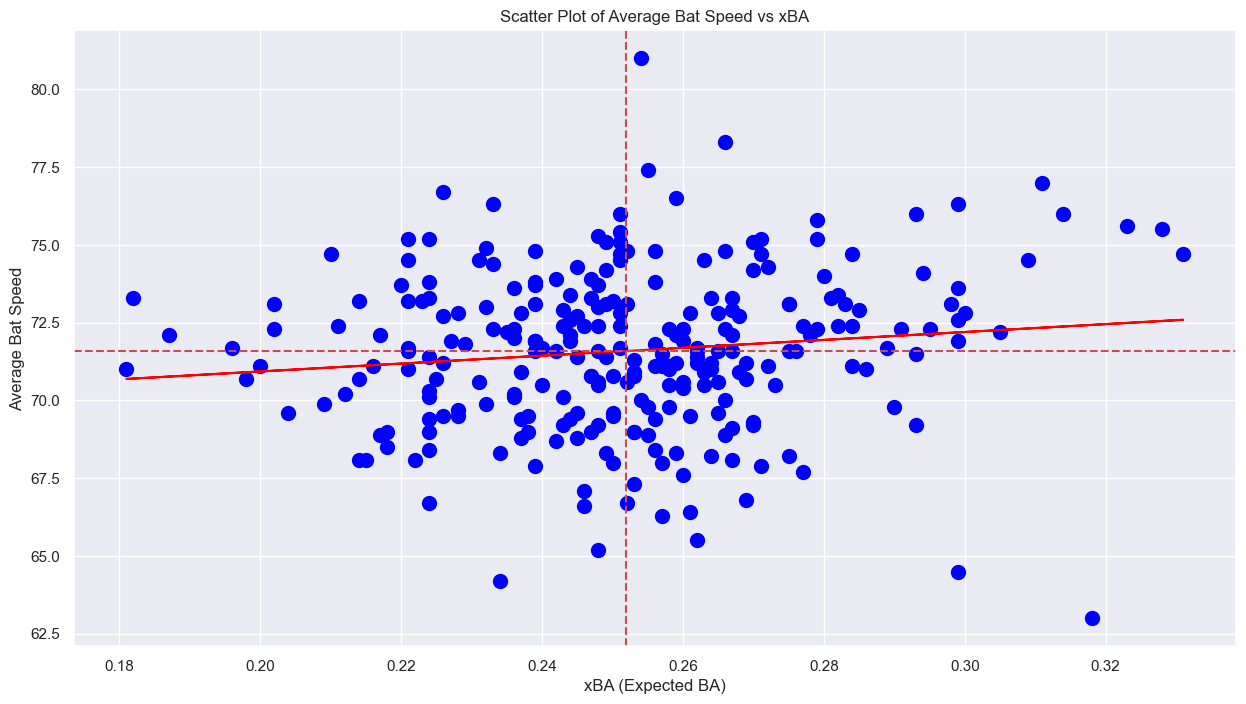

In [241]:
# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(grouped['xba'], grouped['avg_swing_speed'], color='blue', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA')
plt.grid(True)


# Plot a trend line
# Calculate the trend line (linear regression)
coefficients = np.polyfit(grouped['xba'], grouped['avg_swing_speed'], 1)  # Fit a 1st degree polynomial (linear)
polynomial = np.poly1d(coefficients)
trendline = polynomial(grouped['xba'])
# Plot the trend line
plt.plot(grouped['xba'], trendline, color='red', label='Trend line')

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')


plt.show()

Moving forward in our analysis, I'll need to identify different **segments/classifications** to further analyze the importance of bat speed. I will group players based on their bat speed and xBA, further analyzing how their approach has impacted other stats beyond xBA. I also hope to analyze how these groups are distributed among MLB rosters. *Do more successful offensive teams have more of a certain group? Or is a balance of the groups more effective?* Beyond roster-building implications, it may provide more perspective from a player development perspective. *Are certain players taking the wrong hitting approach in certain matchups? Are they a candidate to switch to another 'hitting type'?* In these cases, I'll leverage pitch-level data.

To identify different segments, I'll leverage the dotted average lines on the plot above. Specifically, we can note 4 quadrants of players, all of which have different batting approaches that yield different results:

**THE 4 CLASSIFICATIONS:**
1. **Elite Batters (Upper Right Quadrant)**. These are the players who swung an above-average bat speed and hit an above-average xBA. Given the favourable metrics, this group can be looked to as the 'ideal' candidates for player acquisition (at face value). The higher bat speeds not only implicated their ability to hit for higher averages, but it may also implicate an ability to generate better run values or greater on-base opportunities (think Shohei Ohtani, Aaron Judge)
2. **Power-Oriented Batters (Upper Left Quadrant)** These are players who swung an above-average bat speed, but fell below the average xBA. Most of these players will likely be pure-power hitters who are solely focused on XBH (think Jorge Soler, Giancarlo Stanton) or are players who simply struggle at the MLB level despite an above-average bat speed.
3. **.BA Oriented Batters (Lower Right Quadrant)**. These are the players who swung at below-average bat speeds, but hit above the average xBA. Players within this group are likely to be our batting average-oriented hitters, focused on getting on base to set up other hitters (think Luis Arraez, and Steven Kwan)
4. **Struggling Batters (Lower Left Quadrant)**. These are the players who swung below-average bat speeds, and hit below the average xBA. Players within this category likely aren't known for their hitting, lacking in both power and their ability to get on base. In most cases, these individuals will be more fielding-oriented players or hitters are struggling in 2024 (think Dominic Smith, Whit Merrifield, Kevin Kiermaier)

In [242]:
# Fucntion to create & Assign batter classes
def assign_batter_class(row):
    bat_speed = row['avg_swing_speed']
    xba = row['xba']
    
    # Mean bat_speed = 71.58830188679246 Mean xBA = 0.25192075471698117
    
    if bat_speed > 71.58830188679246 and xba > 0.25192075471698117:
        hit_class = "Elite"
    elif bat_speed > 71.58830188679246 and xba < 0.25192075471698117:
        hit_class = "Power Oriented"
    elif bat_speed < 71.58830188679246 and xba > 0.25192075471698117:
        hit_class = ".BA Oriented"
    elif bat_speed < 71.58830188679246 and xba < 0.25192075471698117:
        hit_class = "Struggling"
    else:
        "NA"
    return hit_class

# Apply function
grouped['hit_class'] = grouped.apply(assign_batter_class, axis = 1)


# Apply same classifications to pitch-level data
pitch = pitch.merge(grouped[['player_id', 'hit_class']], left_on='batter', right_on='player_id', how='left')

Let's apply these new classifications and see what they look like:

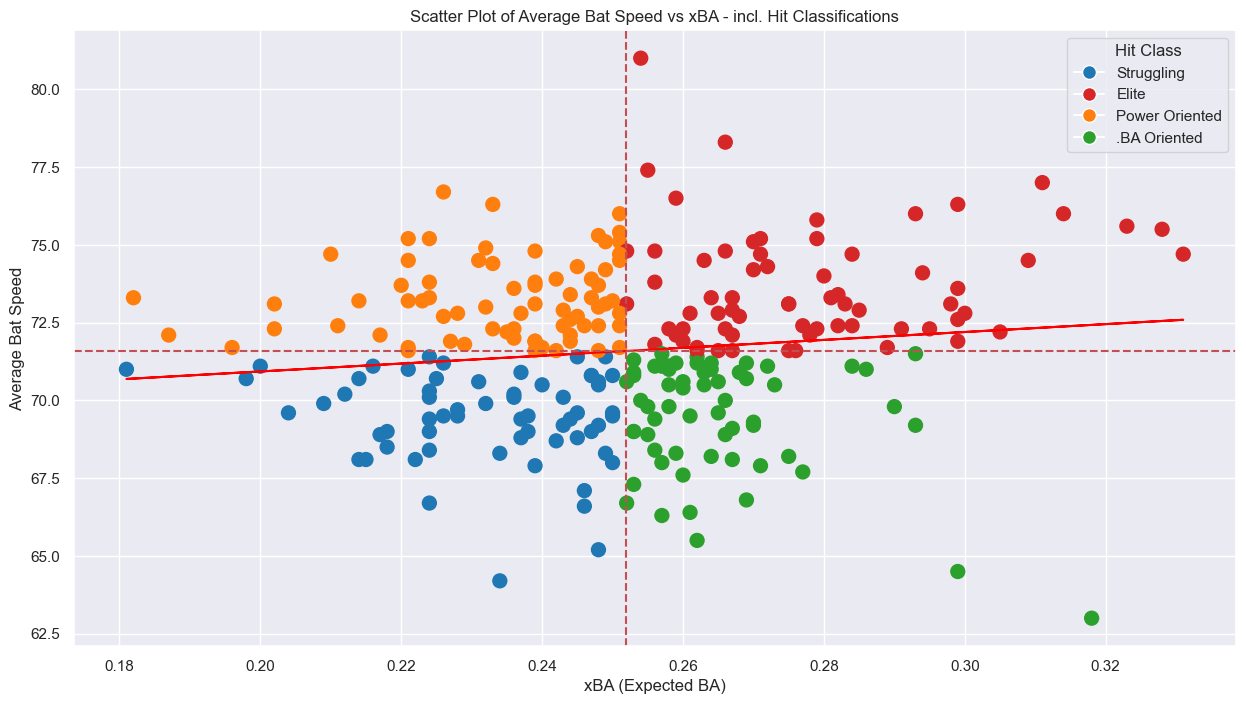

In [243]:
# New Scatter Plot with appropiate classification

# Define a color map for the 'hit_class' categories
color_map = {'Struggling':'tab:blue', 'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}
# Map the 'hit_class' values to colors
colors = grouped['hit_class'].map(color_map)

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(grouped['xba'], grouped['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - incl. Hit Classifications')
plt.grid(True)

# Plot a trend line
# Calculate the trend line (linear regression)
coefficients = np.polyfit(grouped['xba'], grouped['avg_swing_speed'], 1)  # Fit a 1st degree polynomial (linear)
polynomial = np.poly1d(coefficients)
trendline = polynomial(grouped['xba'])
# Plot the trend line
plt.plot(grouped['xba'], trendline, color='red', label='Trend line')

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--', label = '_nolegend_')


# Build the plot legend
forlegend = [plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=10, markerfacecolor=val)
           for key, val in color_map.items()]
plt.legend(title = 'Hit Class', handles = forlegend, loc = 'best')

plt.show()

Text(0, 0.5, ' ')

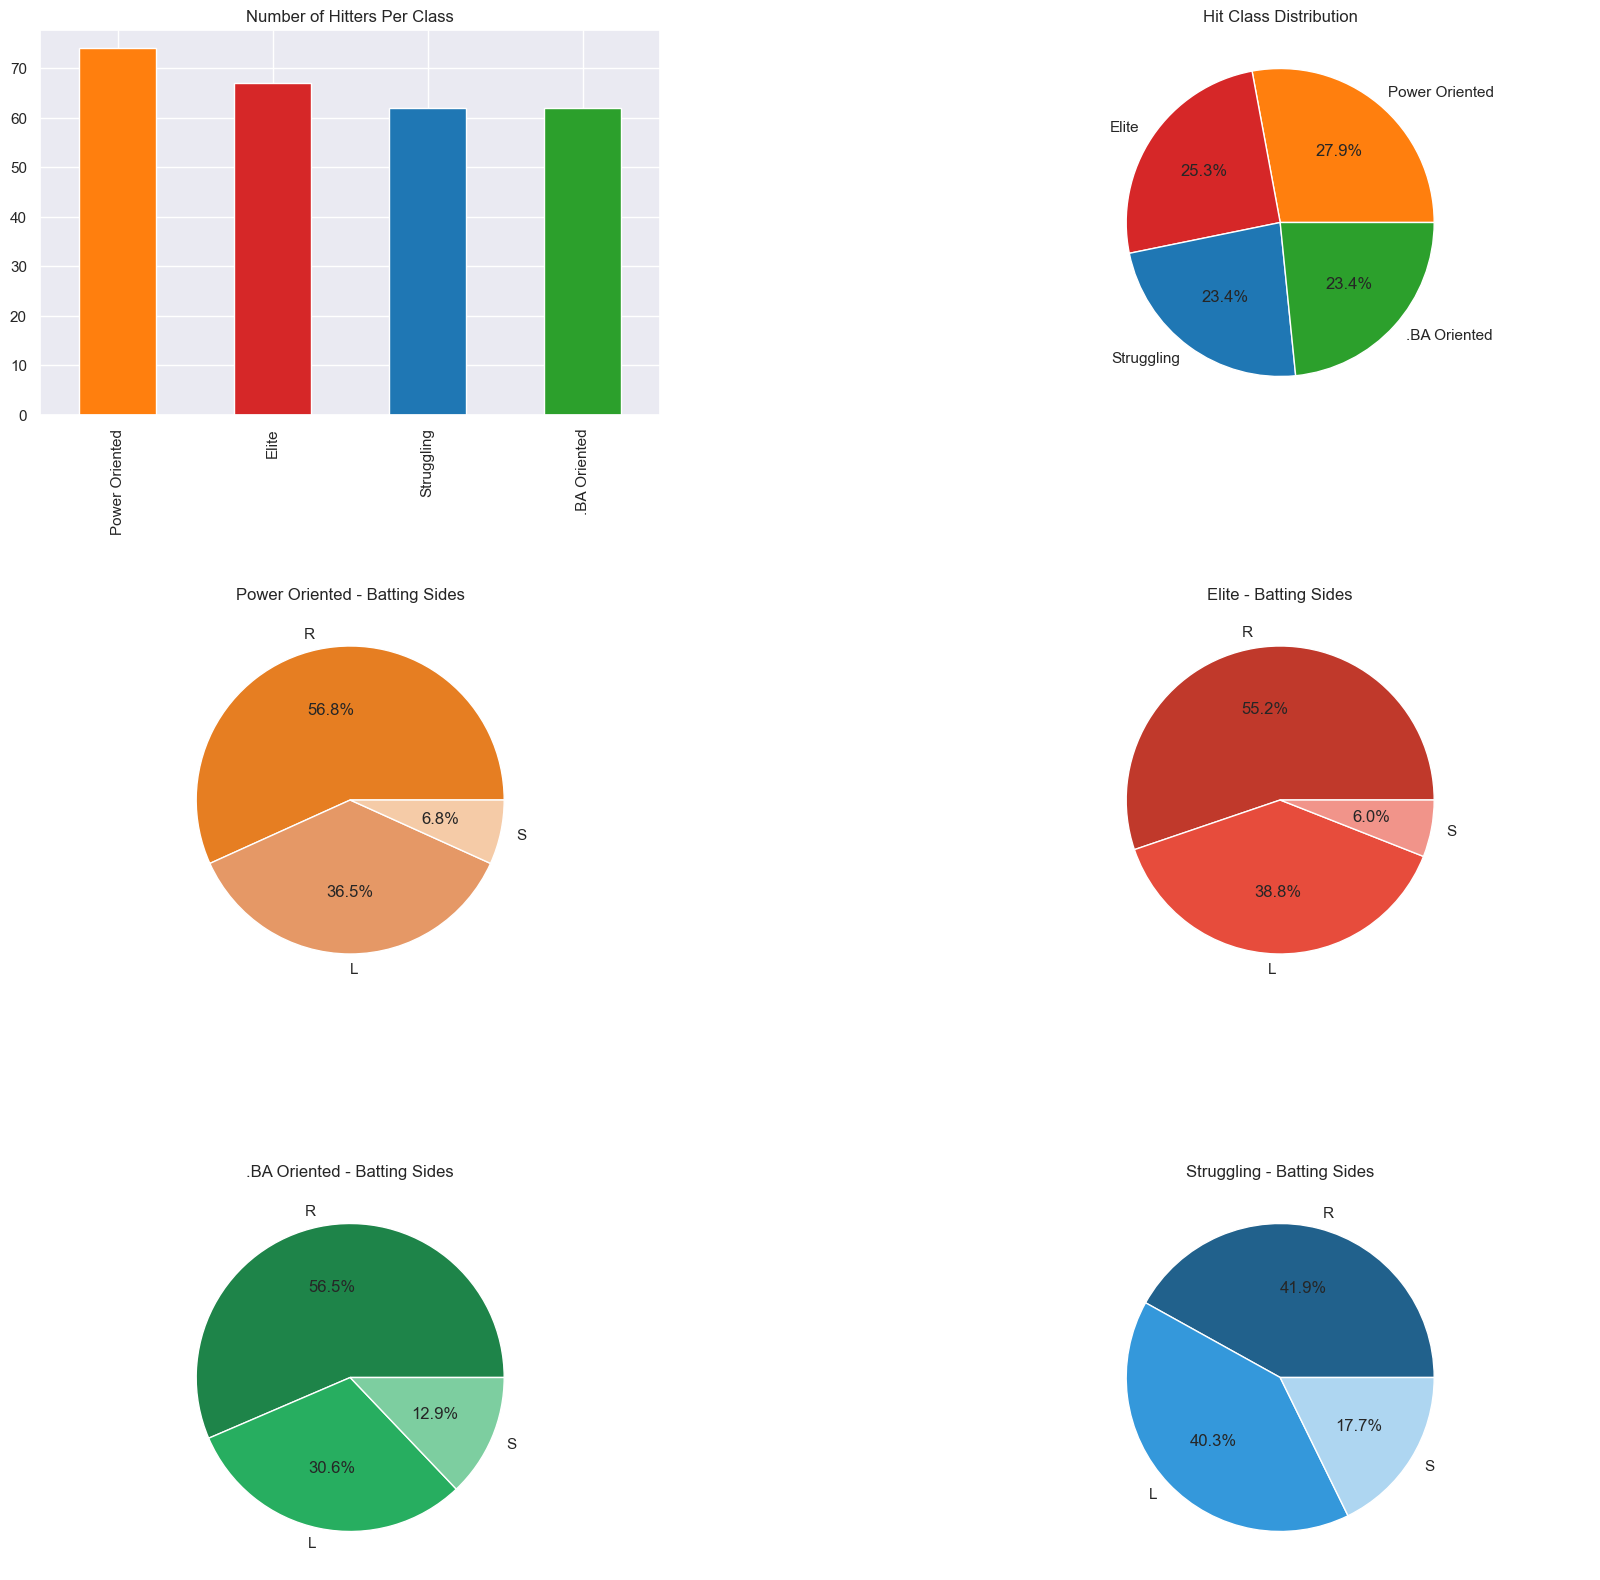

In [244]:
# Define a color map for the 'hit_class' categories
color_map = {'Struggling':'tab:blue', 'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}

# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize=(20, 20))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.5, hspace=0.5)

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(3, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(3, 2), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(3, 2), loc=(1, 0))
ax4 = plt.subplot2grid(shape=(3, 2), loc=(1, 1))
ax5 = plt.subplot2grid(shape=(3, 2), loc=(2, 0))
ax6 = plt.subplot2grid(shape=(3, 2), loc=(2, 1))

# Get the value counts for hit_class
hit_class_counts = grouped['hit_class'].value_counts()
# Plot distribution of Hit classes
ax1 = hit_class_counts.plot(kind='bar', figsize=(20, 20), ax=ax1, color=[color_map[hit_class] for hit_class in hit_class_counts.index], title='Number of Hitters Per Class')
ax1.set_xlabel(' ')
ax2 = hit_class_counts.plot(kind='pie', figsize=(20, 20), autopct='%1.1f%%', ax=ax2, colors=[color_map[hit_class] for hit_class in hit_class_counts.index], title='Hit Class Distribution')
ax2.set_ylabel('')

# Power Oriented subplot
PowerO = grouped[grouped['hit_class'] == "Power Oriented"]
PowerO_count = PowerO['side'].value_counts()
PowerOcolor = ['#e67e22','#e59866', '#f5cba7']
ax3 = PowerO_count.plot(kind='pie', figsize=(20, 20), autopct='%1.1f%%', ax=ax3, colors=PowerOcolor, title='Power Oriented - Batting Sides')
ax3.set_ylabel(' ')

# Elite subplot
Elite = grouped[grouped['hit_class'] == "Elite"]
Elite_count = Elite['side'].value_counts()
Elitecolor = ['#c0392b','#e74c3c', '#f1948a']
ax4 = Elite_count.plot(kind='pie', figsize=(20, 20), autopct='%1.1f%%', ax=ax4, colors=Elitecolor, title='Elite - Batting Sides')
ax4.set_ylabel(' ')

# .BA Oriented subplot
BAore = grouped[grouped['hit_class'] == ".BA Oriented"]
BA_count = BAore['side'].value_counts()
BAcolor = ['#1e8449','#27ae60', '#7dcea0']
ax5 = BA_count.plot(kind='pie', figsize=(20, 20), autopct='%1.1f%%', ax=ax5, colors=BAcolor, title='.BA Oriented - Batting Sides')
ax5.set_ylabel(' ')

# Struggling subplot
Strug = grouped[grouped['hit_class'] == "Struggling"]
Strugcount = Strug['side'].value_counts()
Strugcolor = ['#21618c','#3498db', '#aed6f1']
ax6 = Strugcount.plot(kind='pie', figsize=(20, 20), autopct='%1.1f%%', ax=ax6, colors=Strugcolor, title='Struggling - Batting Sides')
ax6.set_ylabel(' ')

**INSIGHTS & IMPLICATION ON ANALYSIS:**

Analyzing the subplots, it becomes clear how **balanced** the league is in terms of each hitting class. This demonstrates how mixed players are in their hitting philosophies and approach, with there not being a singular preferred approach. It may also demonstrate the **ranging skills** of players within the league, with average bat speeds being quite spread out across the league. Even despite this fact, there is a **still a slight preference for power-oriented hitting**, as demonstrated by the 27.9% share for 'Power Oriented' hitters. This should be of minimal surprise as the league has trended in this direction for quite some time. 

Nonetheless, these plots are only a surface-level view of these distributions. As I progress into my analysis, I'll delve further into how rosters/lineups are constructed around these different hitting classes.

There is a marginal difference in R/L/S hitter distribution among the classifications:
* ‘Elite’ and  ‘Power Oriented’ are righty dominant, comprising 55%+ of their distributions
* ‘.BA Oriented’ is also righty dominant, but there is double the share of switch hitters compared to the ‘Elite’ and ‘Power oriented’ groups
* ‘Struggling’ is just about evenly split between L/R. It also has a large % of switch hitters (~18% of the total distribution)

# Data Exploration - Analyzing The Hitting Classes And Their Features

To further analyze the hit classes I created, I focused on answering the following questions:

## *On average, what does the bat speed distribution for these groups look like? Are there groups which have larger / smaller distributions in bat speed?*

To begin, I wanted to investigate the speed distribution per hitting classification. This would allow us to see by how much each hitting classification may range in bat speed, providing for some interesting insights on how these groups vary in their range of avg. bat speed.

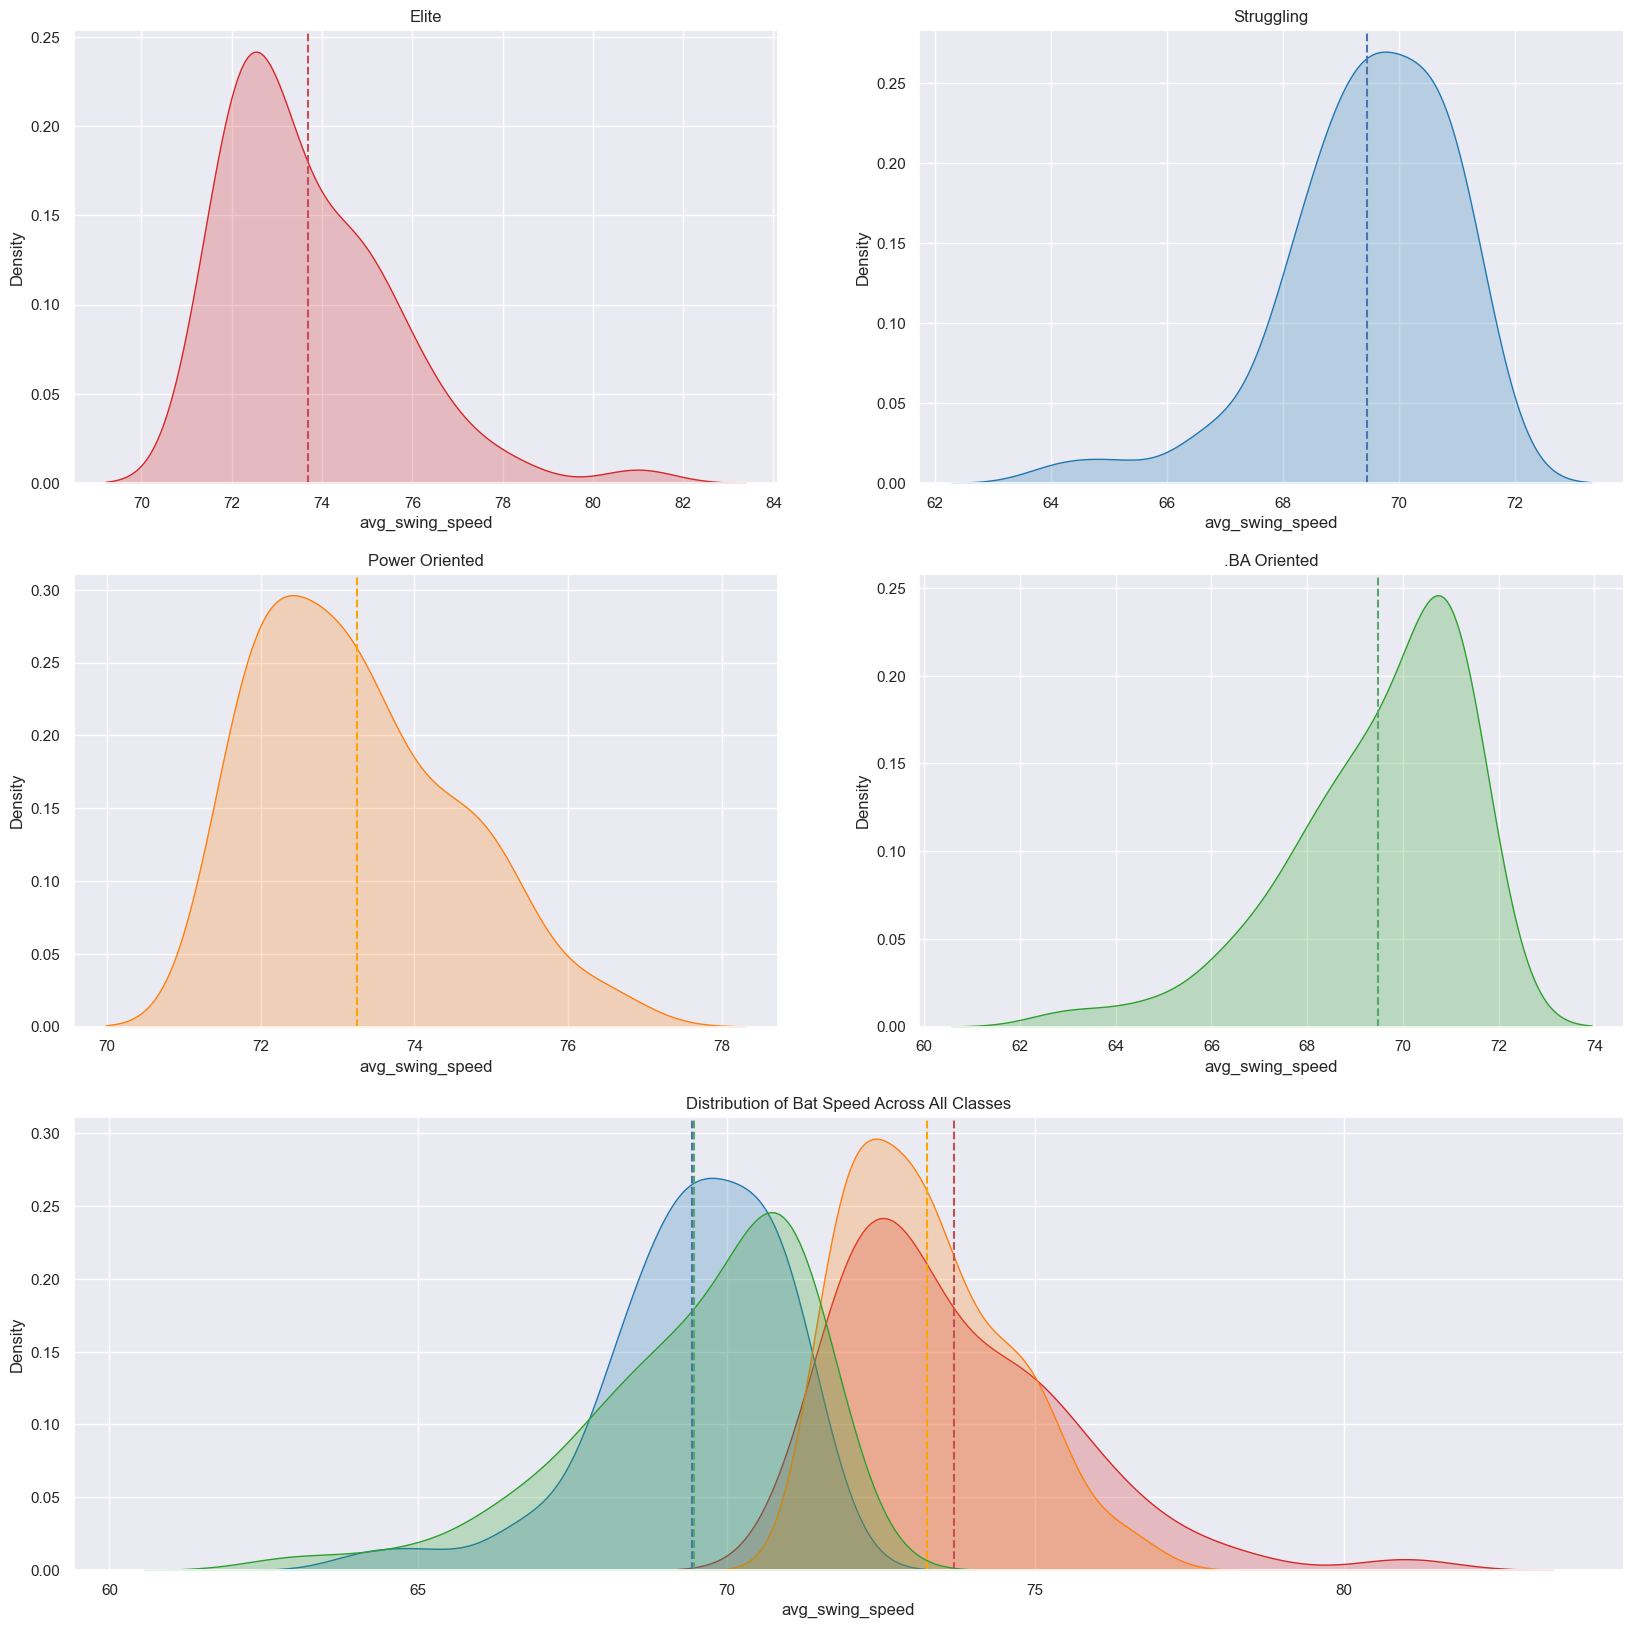

In [245]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (20, 20))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(3,2), loc=(0,0))
ax2 = plt.subplot2grid(shape=(3,2), loc=(0,1))
ax3 = plt.subplot2grid(shape=(3,2), loc=(1,0))
ax4 = plt.subplot2grid(shape=(3,2), loc=(1,1))
ax5 = plt.subplot2grid(shape=(3,1), loc=(2,0))


# INDIVIDUAL GRIDS (ax1 through ax4)

# 'Elite' Distribution
Elite = grouped[grouped['hit_class'] == "Elite"]
sns.set(rc={'figure.figsize':(10,5)})
ax1 = sns.kdeplot(Elite['avg_swing_speed'], fill = True, ax=ax1, color = 'tab:red')
ax1.set_title('Elite')
ax1.axvline(x=np.mean(Elite['avg_swing_speed']), color='r', linestyle='--')
# 'Struggling' Distribution
Struggling = grouped[grouped['hit_class'] == "Struggling"]
ax2 = sns.kdeplot(Struggling['avg_swing_speed'], fill = True, ax=ax2, color = 'tab:blue')
ax2.set_title('Struggling')
ax2.axvline(x=np.mean(Struggling['avg_swing_speed']), color='b', linestyle='--')
# 'Power Oriented' Distribution
PO = grouped[grouped['hit_class'] == "Power Oriented"]
ax3 = sns.kdeplot(PO['avg_swing_speed'], fill = True, ax=ax3, color = 'tab:orange')
ax3.set_title('Power Oriented')
ax3.axvline(x=np.mean(PO['avg_swing_speed']), color='orange', linestyle='--')
# '.BA Oriented' Distribution
BA = grouped[grouped['hit_class'] == ".BA Oriented"]
ax4 = sns.kdeplot(BA['avg_swing_speed'], fill = True, ax=ax4, color = 'tab:green')
ax4.set_title('.BA Oriented')
ax4.axvline(x=np.mean(BA['avg_swing_speed']), color='g', linestyle='--')


# All hit classes in One Graph (ax5)
sns.kdeplot(Elite['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:red')
sns.kdeplot(Struggling['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:blue')
sns.kdeplot(PO['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:orange')
sns.kdeplot(BA['avg_swing_speed'], fill = True, ax=ax5, color = 'tab:green')
ax5.set_title('Distribution of Bat Speed Across All Classes')
ax5.axvline(x=np.mean(Elite['avg_swing_speed']), color='r', linestyle='--')
ax5.axvline(x=np.mean(Struggling['avg_swing_speed']), color='b', linestyle='--')
ax5.axvline(x=np.mean(PO['avg_swing_speed']), color='orange', linestyle='--')
ax5.axvline(x=np.mean(BA['avg_swing_speed']), color='g', linestyle='--')

**INSIGHTS & IMPLICATIONS:**
* Each classification **peaks around the 71-72 mph** area in bat speed (which is the average bat speed noted earlier).
* .BA Oriented hitters varied the most in average bat speed, having a **12-14 mph range**. This implies that .BA oriented hitters can experience success with even avg. bat speeds as low as 60 mph, with others experiencing success close to the 72 mph average. Thus, the variance within this group is much more apparent than others. Despite this, it's important to note how a majority of these hitters were above 68 mph, implicating the importance of a relatively higher bat speed.
* Elite hitters had a **10-12 mph range** in average bat speed, remaining around 71mph - 80mph in terms of their range. Most hitters sat around the 72 - 76 mph level, with a few hitters getting close to the 80 mph threshold.
* Struggling hitters had an approx. **10 mph range** in terms of bat speed (the second largest of any classification). This is likely due to the abnormally low bat speed which some of these players within this classification have (around 64 mph), resulting in the wider range noted. Interestingly, this group's distribution had higher density levels at extremely low bat speed levels (approx. 64 mph). This implies how this group includes several extremely low bat speed hitters, while also having a decent amount of 70+ mph hitters that just happen to hit below average (once again, we'll explore these ideas further in a later section)
* Power-oriented hitters had a **~8 mph range** in average bat speed. There was a strong concentration around the 72 - 74 mph level, being a bit lower than our 'Elite' hitters category.

## *How do batting classes rank in terms of different batting metrics?*

With our baselines established for each hitting category, let's analyze how each group ranks in terms of different hitting metrics.

Text(0.5, 1.0, 'Whiff %')

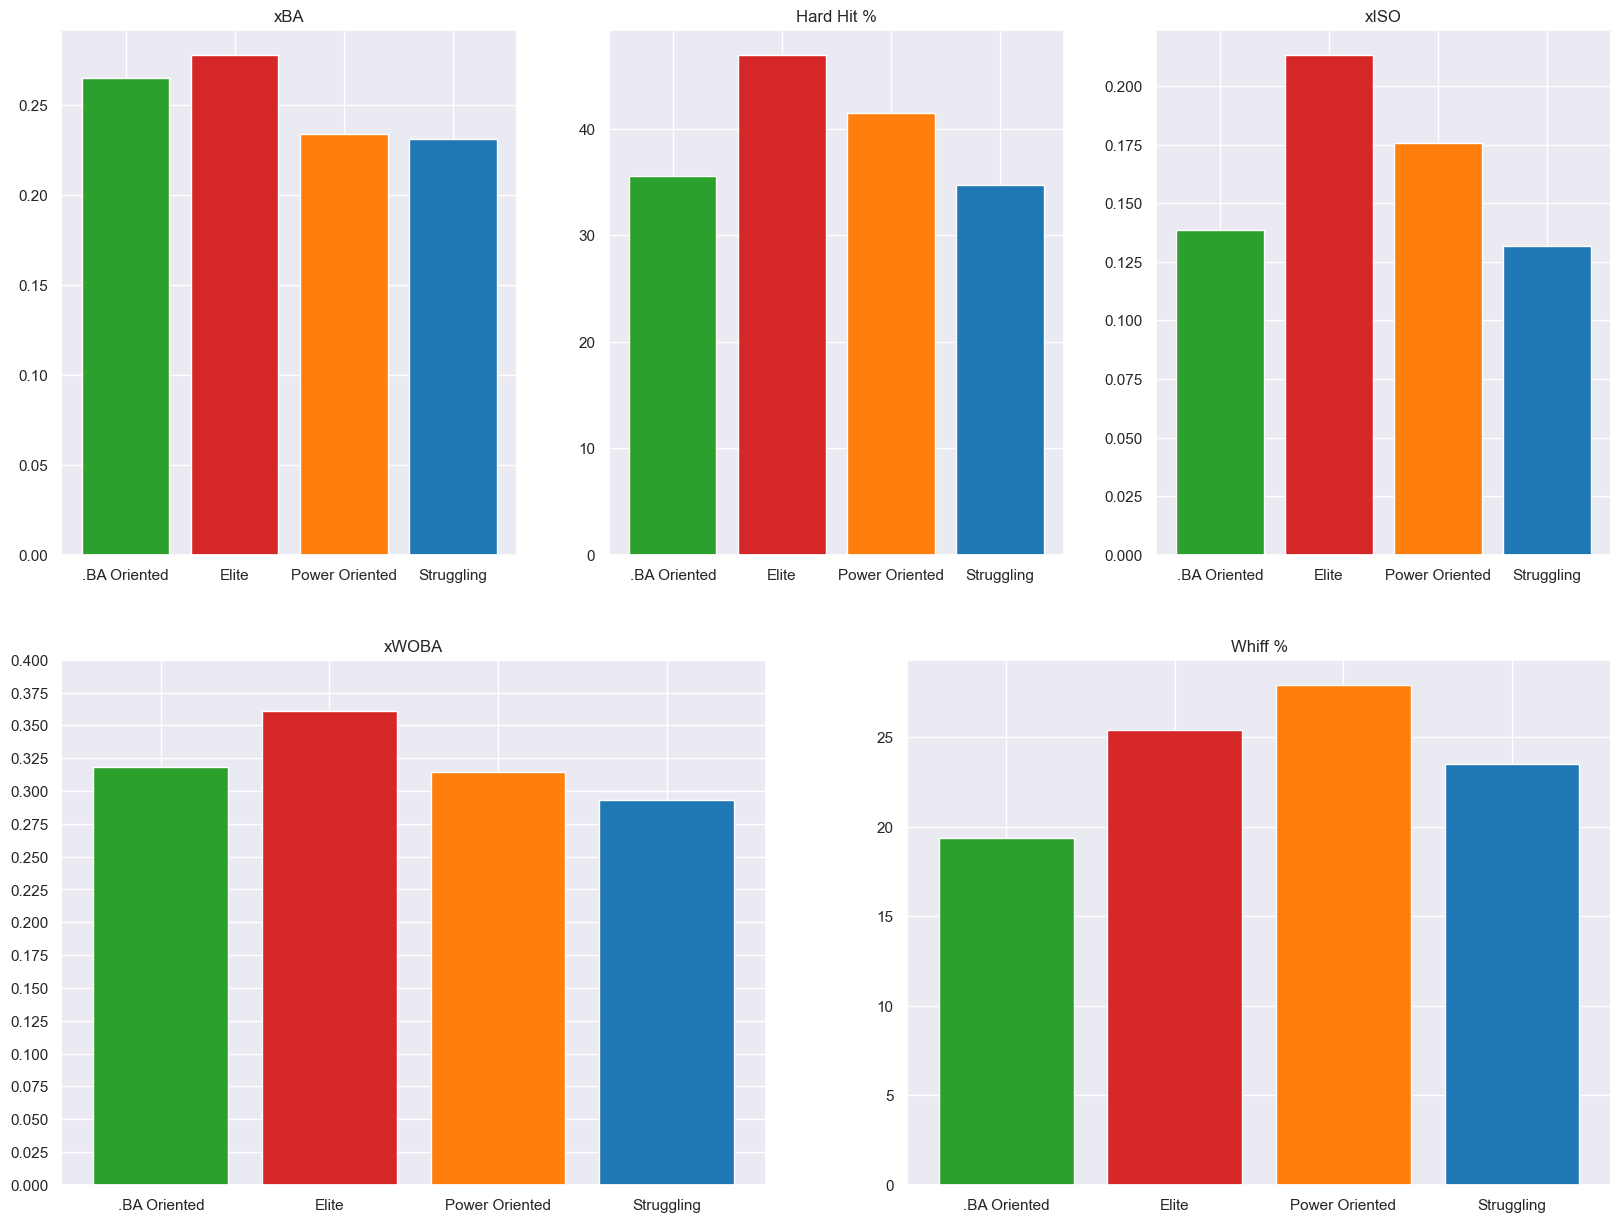

In [246]:
# Create Figure / Base for Subplots
fig, ax = plt.subplots(figsize = (20,15))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(2,3), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,3), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,3), loc=(0,2))
ax4 = plt.subplot2grid(shape=(2,2), loc=(1,0))
ax5 = plt.subplot2grid(shape=(2,2), loc=(1,1))


# Define a color map for the 'hit_class' categories
color_map = {'Struggling':'tab:blue', 'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}


# Build out subplots

# xBA
agg_grouped = grouped.groupby('hit_class').agg({'xba': 'mean'}).reset_index()
bars = ax1.bar(agg_grouped['hit_class'], agg_grouped['xba'], color=[color_map[hit_class] for hit_class in agg_grouped['hit_class']])
ax1.set_title('xBA')

# Hard Hit Percent
agg_grouped2 = grouped.groupby('hit_class').agg({'hard_hit_percent': 'mean'}).reset_index()
bars = ax2.bar(agg_grouped2['hit_class'], agg_grouped2['hard_hit_percent'], color=[color_map[hit_class] for hit_class in agg_grouped2['hit_class']])
ax2.set_title('Hard Hit %')

# xISO
agg_grouped3 = grouped.groupby('hit_class').agg({'xiso': 'mean'}).reset_index()
bars = ax3.bar(agg_grouped3['hit_class'], agg_grouped3['xiso'], color=[color_map[hit_class] for hit_class in agg_grouped3['hit_class']])
ax3.set_title('xISO')

# xwOBA
agg_grouped4 = grouped.groupby('hit_class').agg({'xwoba': 'mean'}).reset_index()
bars = ax4.bar(agg_grouped4['hit_class'], agg_grouped4['xwoba'], color=[color_map[hit_class] for hit_class in agg_grouped4['hit_class']])
ax4.set_title('xWOBA')
# Set y-axis intervals to 0.025
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 0.025, 0.025))  # Adjust interval to 0.025


# Whiff Percent
agg_grouped5 = grouped.groupby('hit_class').agg({'whiff_percent': 'mean'}).reset_index()
bars = ax5.bar(agg_grouped5['hit_class'], agg_grouped5['whiff_percent'], color=[color_map[hit_class] for hit_class in agg_grouped5['hit_class']])
ax5.set_title('Whiff %')

**INSIGHTS & IMPLICATIONS:**
* **xBA**: As expected, 'Elite' and '.BA oriented' hitters lead this category, with 'Elite' hitters having a slight edge. There is an approx. 0.04 xBA drop off until the next two categories, where 'Power Oriented' just barely takes the lead over 'Struggling' hitters.  
* **Hard Hit %**: The two to classes in 'Power Oriented' and 'Elite' have Hard Hit %s and above 40%, with '.BA oriented' and 'Struggling' hitters falling around 35%.
* **xISO**: 'Elite' has a significant lead in this category, exceeding 'Power Oriented' hitters (2nd highest category) by approx 0.3 in xISO. The drop-off from these categories is quite significant, with '.BA Oriented' and 'Struggling' hitters having ISO values just around the 0.13 mark
* **xWOBA**: Once again, 'Elite' hitters have a significant lead in this metric (leads the next highest hitting class by approx. 0.05 xWOBA points). However, the most interesting fact is that '.BA oriented' hitters just barely beat out 'Power Oriented' hitters by approx. 0.01 xWOBA points. While this is not enough to conclude that '.BA Oriented' hitters are more 'valuable' in terms of their offensive production, its an interesting point worth following up as I progress with my analysis.
* **Whiff %**: 'Power Ortiented' and 'Elite' hitters lead this metric by a significant margin, 3-5% above the next highest category. On the other hand, '.BA Oriented' hitters had significantly lower whiff rates (~10% lower than 'Elite', 'Power Oriented'). This indicates that players with higher bat speeds will resort to more aggressive batting approaches (on average), resulting in the higher number of whiffs noted. 

**Overall:** 'Elite' hitters are the most valuable in offensive production, without a doubt. However, the debate between '.BA Oriented' and 'Power oriented' hitters is much more subjective. '.BA Hitters' have the slight lead in xWOBA, a stat seen as an all-encompassing method of evaluation for offensive production. Despite this, it's still difficult to ignore the lead which 'Power oriented' hitters have in xISO and hard hit %. As we're looking at a very surface-level assessment of the two categories, it would be unfair to conclude on whether one class is superior to the other. We may find out that each class has its place within an offensive lineup, ultimately being dependent on how a team chooses to construct its batting lineup. Certain classifications may also perform better in different scenarios, once again deterring from the insights I've just arrived at. As such, I'll continue my analysis by observing pitch-level data & analyzing roster/lineup construction by hit class in the following sections. The insights I've derived in this section will be used as more of a baseline, providing a reference for any notable trends we may notice later on. 

It's also worth mentioning how ineffective 'Struggling' hitters are in comparison to the rest of the other hitters. They are practically the worst in all of the categories we examined in this chart above, exemplifying how replaceable these hitters potentially are. As I progress into my analysis, I will want to question why this group struggles so much and whether their performance could be further optimized. 

## *How does swing length look for each group?*

Now that we've established the importance of bat speed and its implication on hitting performance, we should now investigate some of the factors which influence bat speed (potentially). As such, I decided to analyze how swing length is distributed among the different hitting classifications.

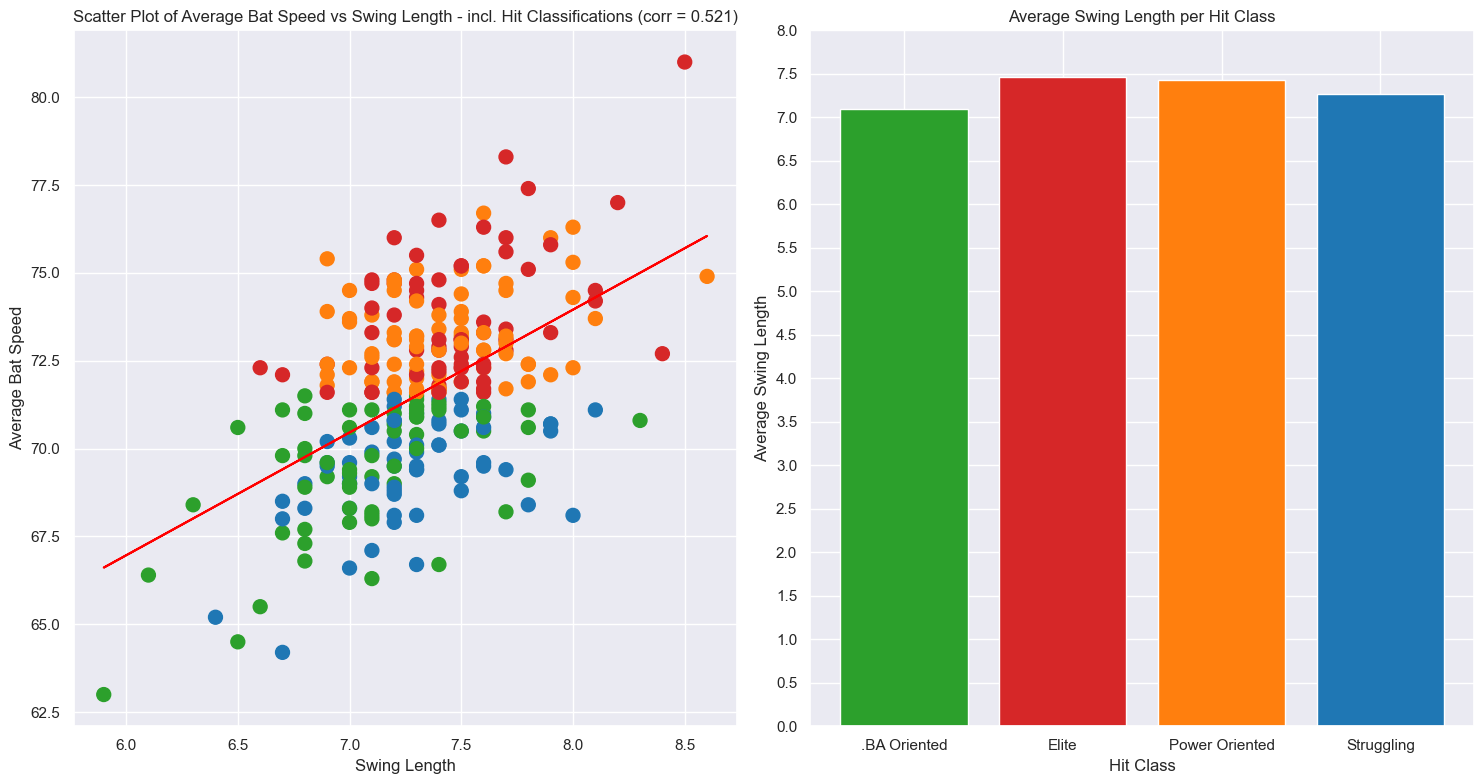

In [247]:
# Create Base for Plot
fig, ax = plt.subplots(figsize=(15,8))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Build out the Grid
ax1 = plt.subplot2grid(shape=(1, 2), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(1, 2), loc=(0, 1))

# Define a color map for the 'hit_class' categories
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Grid 1 - Swing Length Scatter Plot, y = bat speed  x = swing length
# Map the 'hit_class' values to colors
colors = grouped['hit_class'].map(color_map)

# Create the scatter plot
ax1.scatter(grouped['avg_swing_length'], grouped['avg_swing_speed'], color=colors, s=100)
ax1.set_xlabel('Swing Length')
ax1.set_ylabel('Average Bat Speed')
ax1.set_title('Scatter Plot of Average Bat Speed vs Swing Length - incl. Hit Classifications (corr = 0.521)')
ax1.grid(True)

# Plot a trend line
# Calculate the trend line (linear regression)
coefficients = np.polyfit(grouped['avg_swing_length'], grouped['avg_swing_speed'], 1)  # Fit a 1st degree polynomial (linear)
polynomial = np.poly1d(coefficients)
trendline = polynomial(grouped['avg_swing_length'])
# Plot the trend line
ax1.plot(grouped['avg_swing_length'], trendline, color='red', label='Trend line')

# Grid 2 - Average Swing Length per Hit Class
agg_grouped = grouped.groupby('hit_class').agg({'avg_swing_length': 'mean'}).reset_index()
ax2.bar(agg_grouped['hit_class'], agg_grouped['avg_swing_length'], color=[color_map[hit_class] for hit_class in agg_grouped['hit_class']])
ax2.set_title('Average Swing Length per Hit Class')
ax2.set_xlabel('Hit Class')
ax2.set_ylabel('Average Swing Length')
# Set y-axis intervals to 0.5
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 0.5, 0.5))  # Adjust interval to 0.5

# Display the plot
plt.tight_layout()
plt.show()


**INSIGHTS & IMPLICATIONS:**

There are a few things we can note from the plots above:
* There is **a somewhat strong, positive association between swing length and bat speed**.
* **'.BA oriented' hitters have shorter swing lengths**, being near the 7.0 mark. Compact swing lengths likely allow them to hit for higher averages while sacrificing their power output (as we noted in the previous section with the lower ISO values, but significantly higher xBA values).
* **'Power-oriented' and 'Elite' hitters have longer swing lengths**, nearly reaching the 7.5 mark. Longer swings likely allow them to generate the higher power output we noted from them earlier (i.e., higher ISO values). 
* **'Struggling' hitters fall in the middle of all of the categories**, being around the 7.3 mark. Perhaps, these hitters are struggling because they're lack of defined swing lengths and overall role in lineups? Or perhaps they're attempting to have a longer swing length to generate more power, but don't have the capability to match this approach? These are just low-level theories, but I'll explore these ideas as I progress.

## *Pitch-level Analysis: How does batting class perform against different pitches? Different Handed Pitchers? Other Features?*

To extract further insights regarding each hitting classification, its important to analyze performance at the pitch-level.

Rather than building out several subplots, I decided to create a series of interactive dashboards on Tableau: https://public.tableau.com/app/profile/jalal.zaheed/viz/Pitch-levelInsights-MLBBatSpeedAnalysisbyJalalZaheed/HitClassDashboard

Using this dashboard, I derived the following **key insights**:

### **Top Of The Zone 4-Seam Fastballs:**  The 4-seamer is the most commonly thrown pitch in the MLB in 2024. How does each classification perform?

*Top Of The Zone 4-Seamers, RHP only*

![High 4 Seamers Right](images/High%204%20Seam%20Right.png)

**ANALYSIS:**
* No classification has a clear advantage on this pitch
* ‘Struggling’ and ‘Elite’ hitters perform the best against this pitch
    * ‘Elite’ hitters experience above-average launch speeds within the middle of the zone, but also on the left outer part of the zone (up and in for righties, up and away to lefties)
    * ‘Struggling’ hitters experienced average - above average launch speeds predominantly in the middle of the zone, only average launch speeds on the outer parts
* ‘.BA oriented’ hitters performed similarly to ‘Elite’ hitters but with a lower amount of above-average launch speeds
* ‘Power Oriented’ hitters struggled against this pitch, especially on pitches away from the heart of the zone

*Top Of The Zone 4-Seamers, LHP only*

![High 4 Seamers Left](images/High%204%20Seam%20Left.png)

**ANALYSIS:** 
* ‘Power-oriented’ hitters have a clear advantage against this pitch. They have the highest concentration of above-average launch speeds within this zone (especially within the middle of the zone), also having moderate levels of average launch speeds around the outer parts of the zone
* The rest of the classifications perform quite similarly to one another. Each of them has some level of above-average launch speeds within the middle of the zone, and a moderate level of average launch speeds on the outer parts of the zone
  * ‘.BA oriented’ hitters have the most coverage in terms of average - slightly above average launch speeds on the outer parts of the zone

*Top Of The Zone 4-Seamers, LHP and RHP*

![High 4 Seamers](images/High%204%20Seam.png)

**ANALYSIS:** 

Observing this pitch from an overall standpoint, it’s evident that all classifications performed well. No group stood out from the rest, but I did make some observations:

* ‘.BA oriented’ hitters have the most ‘coverage’ (launch recorded) across the entire zone (both inside and outside of the strike zone)
* ‘Power-oriented’ hitters have the most above-average launch speeds recorded (highest concentration of dark red zones)
* ‘Struggling’ hitters perform well against this pitch and zone, maintaining similar launch speeds to other groups 
* ‘Elite’ hitters are the only classification to have average - slightly above average launch speeds above the zone 


### **Bottom Of The Zone Sinkers**:  Sinkers are another commonly thrown pitch in the MLB. How has each classification performed against them?

*Bottom Of The Zone Sinkers, RHP*

![Low Sinker Right](images/Low%20Sinker%20Right.png)

**ANALYSIS:** 

* ‘.BA oriented’ hitters had the highest concentration of above-average launch speeds (mainly in the middle of the zone). It also maintains average - slightly above average launch speeds on the outer left of the zone 
* ‘Elite’ hitters didn’t have as high concentrations of above-average launch speeds but maintained similar (if not better) levels of average - above-average launch speeds in outer parts
* ‘Struggling’ hitters had similar levels of above-average launch speed to the ‘Elite’ group, but experienced below-average launch speeds in the corners
* ‘Power Oriented’ hitters had the lowest concentration of above-average launch speeds throughout the zone. In comparison to ‘Struggling’ hitters, it maintained better launch speeds in the corner of the zones 


*Bottom Of The Zone Sinkers, LHP*

![Low Sinker Left](images/Low%20Sinker%20Left.png)

**ANALYSIS:** 
* ‘Elite’ hitters have the highest concentration of above-average launch speeds against this pitch (especially within the middle of the zone), maintaining average launch speeds around the outer parts of the zone
* ‘Power-oriented’ hitters have lower levels of above-average launch speeds than ‘Elite’ hitters, but they maintain better launch speeds throughout the middle of the zone (see the yellow shadows). Despite this, their launch speeds fall below ‘Elite’ levels towards the bottom portions of the zone.
* ‘.BA oriented’ hitters have lower levels of above-average launch speeds than ‘power-oriented’ hitters, but they maintain the best levels of launch speed throughout the zone. This includes the outer right part of the plate (inside to lefties, outside to righties) where it sustains slightly above-average launch speeds 
* ‘Struggling’ hitters performed the worst. They have the lowest levels of above-average launch speeds & have the worst coverage throughout the entire zone.

*Bottom Of The Zone Sinkers, LHP and RHP*

![Low Sinker](images/Low%20Sinker.png)

**ANALYSIS:** 

Observing this pitch from an overall standpoint, I noted the following:

* ‘Elite’ hitters performed the best from an overall perspective. This group has the highest concentration of above-average launch speeds (by a wide margin), maintaining the best launch speeds throughout the outer parts of the zone (especially on the outer left part of the zone (inside to righties, outside for lefties) 
* ‘.BA oriented’ hitters performed the second-best against this pitch.  While they lack above-average launch speeds, they maintain average launch speeds on the outside parts of the zone, even tailing into parts outside of the zone
* ‘Struggling’ hitters were 3rd in term performance. Their levels of above-average launch speeds were solid, but they lacked coverage across most of the strike zone
* ‘Power-oriented’ hitters were the worst performing. They had the lowest concentration of above-average launch speeds and had the worst coverage across the zone   

### **Bottom Of The Zone Sliders:** Sliders have become one of the most frequently thrown breaking balls in the game. How has each classification fared against them?



*Bottom Of The Zone Sliders, RHP*

![Low Sliders Right](images/Low%20Sliders%20Right.png)

**ANALYSIS:** 
* ‘Elite’ hitters excelled against this pitch. They had the highest concentration of above-average launch speeds. It also maintained decent launch speeds at the bottom and outer parts of the zone
* ‘Struggling’ had similar levels of above-average launch speeds to ‘Elite’ hitters, but had a smaller spread of average - slightly above-average launch speeds
* ‘Power-oriented’ hitters had a strong concentration of above-average launch speeds, but had a much smaller spread compared to other groups 
* ‘.BA oriented’ hitters had similar levels (if not better) coverage across the zone, but had significantly lower levels of average - above-average launch speeds throughout the zone

*Bottom Of The Zone Sliders, LHP*

![Low Sliders Left](images/Low%20Sliders%20Left.png)

**ANALYSIS:** 

* ‘Power-oriented’ hitters had the highest levels slightly above-average - above-average launch speeds throughout the heart of the zone, maintaining the best launch speeds in the bottom left corner of the zone (low and inside to righties, low and outside to lefties)
* ‘.BA oriented’ hitters had moderate levels of above-average launch speeds and had the most coverage of any class.
* ‘Struggling’ hitters had moderate levels of above-average launch speeds at the very heart of the zone, but had well below-average launch speeds in most other areas of the zone
* ‘Elite’ hitters did not match the levels of above-average launch speeds, nor did it match the average - slightly above-average launch speeds in the outer parts 

*Bottom Of The Zone Sliders, LHP and RHP*

![Low Sliders](images/Low%20Sliders.png)

**ANALYSIS:** 
Analyzing this pitch from an overall standpoint, I noted the following:

* ‘Elite’ hitters performed the best. They generated some of the highest concentrations of above-average launch speeds, maintaining average - slightly above-average launch speeds outside of the middle of the zone (best of levels of launch speed of any of the groups).
* ‘Power-oriented’ and ‘.BA oriented’ hitters are in a close battle for second. While ‘power-oriented’ hitters have a greater concentration of above-average launch speeds, ‘.BA oriented’ pitchers have greater coverage overall (especially outside the zone, closer to the bottom of the strike zone)
* ‘Struggling’ hitters have a good concentration of above-average launch speeds, but lack the spread of the other groups (especially towards the outer parts)     

### **Conclusion & Summary**

**‘Elite’** hitters separate themselves through their ability to hit well against all pitches (both LHP & RHP splits)
* ‘Elite’ hitters didn’t stand out when investigating certain LHP/RHP splits, but almost always looked the best when observing pitches from an overall standpoint
* ‘Elite’ pitchers dominated against sinkers & sliders, far outperforming other classifications
* Still maintained above-average launch speeds in the corners of the zone (a rarity for other classes)
* **Key Implication**: ‘Elite’ hitters are the preferred match-up against practically any type of pitcher, especially those with more complex arsenals (i.e., high secondary pitch usage rates)
    

**‘Power-oriented’** hitters are the most valuable class in specific LHP match-ups
* ‘Power-oriented’ hitters excelled in all of the LHP splits we observed, even against sliders and sinkers
* This group lacked average launch speeds on the outer parts of the zone but had the highest concentration of above-average launch speeds in the middle parts of the zone.
* **Key Implication**:  ‘Power-oriented’ hitters are the preferred match-up (on average) against LHP pitchers (especially those with higher fastball usage rates, and higher meatball %s ).
     


**‘.BA oriented’** hitters rarely stood out amongst the classifications, but consistently performed well
* This group was able to maintain average launch speeds in the corners of the zone, similar to that of ‘Elite’ hitters
* These hitters tended to lack above-average launch speeds for most of the pitches observed.
* **Key Implication**: ‘.BA oriented’ hitters are the preferred match-up (on average) against more complex pitchers when ‘Elite’ hitters are unavailable. They could also be leveraged against certain 1-on-1 matchups (i.e., RHP with higher sinker usage rates)   


**‘Strugging’** hitters are a mixed bag
* This group rarely stood out from the rest, struggling with secondary pitches (i.e., sinkers & sliders)
* Above-average launch speeds were often accompanied by well below-average launch speeds in the corners of the zone
* **Key Implication**: Determining when ‘Struggling’ hitters are the preferred match-up requires further analysis at the individual level. Teams can determine methods to leverage their strengths, mitigating the risk of subpar production.


**NOTE:** Teams should still consider the individual player’s attributes when assessing 1-on-1 matchups. These insights are meant as more of a surface-level assessment


# Roster & Lineup Construction-based Insights

Now that we've gotten an understanding for each individual hitting class, we should analyze how these classifications comprise individual MLB rosters. Through this analysis, I'll determine what is the **'ideal' batting lineup** for teams to model their offense (e.g., balanced lineup with all hitting classes, or just .BA Oriented and 'Elite' hitters?). 

In [248]:
# Load in roster dataset
rosters = pd.read_csv('../data/MLB Roster Data 0819.csv')
rosters.head()

Name Team  G  AB  PA  H  1B  2B  3B  HR  ...  HBP  SF  SH  GDP  SB  \
0  Jacob Wilson  OAK  1   1   1  1   1   0   0   0  ...    0   0   0    0   0   
1   Will Wagner  TOR  5  15  16  8   5   3   0   0  ...    0   0   0    0   0   
2  Samad Taylor  SEA  3   5   5  2   2   0   0   0  ...    0   0   0    0   0   
3  Austin Wynns  CIN  7  19  20  7   3   4   0   0  ...    1   0   0    0   0   
4  Grant McCray  SFG  4  14  15  5   2   2   0   1  ...    0   0   0    0   0   

   CS       AVG     NameASCII  PlayerId  MLBAMID  
0   0  1.000000  Jacob Wilson     33266   805779  
1   0  0.533333   Will Wagner     29634   695238  
2   0  0.400000  Samad Taylor     22274   669392  
3   0  0.368421  Austin Wynns     15271   642851  
4   0  0.357143  Grant McCray     25690   687529  

[5 rows x 25 columns]

## **Roster Construction Analysis:** What is the distribution of hitting classes across MLB Teams? Are there any noticeable trends?

We'll begin by analyzing how teams are constructing rosters based on these hitting classifications.

### **Data Cleaning**: Organizing & Applying Roster Data

Before any analysis can be done, we'll nead to apply our roster data to our own dataset. Following this, we'll need to clean up for any NA data that could disrupt our analysis.

In [249]:
# Merge the datasets using different column names for 'ID'
grouped = pd.merge(grouped, rosters[['MLBAMID', 'Team']], left_on='player_id', right_on='MLBAMID', how='left')

# Drop the 'MLBAMID' column if you don't need it in the final dataset
grouped = grouped.drop(columns=['MLBAMID'])

grouped.head()

last_name, first_name  player_id  year   pa  home_run  k_percent  \
0     Blackmon, Charlie     453568  2024  372         8       16.9   
1     McCutchen, Andrew     457705  2024  437        16       26.1   
2        Turner, Justin     457759  2024  395         7       18.5   
3       Santana, Carlos     467793  2024  446        17       17.3   
4           Pham, Tommy     502054  2024  350         7       20.6   

   bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
0         8.3        0.402            0.328             0.730  ...   
1        11.7        0.405            0.336             0.741  ...   
2        10.6        0.365            0.347             0.712  ...   
3        10.3        0.429            0.330             0.759  ...   
4         8.6        0.396            0.331             0.727  ...   

   opposite_percent  groundballs_percent  flyballs_percent  \
0              20.9                 38.8              25.3   
1              20.0                 41.9              27.2   
2              24.8                 34.8              29.3   
3              18.3                 37.9              29.3   
4              27.6                 43.1              20.7   

   linedrives_percent  player_age  side   woba  AgeGroup       hit_class  \
0                23.8          37     L  0.307     35-39      Struggling   
1                21.9          37     R  0.442     35-39  Power Oriented   
2                28.5          39     R  0.323     35-39      Struggling   
3                22.7          38     S  0.310     35-39      Struggling   
4                30.5          36     R  0.161     35-39           Elite   

    Team  
0    COL  
1    PIT  
2  - - -  
3    MIN  
4  - - -  

[5 rows x 38 columns]

Some of the players ended up being labeled as "- - -" as they moved teams during the year. As such, I needed to briefly clean up this data

In [250]:
# Filter for the players who changed teams
filtered = grouped[grouped['Team'] == "- - -"]
filtered

last_name, first_name  player_id  year   pa  home_run  k_percent  \
2          Turner, Justin     457759  2024  395         7       18.5   
4             Pham, Tommy     502054  2024  350         7       20.6   
30            Canha, Mark     592192  2024  412         7       21.1   
37         Rosario, Eddie     592696  2024  319        10       24.1   
48             Bell, Josh     605137  2024  504        18       19.4   
58          Winker, Jesse     608385  2024  423        11       21.7   
74           Soler, Jorge     624585  2024  447        16       24.8   
88          Rosario, Amed     642708  2024  287         2       17.4   
93          Jansen, Danny     643376  2024  256         8       18.0   
94    Kiner-Falefa, Isiah     643396  2024  334         7       14.1   
101          Arraez, Luis     650333  2024  517         3        5.0   
102         Jiménez, Eloy     650391  2024  282         5       19.9   
106     De La Cruz, Bryan     650559  2024  505        18       27.1   
114          Thomas, Lane     657041  2024  395         8       23.5   
117          DeJong, Paul     657557  2024  397        20       30.7   
139            France, Ty     664034  2024  388        11       23.2   
156    Chisholm Jr., Jazz     665862  2024  491        20       25.1   
167    Morel, Christopher     666624  2024  481        20       24.7   
171      Arozarena, Randy     668227  2024  487        16       24.8   
183          Senzel, Nick     669222  2024  264         7       22.7   
197        Paredes, Isaac     670623  2024  493        18       15.8   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
2          10.6        0.365            0.347             0.712  ...   
4           8.6        0.396            0.331             0.727  ...   
30         10.9        0.349            0.340             0.689  ...   
37          5.0        0.316            0.215             0.531  ...   
48          7.7        0.418            0.307             0.725  ...   
58         13.0        0.409            0.368             0.777  ...   
74         11.9        0.438            0.339             0.777  ...   
88          2.8        0.415            0.331             0.746  ...   
93         11.3        0.392            0.316             0.708  ...   
94          4.2        0.417            0.332             0.749  ...   
101         3.5        0.382            0.340             0.722  ...   
102         6.7        0.368            0.316             0.684  ...   
106         5.1        0.395            0.282             0.677  ...   
114         9.4        0.371            0.314             0.685  ...   
117         4.5        0.440            0.285             0.725  ...   
139         7.5        0.370            0.307             0.677  ...   
156         8.8        0.445            0.328             0.773  ...   
167        11.0        0.357            0.295             0.652  ...   
171        11.9        0.393            0.333             0.726  ...   
183        10.6        0.335            0.286             0.621  ...   
197        11.8        0.421            0.345             0.766  ...   

     opposite_percent  groundballs_percent  flyballs_percent  \
2                24.8                 34.8              29.3   
4                27.6                 43.1              20.7   
30               21.6                 49.3              21.6   
37               26.1                 40.3              32.3   
48               28.6                 46.9              25.6   
58               29.7                 48.7              21.2   
74               22.3                 36.3              29.5   
88               28.3                 52.2              17.7   
93               17.9                 26.3              33.5   
94               27.9                 46.0              22.3   
101              28.9                 42.6              24.4   
102              17.0                 60.2              12.6   
10

In [251]:
# Update the 'Team' column in the grouped DataFrame
grouped.loc[grouped['player_id'] == 457759, 'Team'] = 'SEA'
grouped.loc[grouped['player_id'] == 502054, 'Team'] = 'STL'
grouped.loc[grouped['player_id'] == 592192, 'Team'] = 'SFG'
grouped.loc[grouped['player_id'] == 592696, 'Team'] = 'ATL'
grouped.loc[grouped['player_id'] == 605137, 'Team'] = 'ARI'
grouped.loc[grouped['player_id'] == 608385, 'Team'] = 'NYM'
grouped.loc[grouped['player_id'] == 624585, 'Team'] = 'ATL'
grouped.loc[grouped['player_id'] == 642708, 'Team'] = 'LAD'
grouped.loc[grouped['player_id'] == 643376, 'Team'] = 'BOS'
grouped.loc[grouped['player_id'] == 643396, 'Team'] = 'PIT'
grouped.loc[grouped['player_id'] == 650333, 'Team'] = 'SDP'
grouped.loc[grouped['player_id'] == 650391, 'Team'] = 'BAL'
grouped.loc[grouped['player_id'] == 650559, 'Team'] = 'PIT'
grouped.loc[grouped['player_id'] == 657041, 'Team'] = 'CLE'
grouped.loc[grouped['player_id'] == 657557, 'Team'] = 'KCR'
grouped.loc[grouped['player_id'] == 664034, 'Team'] = 'CIN'
grouped.loc[grouped['player_id'] == 665862, 'Team'] = 'NYY'
grouped.loc[grouped['player_id'] == 666624, 'Team'] = 'TBR'
grouped.loc[grouped['player_id'] == 668227, 'Team'] = 'SEA'
grouped.loc[grouped['player_id'] == 669222, 'Team'] = 'CHW'
grouped.loc[grouped['player_id'] == 670623, 'Team'] = 'CHC'

With our dataset prepared, we can now proceed into our analysis:

In [252]:
grouped.head()

last_name, first_name  player_id  year   pa  home_run  k_percent  \
0     Blackmon, Charlie     453568  2024  372         8       16.9   
1     McCutchen, Andrew     457705  2024  437        16       26.1   
2        Turner, Justin     457759  2024  395         7       18.5   
3       Santana, Carlos     467793  2024  446        17       17.3   
4           Pham, Tommy     502054  2024  350         7       20.6   

   bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
0         8.3        0.402            0.328             0.730  ...   
1        11.7        0.405            0.336             0.741  ...   
2        10.6        0.365            0.347             0.712  ...   
3        10.3        0.429            0.330             0.759  ...   
4         8.6        0.396            0.331             0.727  ...   

   opposite_percent  groundballs_percent  flyballs_percent  \
0              20.9                 38.8              25.3   
1              20.0                 41.9              27.2   
2              24.8                 34.8              29.3   
3              18.3                 37.9              29.3   
4              27.6                 43.1              20.7   

   linedrives_percent  player_age  side   woba  AgeGroup       hit_class  Team  
0                23.8          37     L  0.307     35-39      Struggling   COL  
1                21.9          37     R  0.442     35-39  Power Oriented   PIT  
2                28.5          39     R  0.323     35-39      Struggling   SEA  
3                22.7          38     S  0.310     35-39      Struggling   MIN  
4                30.5          36     R  0.161     35-39           Elite   STL  

[5 rows x 38 columns]

### **Roster Construction Analysis**: Deriving Insights 

**NOTE:** All of the visualizations are **ordered by Team xWOBA values as of August 18th.**

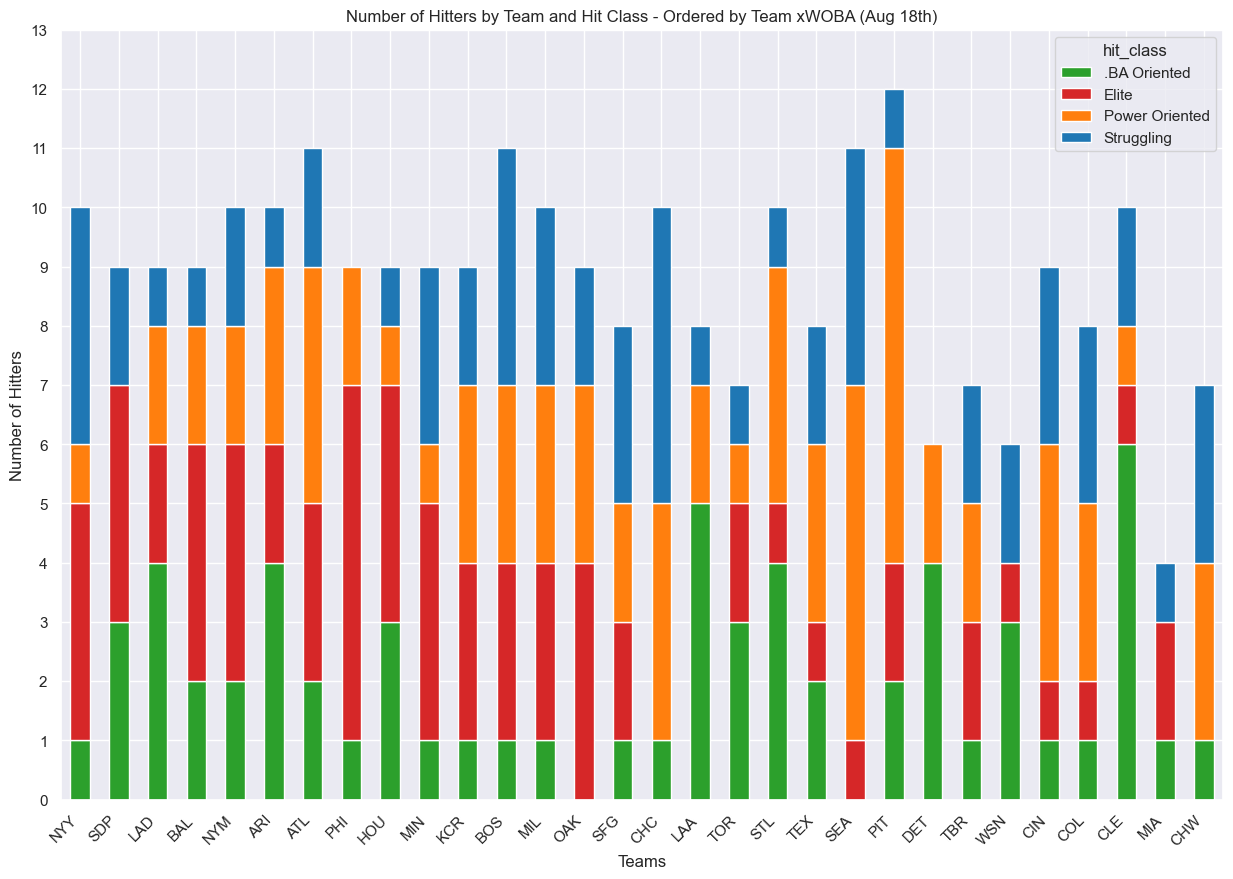

In [253]:
# Group the data by 'Team' and 'hit_class'
Teams_Grouped = grouped.groupby(['Team', 'hit_class']).size().unstack()

# Define the color map 
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]

# Define custom order (xWOBA Team Standings of August 18th)
custom_order = ['NYY', 'SDP', 'LAD', 'BAL', 'NYM', 'ARI', 'ATL', 'PHI', 'HOU', 'MIN', 'KCR', 'BOS', 'MIL', 'OAK', 'SFG', 'CHC', 'LAA', 'TOR', 'STL', 'TEX', 'SEA', 'PIT', 'DET', 'TBR', 'WSN', 'CIN', 'COL', 'CLE', 'MIA', 'CHW']

# Reindex the dataframe with the custom order
sorted_grouped = Teams_Grouped.reindex(custom_order)


# Create the stacked bar chart
sorted_grouped.plot(kind='bar', stacked=True, figsize=(15, 10), color=colors)
# Add title and labels
plt.title('Number of Hitters by Team and Hit Class - Ordered by Team xWOBA (Aug 18th)')
plt.xlabel('Teams')
plt.ylabel('Number of Hitters')
# Set y-axis intervals to 1.0
y_min, y_max = plt.ylim()
plt.yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Rotate the x-axis labels 
plt.xticks(rotation=45, ha='right')


plt.show()

To get a more interpretable view, I created the following tables. The tables are also **ordered by team xWOBA (as of August 18th)**:

![MLB Team By Hitting Class Table](images/MLB%20Team%20By%20Hitting%20Class%20Table.png)

![Hitting Class by xWOBA Ranking](images/Hitting%20Class%20by%20xWOBA%20Ranking.png)

**ANALYSIS & IMPLICATIONS:**

**1) 'Elite' hitters are an absolute need.** Within the top 10 teams in xWOBA, the average number of Elite hitters is 3.7 compared to below 2.0 for the rest of the 20 teams. This demonstrates how critical 'Elite' hitters are for offensive production, being a key determinant in a team's overall offensive production. Specifically, it seems the ideal number of 'Elite' hitters is **4**. 7 of the top 10 teams have 4 'Elite' hitters or more, demonstrating the significance of meeting this threshold. The Athletics are the only team with 4 'Elite' hitters and are not in the top 10, but this is mainly due to the balance of their lineup (this idea will be discussed in the next few bullet points). 

Certain teams within the top 10 have been able to undercut this threshold (Los Angeles Dodgers, Arizona Diamondbacks, Atlanta Braves), but you'll notice that their specialized players are all very close to 'Elite' status. Effectively, they still have players who provide close to the same level of offensive production as 'Elite' players. Thus, these teams don't need 4 'Elite' players on their roster. 

It's also worth mentioning how each of these teams have players who are performing well beyond the average (i.e., MVP levels). This includes Shohei Ohtani for the Dodgers, Marcell Ozuna for the Braves, and Ketel Marte for the Diamondbacks.

These ideas are visualized in the plot below:

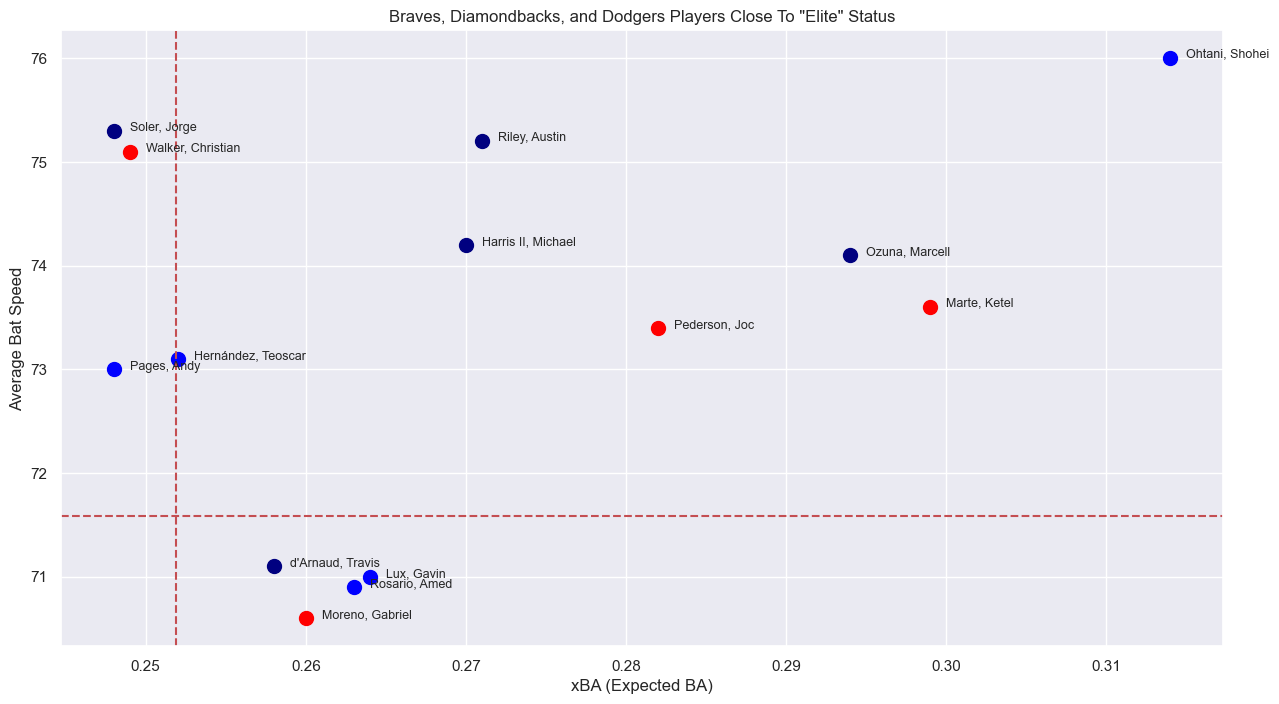

In [254]:
# Create a dataset for Dodgers, Diamondbacks, and Braves Players
Dodgers = grouped[grouped['Team'] == "LAD"]
Diamondbacks = grouped[grouped['Team'] == "ARI"]
Braves = grouped[grouped['Team'] == "ATL"]

# Filter for players closer to the averages, within 1 mph of the swing sweep & 0.005 of the xBA average
Dodgers = Dodgers[Dodgers['avg_swing_speed'] >= np.mean(grouped['avg_swing_speed']) - 1]
Dodgers = Dodgers[Dodgers['xba'] >= np.mean(grouped['xba']) - 0.005]
Diamondbacks = Diamondbacks[Diamondbacks['avg_swing_speed'] >= np.mean(grouped['avg_swing_speed']) - 1]
Diamondbacks = Diamondbacks[Diamondbacks['xba'] >= np.mean(grouped['xba']) - 0.005]
Braves = Braves[Braves['avg_swing_speed'] >= np.mean(grouped['avg_swing_speed']) - 1]
Braves = Braves[Braves['xba'] >= np.mean(grouped['xba']) - 0.005]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(Dodgers['xba'], Dodgers['avg_swing_speed'], color='blue', s=100)
plt.scatter(Diamondbacks['xba'], Diamondbacks['avg_swing_speed'], color='red', s=100)
plt.scatter(Braves['xba'], Braves['avg_swing_speed'], color='navy', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Braves, Diamondbacks, and Dodgers Players Close To "Elite" Status')
plt.grid(True)

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')

# Plot the names
for i, row in Dodgers.iterrows():
    plt.text(row['xba'] + 0.001, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')

for i, row in Diamondbacks.iterrows():
    plt.text(row['xba'] + 0.001, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')

for i, row in Braves.iterrows():
    plt.text(row['xba'] + 0.001, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


**2) Balance is needed. Overreliance on one hitting class will only lead to poor results.** Observing the top 10 teams, there is a clear distribution between the classes. 9 of the 10 teams have players in both the 'Power Oriented' Classes and the '.BA Oriented' class, with most of these teams spliting them quite evenly. Intuitively, it makes sense to balance these two classes as they perfectly complement one another. '.BA Oriented batters would set the table for 'Power Oriented' hitters to drive them in, creating the most efficient offences possible. With the numbers now visible to us, this assumption becomes stronger. Observing the data, it seems that a **2 of each category** (.BA Oriented, Power Oriented) seems like a perfect balance (assuming you are close to or have met the 4 'Elite' player target), but a **3-2/2-3 split in either direction is also favourable**. 

The notable exception to this concept is the San Diego Padres, ranked 2nd in Team xWOBA. This exception mainly occurs due to 2 main factors: 
1. SDP's 'Elite' hitters are among the best in the league. This includes Manny Machado, Fernando Tatis Jr, and Jurickson Profar, with the last 2 being among the top 25 players in xWOBA. Fernando Tatis especially covers this need for power-hitting, being among the top 25 players in xISO. Thus, they're able to compensate for more of the imbalance in San Diego's offense initially caused by the lack of 'Power Oriented' hitters (effectively, there is no deficiency in power hitting).
2. SDP's 'Struggling' hitters (Ha-Seong Kim, Luis Campusano) aren't performing too poorly. Analyzing both of these hitters further, it becomes clear that their expertise is getting on base even with lower xBA averages. In particular, Ha-Seong Him Ranks in the 93rd percentile in BB%, implicating his ability to get on base to create more run-creation opportunities. Admittedly, my analysis neglects an offensive capability outside of swinging a bat, so it's important I can acknowledge these areas when possible. As for Luis Campusano, he isn't too great at getting on base by hitting or walking either. However, he is in the 93rd percentile for K%, potentially indicating that his outs are more productive than most players (either maintaining the run-creation opportunities for other players or even progressing it). 

The charts below demonstrate the findings I just discussed.

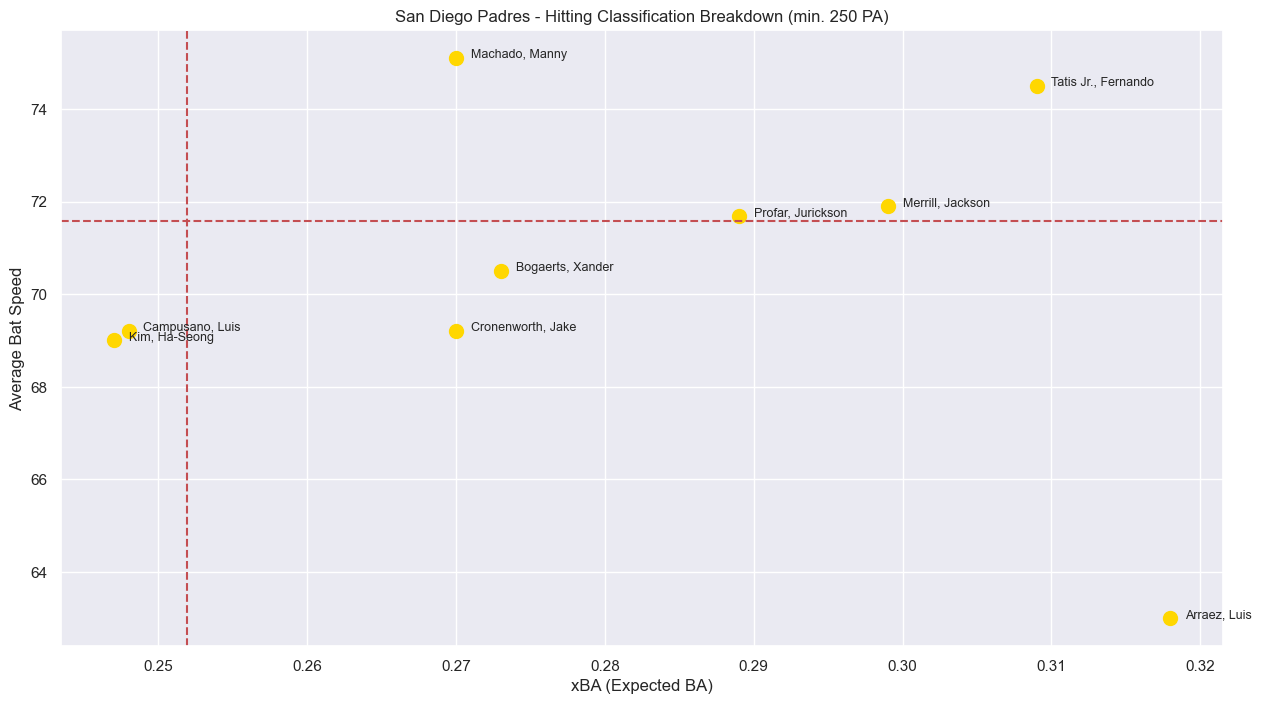

In [255]:
# Create dataset for Padres Players
SDP = grouped[grouped['Team'] == "SDP"]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(SDP['xba'], SDP['avg_swing_speed'], color='gold', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('San Diego Padres - Hitting Classification Breakdown (min. 250 PA)')
plt.grid(True)

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')


# Plot the name
for i, row in SDP.iterrows():
    plt.text(row['xba'] + 0.001, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


Outside of the top 10 teams in xWOBA, we can note many teams that are too heavily focused on one hitting category. Obvious examples include the Oakland Athletics (3 ' power-oriented' and 0 '.ba oriented'), Seattle Mariners (6 ' power-oriented' and 0 '.ba oriented'), Cleveland Guardians (6 '.ba oriented' and 1 'power-oriented), and the Pittsburgh Pirates (7 ' power-oriented' and 2 '.ba oriented'). The power-heavy offenses likely struggle from the lack of runners on bases which would set up their power hitters. As they're already crippled by the lack of 'Elite' hitters, it makes it difficult for these offenses to get anything generated with the lower xBAs of these 'power-oriented' hitters. On the other hand, offences dominated by '.ba oriented' hitters will likely struggle due to the lack of power in their offence. While players are able to get on base more often, the lack of power hitters to drive them in hurts their overall efficiency. Essentially, all offences require some sort of balance between '.ba oriented' and 'power-oriented' hitting (either through these specialises hitters, or through higher quality 'Elite' hitters) in some shape or form. 

To confirm all of these insights, I will further examine this idea as I analyze lineup construction across the MLB. 

**3) 'Struggling' hitters can be overcome, but not without a great amount of effort.**

Without a doubt, 'Struggling' hitters can significantly deter from a team's offensive performance. As we've previously established in our analysis, these hitters tend to rank lowest in all of the critical offensive metrics, including xBA, xWOBA, and xISO. Understanding this, its easy to note how the top 10 teams effectively mitigated these 'struggling' hitters, resulting in better overall production. The rest of these teams (11th - 20th especially) seemed to struggle with this, hindering their offences even despite the presence of 'Elite' hitters.

The main exception to this insight is the New York Yankees, being ranked as the top offense even despite having 4 'Struggling' hitters. Upon further examination, it becomes quite clear why this occurred:
1. Their 'Elite' hitters are among the best in the league. In particular, Aaron Judge and Juan Soto are the top 2 players in xWOBA and xISO. Given the offensive production of these 2 players alone, it makes sense that the deficiencies caused by 'Struggling' hitters are made up for. For what it's worth, Giancarlo Stanton (44th in xWOBA) and Austin Wells (42nd xWOBA) are among the top 50 players in terms of xWOBA. As the Yankees have such high-class players within their lineup, it makes sense for them to be atop the rankings despite the number of 'Struggling' hitters.
2. Their 'Struggling' hitters aren't performing too badly. As evidenced by the scatter plot below, all of their 'Struggling' hitters are within ~4mph of the bat speed average, and ~0.015 of the xBA average. As such, their performance isn't as much of a deterrence as other 'Struggling' players. Once again, I recognize that this is a weakness in my classification system. Thus, it's important that I continue to acknowledge these flaws and contextualize them when necessary.

While the Yankees were able to mitigate the below-average performance of their 'Struggling' hitters, it's important to recognize how much of an anomaly this is. If it hadn't been for their extremely well-performing 'Elite' players, their offence would've been almost certainly below the top 10. As such, teams should focus on mitigating the number of 'Struggling' hitters they have (either through player acquisition, lineup control, player development, etc.) rather than actively attempting to counteract. I recognize that 'Struggling' hitters are inevitable, which is why my suggestion is based on "mitigating" the number rather than eliminating it. As we'll see in the next section, lineup control will play a critical role in this. 

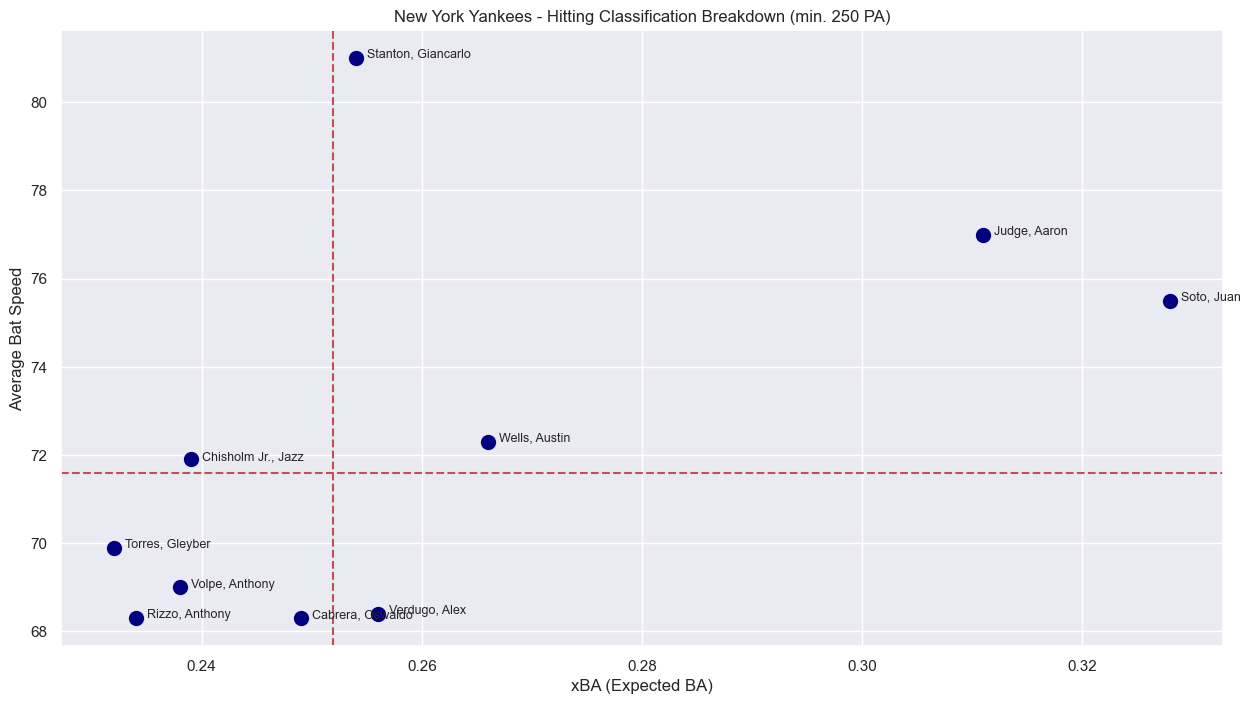

In [256]:
# Create dataset for Padres Players
NYY = grouped[grouped['Team'] == "NYY"]

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(NYY['xba'], NYY['avg_swing_speed'], color='navy', s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('New York Yankees - Hitting Classification Breakdown (min. 250 PA)')
plt.grid(True)

# Plot averages
plt.axhline(y=np.mean(grouped['avg_swing_speed']), color='r', linestyle='--')
plt.axvline(x=np.mean(grouped['xba']), color='r', linestyle='--')


# Plot the name
for i, row in NYY.iterrows():
    plt.text(row['xba'] + 0.001, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


## **Lineup Construction:** How have teams constructed their lineups? Are there any trends to note?

While the roster construction based analysis provided us with plenty of valuable insights, its important we expand on and validate these ideas through more in-depth analysis. More specifically, we need to analyze **how teams are constructing their lineups**. 

**IMPORTANT NOTE:** For purposes of this analysis, I will be extracting lineup roles from FanGraphs. Whatever FanGraphs has listed as their 'Role' is what I'll use for their assumed lineup position. I recognize that these players have likely varied in their role throughout the season, so I'll take this into account as I evaluate each lineup.

In [257]:
# Load all sheets from the Excel file
df = pd.read_excel('../data/Lineups.xlsx', sheet_name=None)

# Combine all sheets into a single DataFrame
Lineups = pd.concat(df.values(), ignore_index=True)

Lineups.head()

Name Role     Ovr  Last 7 Days Tue 8/20 vs. L Mon 8/19 vs. R  \
0     Taylor Ward    1    95.0        292.0         LF (1)         LF (1)   
1       Zach Neto    2    52.0        237.0         SS (2)         SS (2)   
2  Nolan Schanuel    3    97.0        118.0         1B (3)         1B (3)   
3    Niko Kavadas    4  1352.0        402.0            NaN         DH (4)   
4  Anthony Rendon    5   371.0        359.0         3B (6)         3B (5)   

  Sun 8/18 vs. R Sat 8/17 vs. L Fri 8/16 vs. R Wed 8/14 vs. R  ...  \
0         LF (1)         LF (1)         LF (1)         LF (5)  ...   
1         SS (2)         SS (2)         SS (2)            NaN  ...   
2         1B (3)         1B (3)         1B (3)         1B (1)  ...   
3         DH (4)            NaN         DH (4)            AAA  ...   
4            INJ            INJ         3B (6)         3B (2)  ...   

  Tue 5/28 vs. R.1 Thu 4/4 vs. R.1 Tue 5/14 vs. R.1 Mon 7/29 vs. R.1  \
0              NaN             NaN              NaN              NaN   
1              NaN             NaN              NaN              NaN   
2              NaN             NaN              NaN              NaN   
3              NaN             NaN              NaN              NaN   
4              NaN             NaN              NaN              NaN   

  Sat 6/22 vs. L Thu 5/23 vs. L Thu 5/16 vs. L Thu 5/9 vs. L Wed 4/17 vs. R.1  \
0            NaN            NaN            NaN           NaN              NaN   
1            NaN            NaN            NaN           NaN              NaN   
2            NaN            NaN            NaN           NaN              NaN   
3            NaN            NaN            NaN           NaN              NaN   
4            NaN            NaN            NaN           NaN              NaN   

  Wed 5/29 vs. R.1  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 310 columns]

### **Data Cleaning** - Lineups Data (Sourced from FanGraphs)

Due to the way FanGraphs formats their data, some data cleaning is needed:

In [258]:
# Function to add 'last_name, first_name' column to our lineup data
def reverse_format_name(formatted_name):
    # Split the formatted name by ', '
    last_name, first_name = formatted_name.split(', ', 1)
    # Combine into the desired format: 'first_name last_name'
    return f"{first_name} {last_name}"

# Apply the function to the 'last_name, first_name' column
grouped['Name'] = grouped['last_name, first_name'].apply(reverse_format_name)

# Remove any names from 'Lineups' dataset that aren't in the grouped one
lineups_mod = Lineups.merge(grouped[['Name']], how='inner', on='Name')

# Check number of names
lineups_mod['Name'].nunique()

260

There are 5 players missing from our dataset. Let's investigate this further:

In [259]:
# Find names in grouped that are not in Lineups_mod
excluded_names = grouped[~grouped['Name'].isin(lineups_mod['Name'])]

# Print excluded names
excluded_names

last_name, first_name  player_id  year   pa  home_run  k_percent  \
16   Springer III, George     543807  2024  469        14       19.2   
111    Mullins II, Cedric     656775  2024  370        13       21.1   
170     Rooker Jr., Brent     667670  2024  436        29       29.6   
179      Melendez Jr., MJ     669004  2024  342        14       24.6   
199          García, Luis     671277  2024  412        14       15.8   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
16         10.2        0.368            0.301             0.669  ...   
111         6.8        0.401            0.283             0.684  ...   
170         9.9        0.583            0.367             0.950  ...   
179         7.0        0.406            0.264             0.670  ...   
199         5.1        0.459            0.328             0.787  ...   

     groundballs_percent  flyballs_percent  linedrives_percent  player_age  \
16                  50.0              21.6                22.6          34   
111                 32.7              28.8                23.8          29   
170                 31.5              34.6                24.6          29   
179                 41.1              29.0                20.8          25   
199                 46.6              25.5                24.8          24   

     side   woba  AgeGroup       hit_class  Team                 Name  
16      R  0.323     30-34           Elite   TOR  George Springer III  
111     L  0.303     25-29      Struggling   BAL    Cedric Mullins II  
170     R  0.376     25-29           Elite   OAK     Brent Rooker Jr.  
179     L  0.388     25-29  Power Oriented   KCR      MJ Melendez Jr.  
199     L  0.323     20-24    .BA Oriented   WSN          Luis García  

[5 rows x 39 columns]

Upon further investigation, these errors occured due to differences in how FanGraphs and Baseball Savant stores players' names. As such, I'll make the following adjustments and re-merge the datasets

In [260]:
# Manually adjust specific rows (focusing on adjusting 'Name' column as we'll merge by this column)
grouped.loc[grouped['Name'] == 'George Springer III', 'Name'] = 'George Springer'
grouped.loc[grouped['Name'] == 'Cedric Mullins II', 'Name'] = 'Cedric Mullins'
grouped.loc[grouped['Name'] == 'Brent Rooker Jr.', 'Name'] = 'Brent Rooker'
grouped.loc[grouped['Name'] == 'MJ Melendez Jr.', 'Name'] = 'MJ Melendez'
grouped.loc[grouped['player_id'] == 671277, 'Name'] = 'Luis Garcia'
Lineups.loc[Lineups['playerId'] == 20391, 'Name'] = 'Luis Garcia' # Luis Garcia's name is giving issue due to the accent on the letter i. Thus, we'll adjust his name in both the 'Lineups' and 'grouped' datasets

# Remove any names from 'Lineups' dataset that aren't in the grouped one
lineups_mod = Lineups.merge(grouped[['Name']], how='inner', on='Name')

# Check number of names
lineups_mod['Name'].nunique()

265

With this sorted, I'll now focus on assigning a role to every single player:

In [261]:
# Check for any values that aren't a listed lineup role (e.g., 1 - 9)
no_role = lineups_mod[
    (lineups_mod['Role'] != "1") &
    (lineups_mod['Role'] != "2") &
    (lineups_mod['Role'] != "3") &
    (lineups_mod['Role'] != "4") &
    (lineups_mod['Role'] != "5") &
    (lineups_mod['Role'] != "6") &
    (lineups_mod['Role'] != "7") &
    (lineups_mod['Role'] != "8") &
    (lineups_mod['Role'] != "9")
]

no_role

Name   Role    Ovr  Last 7 Days Tue 8/20 vs. L  \
6         Luis Rengifo     IL  169.0          NaN             IL   
7       Willie Calhoun    AAA  250.0        226.0            AAA   
16         Kyle Tucker     IL  115.0          NaN            NaN   
25        Abraham Toro  Bench  203.0        269.0            NaN   
31     Davis Schneider  Bench  198.0        405.0            NaN   
..                 ...    ...    ...          ...            ...   
275        Paul DeJong    KCR  143.0         36.0            KCR   
276       Eloy Jiménez    BAL  263.0        313.0            BAL   
277         Tommy Pham    STL  180.0        338.0            STL   
286  Jazz Chisholm Jr.     IL   43.0          NaN             IL   
287      Anthony Rizzo     IL  253.0          NaN             IL   

    Mon 8/19 vs. R Sun 8/18 vs. R Sat 8/17 vs. L Fri 8/16 vs. R  \
6               IL             IL             IL             IL   
7              AAA            AAA            AAA            DFA   
16              IL            NaN            NaN            NaN   
25          3B (7)            NaN            NaN            NaN   
31             NaN            NaN         LF (7)            NaN   
..             ...            ...            ...            ...   
275            NaN            NaN            NaN            KCR   
276            NaN            NaN            NaN            BAL   
277            NaN            NaN            NaN            STL   
286            NaN            NaN            NaN             IL   
287            NaN            NaN            NaN             IL   

    Wed 8/14 vs. R  ... Tue 5/28 vs. R.1 Thu 4/4 vs. R.1 Tue 5/14 vs. R.1  \
6               IL  ...              NaN             NaN              NaN   
7           DH (4)  ...              NaN             NaN              NaN   
16              IL  ...              NaN             NaN              NaN   
25             NaN  ...              NaN             NaN              NaN   
31             NaN  ...              NaN             NaN              NaN   
..             ...  ...              ...             ...              ...   
275            KCR  ...              NaN             NaN              NaN   
276            BAL  ...              NaN             NaN              NaN   
277            STL  ...              NaN             NaN              NaN   
286             IL  ...              NaN             NaN              NaN   
287             IL  ...              NaN             NaN              NaN   

    Mon 7/29 vs. R.1 Sat 6/22 vs. L Thu 5/23 vs. L Thu 5/16 vs. L  \
6                NaN            NaN            NaN            NaN   
7                NaN            NaN            NaN            NaN   
16               NaN            NaN            NaN            NaN   
25               NaN            NaN            NaN            NaN   
31               NaN            NaN            NaN            NaN   
..               ...            ...            ...            ...   
275              NaN            NaN            NaN            NaN   
276              NaN            NaN            NaN            NaN   
277              NaN            NaN            NaN            NaN   
286              NaN            NaN            NaN            NaN   
287              NaN            NaN            NaN            NaN   

    Thu 5/9 vs. L Wed 4/17 vs. R.1 Wed 5/29 vs. R.1  
6             NaN              NaN              NaN  
7             NaN              NaN              NaN  
16            NaN              NaN              NaN  
25            NaN              NaN              NaN  
31            NaN              NaN              NaN  
..            ...              ...              ...  
275           NaN           SS (6)              NaN  
276           NaN           DH (4)              NaN  
277           NaN              AAA              NaN  
286           NaN              NaN              NaN  
287           NaN              NaN              

There are 91 players who have potential issues with their lineup entries. As such, I decided to extract the files and take a closer look at these players.

These players fell into 3 different categories, in which I would apply a different solution to apply their most accurate lineup position

1. Bench Players --> Apply the lineup position they most frequented (consider for recent trends in lineup position)
2. Injured Players --> Apply the lineup position they most frequented (pre-injury) (consider for recent trends in lineup position)
3. Players Who Switched Team --> Apply the lineup position most frequented while they were on this new team

As such, I made the following ammendments to these players:

In [262]:
import pandas as pd

# Define the data (the 91 values which needs to be re-adjusted)
data = {
    "Name": [
        "Luis Rengifo", "Willie Calhoun", "Kyle Tucker", "Abraham Toro", "Davis Schneider",
        "Bo Bichette", "Isiah Kiner-Falefa", "Justin Turner", "Danny Jansen", "Travis d'Arnaud",
        "Adam Duvall", "Ozzie Albies", "Austin Riley", "Eddie Rosario", "Jake Bauers",
        "Christian Yelich", "Blake Perkins", "Tommy Pham", "Michael Siani", "Mike Tauchman",
        "Christopher Morel", "Christian Walker", "Gabriel Moreno", "Ketel Marte", "Enrique Hernández",
        "Andy Pages", "Amed Rosario", "Mark Canha", "Patrick Bailey", "Jorge Soler",
        "David Fry", "Tyler Freeman", "Justin Turner", "Mitch Garver", "Dylan Moore",
        "J.P. Crawford", "Ty France", "Nick Gordon", "Jazz Chisholm Jr.", "Luis Arraez", "Bryan De La Cruz",
        "Josh Bell", "Jesse Winker", "Harrison Bader", "Ildemaro Vargas", "Joey Meneses",
        "Eddie Rosario", "Jesse Winker", "Lane Thomas", "Nick Senzel", "Eloy Jiménez",
        "Jordan Westburg", "Luis Campusano", "Fernando Tatis Jr.", "Ha-Seong Kim", "Michael A. Taylor",
        "Connor Joe", "Nick Gonzales", "Andrew McCutchen", "Ke'Bryan Hayes", "Jack Suwinski",
        "Jonah Heim", "José Caballero", "Ben Rortvedt", "Richie Palacios", "Amed Rosario",
        "Isaac Paredes", "Randy Arozarena", "Rob Refsnyder", "Danny Jansen", "Dominic Smith",
        "Amed Rosario", "Will Benson", "Jeimer Candelario", "Elias Díaz", "Maikel Garcia",
        "Hunter Renfroe", "Javier Báez", "Wenceel Pérez", "Gio Urshela", "Mark Canha",
        "Jose Miranda", "Manuel Margot", "Carlos Correa", "Byron Buxton", "Nick Senzel",
        "Paul DeJong", "Eloy Jiménez", "Tommy Pham", "Jazz Chisholm Jr.", "Anthony Rizzo"
    ],
    "Role": [
        2, 4, 2, 6, 7, 4, 1, 7, 7, 6, 6, 2, 3, 9, 5, 3, 9, 7, 9, 4, 3, 4, 6, 2, 8, 5, 7, 7, 5, 1,
        5, 7, 7, 5, 9, 1, 7, 6, 6, 1, 5, 4, 6, 9, 8, 4, 9, 6, 5, 6, 5, 5, 8, 2, 8, 9, 3, 5, 1, 6,
        8, 8, 7, 8, 6, 9, 5, 2, 3, 7, 8, 9, 9, 6, 4, 1, 5, 8, 1, 7, 7, 4, 1, 2, 5, 6, 7, 5, 7, 6, 6
    ],
    "playerId": [
        19858, 17838, 18345, 19844, 23565, 19612, 16512, 5235, 16535, 7739, 10950, 16556, 18360, 12155, 15194,
        11477, 19921, 2967, 22557, 15274, 21897, 13419, 22664, 13613, 10472, 24816, 15518, 11445, 27478, 14221,
        24934, 22532, 5235, 15161, 18042, 15491, 17982, 16337, 20454, 18568, 19600, 13145, 13590, 18030, 13324,
        14366, 12155, 13590, 16939, 19293, 17484, 27815, 22217, 19709, 27506, 11489, 16572, 27490, 9847, 18577,
        22244, 16930, 23401, 20287, 24589, 15518, 20036, 19290, 13770, 16535, 15653, 15518, 21853, 13621, 11680,
        22715, 15464, 12979, 22857, 10681, 11445, 20538, 14712, 14162, 14161, 19293, 18015, 17484, 2967, 20454, 3473
    ]
}

# Create a DataFrame for the updates
UpdateRoles = pd.DataFrame(data)

# Convert 'Role' in UpdateRoles to strings
UpdateRoles['Role'] = UpdateRoles['Role'].astype(str)

Let's now apply these updates to our own dataset:

In [263]:
# Function to apply updated roles
for i in range(len(UpdateRoles)):
    # Find the index of the playerId in lineups_mod
    index = lineups_mod[lineups_mod['Name'] == UpdateRoles.iloc[i]['Name']].index
    
    # Update the 'Role' column in lineups_mod for that index
    lineups_mod.iloc[index, lineups_mod.columns.get_loc('Role')] = UpdateRoles.iloc[i]['Role']
    
# Do individual iloc for Elias Diaz as his there was difficulty in updating his info
lineups_mod.loc[lineups_mod['playerId'] == 11680, 'Role'] = '4'

In [264]:
# Confirm that all roles are assigned
no_role = lineups_mod[
    (lineups_mod['Role'] != "1") &
    (lineups_mod['Role'] != "2") &
    (lineups_mod['Role'] != "3") &
    (lineups_mod['Role'] != "4") &
    (lineups_mod['Role'] != "5") &
    (lineups_mod['Role'] != "6") &
    (lineups_mod['Role'] != "7") &
    (lineups_mod['Role'] != "8") &
    (lineups_mod['Role'] != "9")
]

no_role

Empty DataFrame
Columns: [Name, Role, Ovr, Last 7 Days, Tue 8/20 vs. L, Mon 8/19 vs. R, Sun 8/18 vs. R, Sat 8/17 vs. L, Fri 8/16 vs. R, Wed 8/14 vs. R, Tue 8/13 vs. R, Mon 8/12 vs. R, Sun 8/11 vs. L, Sat 8/10 vs. L, Fri 8/9 vs. L, Thu 8/8 vs. L, Wed 8/7 vs. R, Wed 8/7 vs. R.1, Sun 8/4 vs. L, Sat 8/3 vs. L, Fri 8/2 vs. R, Thu 8/1 vs. R, Wed 7/31 vs. L, Tue 7/30 vs. R, Sun 7/28 vs. R, Sat 7/27 vs. R, Fri 7/26 vs. R, Thu 7/25 vs. R, Wed 7/24 vs. R, Tue 7/23 vs. R, Mon 7/22 vs. R, Sun 7/21 vs. R, Sat 7/20 vs. R, Fri 7/19 vs. L, Sun 7/14 vs. R, Sat 7/13 vs. R, Fri 7/12 vs. R, Thu 7/11 vs. R, Wed 7/10 vs. R, Tue 7/9 vs. R, Mon 7/8 vs. R, Sun 7/7 vs. R, Sat 7/6 vs. R, Fri 7/5 vs. L, Thu 7/4 vs. L, Wed 7/3 vs. R, Tue 7/2 vs. R, Sun 6/30 vs. R, Sat 6/29 vs. R, Fri 6/28 vs. R, Thu 6/27 vs. R, Wed 6/26 vs. R, Tue 6/25 vs. R, Mon 6/24 vs. R, Sat 6/22 vs. R, Fri 6/21 vs. R, Wed 6/19 vs. R, Tue 6/18 vs. R, Mon 6/17 vs. R, Sun 6/16 vs. L, Sat 6/15 vs. R, Fri 6/14 vs. R, Thu 6/13 vs. R, Wed 6/12 vs. R, Tue 6/11 vs. L, Sun 6/9 vs. R, Sat 6/8 vs. R, Fri 6/7 vs. L, Wed 6/5 vs. R, Tue 6/4 vs. R, Mon 6/3 vs. R, Sun 6/2 vs. R, Sat 6/1 vs. R, Fri 5/31 vs. R, Thu 5/30 vs. L, Wed 5/29 vs. R, Tue 5/28 vs. L, Sun 5/26 vs. R, Sat 5/25 vs. R, Fri 5/24 vs. L, Wed 5/22 vs. R, Tue 5/21 vs. R, Mon 5/20 vs. L, Sun 5/19 vs. R, Sat 5/18 vs. R, Fri 5/17 vs. L, Wed 5/15 vs. R, Tue 5/14 vs. R, Mon 5/13 vs. L, Sun 5/12 vs. R, Sat 5/11 vs. L, Fri 5/10 vs. R, Thu 5/9 vs. R, Wed 5/8 vs. L, Tue 5/7 vs. R, Mon 5/6 vs. R, Sun 5/5 vs. R, Sat 5/4 vs. R, Fri 5/3 vs. R, Wed 5/1 vs. R, ...]
Index: []

[0 rows x 310 columns]

Now that we've successfully added roles for every player, we can focus on removing any duplicate rows.

In [265]:
# Retrieve duplicated rows
duplicate_rows = lineups_mod[lineups_mod['Name'].duplicated()]

# Get indices of the duplicated rows
duplicate_indices = duplicate_rows.index

# Drop rows with duplicated indices from `lineups_mod`
lineups_finished = lineups_mod.drop(index=duplicate_indices)

lineups_finished.head()

Name Role    Ovr  Last 7 Days Tue 8/20 vs. L Mon 8/19 vs. R  \
0     Taylor Ward    1   95.0        292.0         LF (1)         LF (1)   
1       Zach Neto    2   52.0        237.0         SS (2)         SS (2)   
2  Nolan Schanuel    3   97.0        118.0         1B (3)         1B (3)   
3   Logan O'Hoppe    6  134.0        291.0          C (5)          C (6)   
4   Mickey Moniak    8  227.0        351.0            NaN         CF (8)   

  Sun 8/18 vs. R Sat 8/17 vs. L Fri 8/16 vs. R Wed 8/14 vs. R  ...  \
0         LF (1)         LF (1)         LF (1)         LF (5)  ...   
1         SS (2)         SS (2)         SS (2)            NaN  ...   
2         1B (3)         1B (3)         1B (3)         1B (1)  ...   
3            NaN          C (5)          C (5)            NaN  ...   
4         CF (8)            NaN         RF (7)         CF (6)  ...   

  Tue 5/28 vs. R.1 Thu 4/4 vs. R.1 Tue 5/14 vs. R.1 Mon 7/29 vs. R.1  \
0              NaN             NaN              NaN              NaN   
1              NaN             NaN              NaN              NaN   
2              NaN             NaN              NaN              NaN   
3              NaN             NaN              NaN              NaN   
4              NaN             NaN              NaN              NaN   

  Sat 6/22 vs. L Thu 5/23 vs. L Thu 5/16 vs. L Thu 5/9 vs. L Wed 4/17 vs. R.1  \
0            NaN            NaN            NaN           NaN              NaN   
1            NaN            NaN            NaN           NaN              NaN   
2            NaN            NaN            NaN           NaN              NaN   
3            NaN            NaN            NaN           NaN              NaN   
4            NaN            NaN            NaN           NaN              NaN   

  Wed 5/29 vs. R.1  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  

[5 rows x 310 columns]

With everything accounted for, we can finally add the lineup data to the 'grouped' dataset

In [266]:
# Add Lineup Role to 'grouped' dataset
grouped = grouped.merge(lineups_finished[['Name', 'Role']], on='Name', how='left')

grouped.head()

last_name, first_name  player_id  year   pa  home_run  k_percent  \
0     Blackmon, Charlie     453568  2024  372         8       16.9   
1     McCutchen, Andrew     457705  2024  437        16       26.1   
2        Turner, Justin     457759  2024  395         7       18.5   
3       Santana, Carlos     467793  2024  446        17       17.3   
4           Pham, Tommy     502054  2024  350         7       20.6   

   bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
0         8.3        0.402            0.328             0.730  ...   
1        11.7        0.405            0.336             0.741  ...   
2        10.6        0.365            0.347             0.712  ...   
3        10.3        0.429            0.330             0.759  ...   
4         8.6        0.396            0.331             0.727  ...   

   flyballs_percent  linedrives_percent  player_age  side   woba  AgeGroup  \
0              25.3                23.8          37     L  0.307     35-39   
1              27.2                21.9          37     R  0.442     35-39   
2              29.3                28.5          39     R  0.323     35-39   
3              29.3                22.7          38     S  0.310     35-39   
4              20.7                30.5          36     R  0.161     35-39   

        hit_class  Team              Name  Role  
0      Struggling   COL  Charlie Blackmon     1  
1  Power Oriented   PIT  Andrew McCutchen     1  
2      Struggling   SEA     Justin Turner     7  
3      Struggling   MIN    Carlos Santana     5  
4           Elite   STL        Tommy Pham     7  

[5 rows x 40 columns]

### **Lineup Construction Analysis:** Deriving Insights

To derrive some insights, I created a subplot matrix with all of the teams and their lineup breakdown by hitting class. 

**IMPORTANT NOTES:** 
* Beside each team I provided their record **as of August 21st, 2024**.
* If a team didn't have values for all 9 lineup slots, its likely because **they didn't have enough players that met the minimum 250 PA** threshold for those lineup slots

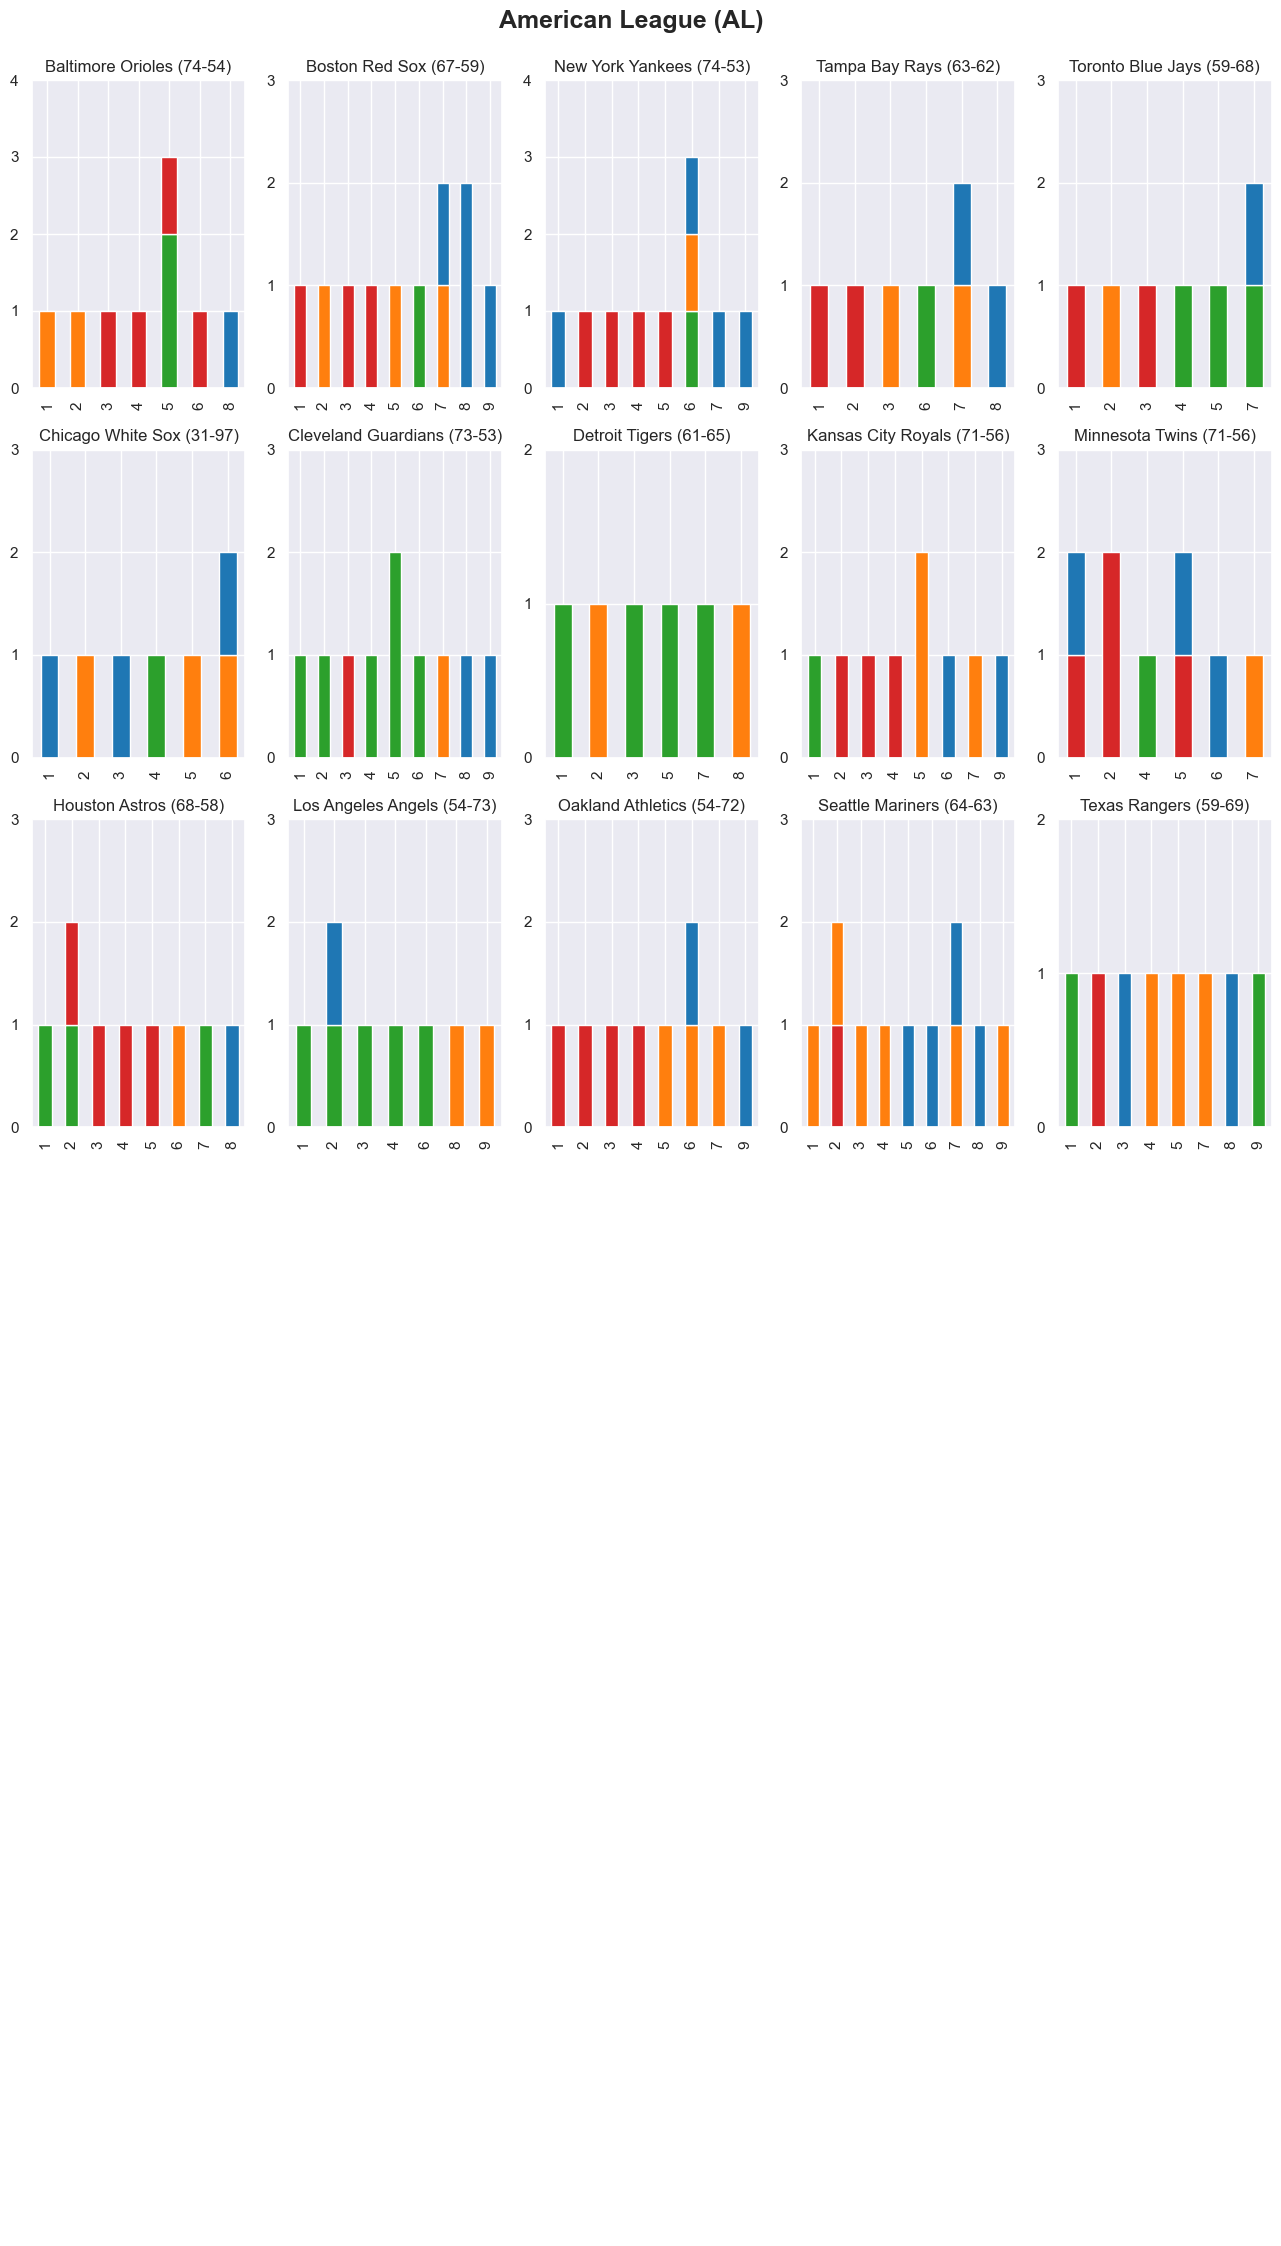

In [267]:
# Define the color map 
color_map = {'.BA Oriented': 'tab:green', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', 'Struggling': 'tab:blue'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]

# Create the frame for subplots
fig, ax = plt.subplots(figsize = (60,60))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(6,5), loc=(0,0))
ax2 = plt.subplot2grid(shape=(6,5), loc=(0,1))
ax3 = plt.subplot2grid(shape=(6,5), loc=(0,2))
ax4 = plt.subplot2grid(shape=(6,5), loc=(0,3))
ax5 = plt.subplot2grid(shape=(6,5), loc=(0,4))
ax6 = plt.subplot2grid(shape=(6,5), loc=(1,0))
ax7 = plt.subplot2grid(shape=(6,5), loc=(1,1))
ax8 = plt.subplot2grid(shape=(6,5), loc=(1,2))
ax9 = plt.subplot2grid(shape=(6,5), loc=(1,3))
ax10 = plt.subplot2grid(shape=(6,5), loc=(1,4))
ax11 = plt.subplot2grid(shape=(6,5), loc=(2,0))
ax12 = plt.subplot2grid(shape=(6,5), loc=(2,1))
ax13 = plt.subplot2grid(shape=(6,5), loc=(2,2))
ax14 = plt.subplot2grid(shape=(6,5), loc=(2,3))
ax15 = plt.subplot2grid(shape=(6,5), loc=(2,4))


## AL EAST ##

# Baltimore Orioles
BAL = grouped[grouped['Team'] == "BAL"]
BALplot = BAL.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in BALplot.columns]
# Create the stacked bar chart
BALplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax1, title = 'Baltimore Orioles (74-54)', xlabel = '')
ax1.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax1.get_ylim()
ax1.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Boston Red Sox
BOS = grouped[grouped['Team'] == "BOS"]
BOSplot = BOS.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in BOSplot.columns]
# Create the stacked bar chart
BOSplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax2, title = 'Boston Red Sox (67-59)', xlabel = '')
ax2.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# New York Yankees
NYY = grouped[grouped['Team'] == "NYY"]
NYYplot = NYY.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in NYYplot.columns]
# Create the stacked bar chart
NYYplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax3, title = 'New York Yankees (74-53)', xlabel = '')
ax3.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax3.get_ylim()
ax3.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Tampa Bay Rays
TBR = grouped[grouped['Team'] == "TBR"]
TBRplot = TBR.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in TBRplot.columns]
# Create the stacked bar chart
TBRplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax4, title = 'Tampa Bay Rays (63-62)', xlabel = '')
ax4.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Toronto Blue Jays
TOR = grouped[grouped['Team'] == "TOR"]
TORplot = TOR.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in TORplot.columns]
# Create the stacked bar chart
TORplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax5, title = 'Toronto Blue Jays (59-68)', xlabel = '')
ax5.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax5.get_ylim()
ax5.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0


## AL CENTRAL ##

# Chicago White Sox
CHW = grouped[grouped['Team'] == "CHW"]
CHWplot = CHW.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in CHWplot.columns]
# Create the stacked bar chart
CHWplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax6, title = 'Chicago White Sox (31-97)', xlabel = '')
ax6.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax6.get_ylim()
ax6.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0


# Cleveland Guardians
CLE = grouped[grouped['Team'] == "CLE"]
CLEplot = CLE.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in CLEplot.columns]
# Create the stacked bar chart
CLEplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax7, title = 'Cleveland Guardians (73-53)', xlabel = '')
ax7.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax7.get_ylim()
ax7.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Detroit Tigers
DET = grouped[grouped['Team'] == "DET"]
DETplot = DET.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in DETplot.columns]
# Create the stacked bar chart
DETplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax8, title = 'Detroit Tigers (61-65)', xlabel = '')
ax8.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax8.get_ylim()
ax8.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Kansas City Royals
KCR = grouped[grouped['Team'] == "KCR"]
KCRplot = KCR.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in KCRplot.columns]
# Create the stacked bar chart
KCRplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax9, title = 'Kansas City Royals (71-56)', xlabel = '')
ax9.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax9.get_ylim()
ax9.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Minnesota Twins
MIN = grouped[grouped['Team'] == "MIN"]
MINplot = MIN.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in MINplot.columns]
# Create the stacked bar chart
MINplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax10, title = 'Minnesota Twins (71-56)', xlabel = '')
ax10.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax10.get_ylim()
ax10.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0


## AL WEST ##

# Houston Astros
HOU = grouped[grouped['Team'] == "HOU"]
HOUplot = HOU.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in HOUplot.columns]
# Create the stacked bar chart
HOUplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax11, title = 'Houston Astros (68-58)', xlabel = '')
ax11.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax11.get_ylim()
ax11.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Los Angeles Angels
LAA = grouped[grouped['Team'] == "LAA"]
LAAplot = LAA.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in LAAplot.columns]
# Create the stacked bar chart
LAAplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax12, title = 'Los Angeles Angels (54-73)', xlabel = '')
ax12.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax12.get_ylim()
ax12.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Oakland Athletics
OAK = grouped[grouped['Team'] == "OAK"]
OAKplot = OAK.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in OAKplot.columns]
# Create the stacked bar chart
OAKplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax13, title = 'Oakland Athletics (54-72)', xlabel = '')
ax13.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax13.get_ylim()
ax13.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Seattle Mariners
SEA = grouped[grouped['Team'] == "SEA"]
SEAplot = SEA.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in SEAplot.columns]
# Create the stacked bar chart
SEAplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax14, title = 'Seattle Mariners (64-63)', xlabel = '')
ax14.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax14.get_ylim()
ax14.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Texas Rangers
TEX = grouped[grouped['Team'] == "TEX"]
TEXplot = TEX.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in TEXplot.columns]
# Create the stacked bar chart
TEXplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax15, title = 'Texas Rangers (59-69)', xlabel = '')
ax15.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax15.get_ylim()
ax15.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Built a title for the entire subplot grid
fig.suptitle('American League (AL)', fontsize=18, weight='bold', y = 0.905)


plt.show()

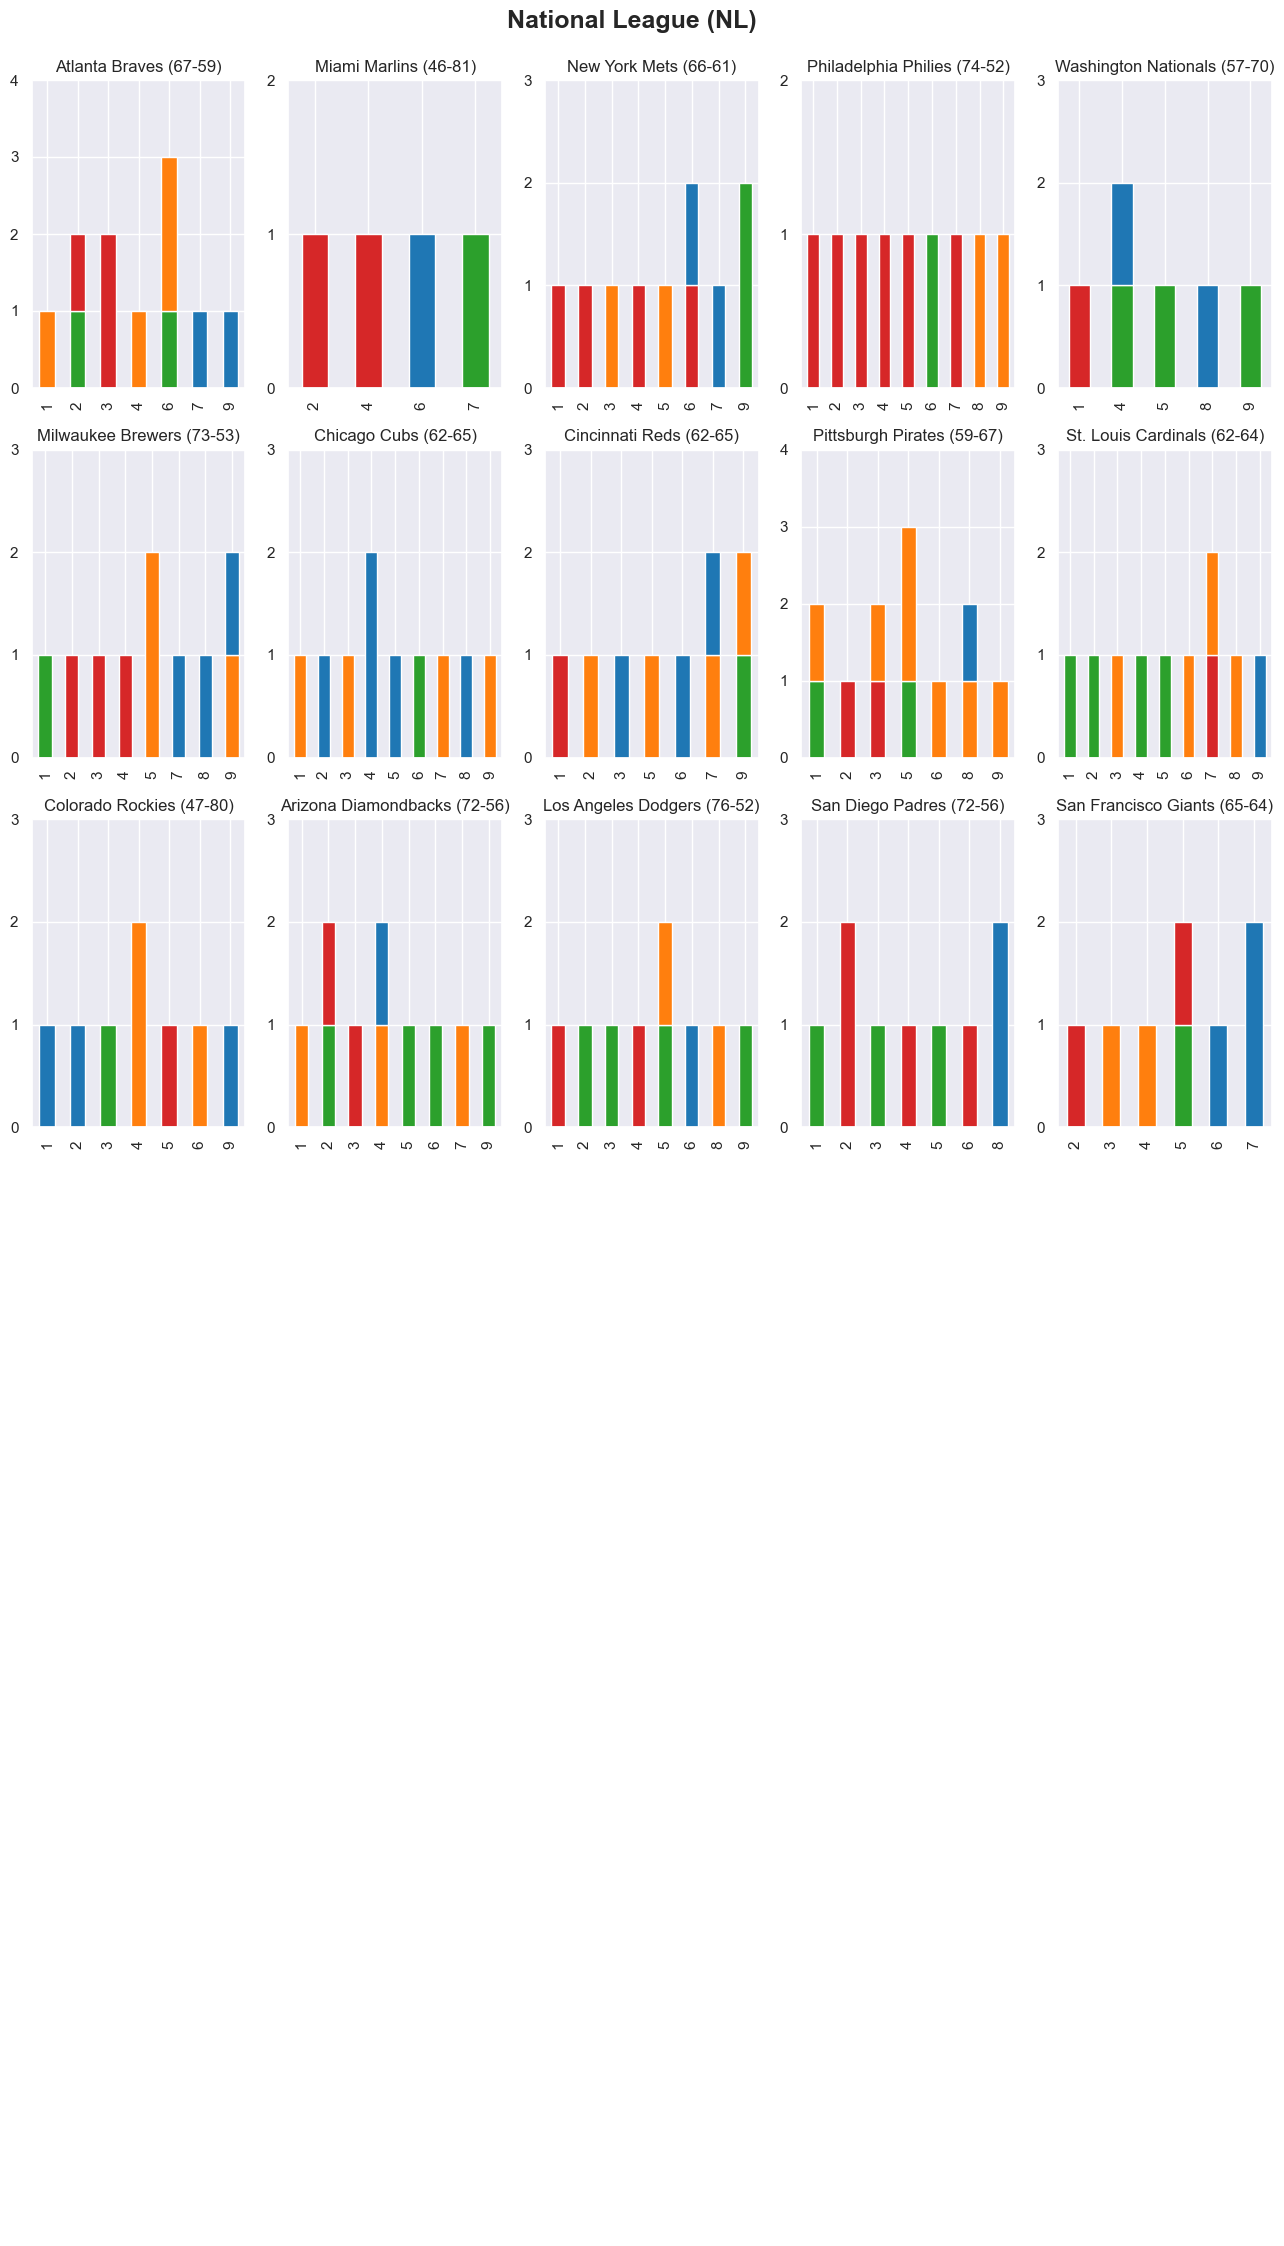

In [268]:
# Define the color map 
color_map = {'Struggling': 'tab:blue', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', '.BA Oriented': 'tab:green'}

# Get the colors for the bars
colors = [color_map[col] for col in Teams_Grouped.columns]

# Create the frame for subplots
fig, ax = plt.subplots(figsize = (60,60))

# Turn off outer axis ticks (from original ax)
ax.axis('off')

# Add spacing between subplots
plt.subplots_adjust(wspace=0.2, hspace=0.2) 

# Add Axes and Individual Grids - Subplot Grids
ax1 = plt.subplot2grid(shape=(6,5), loc=(0,0))
ax2 = plt.subplot2grid(shape=(6,5), loc=(0,1))
ax3 = plt.subplot2grid(shape=(6,5), loc=(0,2))
ax4 = plt.subplot2grid(shape=(6,5), loc=(0,3))
ax5 = plt.subplot2grid(shape=(6,5), loc=(0,4))
ax6 = plt.subplot2grid(shape=(6,5), loc=(1,0))
ax7 = plt.subplot2grid(shape=(6,5), loc=(1,1))
ax8 = plt.subplot2grid(shape=(6,5), loc=(1,2))
ax9 = plt.subplot2grid(shape=(6,5), loc=(1,3))
ax10 = plt.subplot2grid(shape=(6,5), loc=(1,4))
ax11 = plt.subplot2grid(shape=(6,5), loc=(2,0))
ax12 = plt.subplot2grid(shape=(6,5), loc=(2,1))
ax13 = plt.subplot2grid(shape=(6,5), loc=(2,2))
ax14 = plt.subplot2grid(shape=(6,5), loc=(2,3))
ax15 = plt.subplot2grid(shape=(6,5), loc=(2,4))


## NL EAST ##

# Atlanta Braves
ATL = grouped[grouped['Team'] == "ATL"]
ATLplot = ATL.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in ATLplot.columns]
# Create the stacked bar chart
ATLplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax1, title = 'Atlanta Braves (67-59)', xlabel = '')
ax1.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax1.get_ylim()
ax1.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Miami Marlins
MIA = grouped[grouped['Team'] == "MIA"]
MIAplot = MIA.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in MIAplot.columns]
# Create the stacked bar chart
MIAplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax2, title = 'Miami Marlins (46-81)', xlabel = '')
ax2.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax2.get_ylim()
ax2.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# New York Mets
NYM = grouped[grouped['Team'] == "NYM"]
NYMplot = NYM.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in NYMplot.columns]
# Create the stacked bar chart
NYMplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax3, title = 'New York Mets (66-61)', xlabel = '')
ax3.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax3.get_ylim()
ax3.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Philadelphia Philies
PHI = grouped[grouped['Team'] == "PHI"]
PHIplot = PHI.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in PHIplot.columns]
# Create the stacked bar chart
PHIplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax4, title = 'Philadelphia Philies (74-52)', xlabel = '')
ax4.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax4.get_ylim()
ax4.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Washington Nationals
WSN = grouped[grouped['Team'] == "WSN"]
WSNplot = WSN.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in WSNplot.columns]
# Create the stacked bar chart
WSNplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax5, title = 'Washington Nationals (57-70)', xlabel = '')
ax5.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax5.get_ylim()
ax5.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0


## NL CENTRAL ##

# Milwaukee Brewers
MIL = grouped[grouped['Team'] == "MIL"]
MILplot = MIL.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in MILplot.columns]
# Create the stacked bar chart
MILplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax6, title = 'Milwaukee Brewers (73-53)', xlabel = '')
ax6.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax6.get_ylim()
ax6.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Chicago Cubs
CHC = grouped[grouped['Team'] == "CHC"]
CHCplot = CHC.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in CHCplot.columns]
# Create the stacked bar chart
CHCplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax7, title = 'Chicago Cubs (62-65)', xlabel = '')
ax7.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax7.get_ylim()
ax7.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Cincinnati Reds
CIN = grouped[grouped['Team'] == "CIN"]
CINplot = CIN.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in CINplot.columns]
# Create the stacked bar chart
CINplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax8, title = 'Cincinnati Reds (62-65)', xlabel = '')
ax8.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax8.get_ylim()
ax8.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Pittsburgh Pirates
PIT = grouped[grouped['Team'] == "PIT"]
PITplot = PIT.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in PITplot.columns]
# Create the stacked bar chart
PITplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax9, title = 'Pittsburgh Pirates (59-67)', xlabel = '')
ax9.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax9.get_ylim()
ax9.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# St.Louis Cardinals
STL = grouped[grouped['Team'] == "STL"]
STLplot = STL.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in STLplot.columns]
# Create the stacked bar chart
STLplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax10, title = 'St. Louis Cardinals (62-64)', xlabel = '')
ax10.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax10.get_ylim()
ax10.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0


## NL WEST ##

# Colorado Rockies
COL = grouped[grouped['Team'] == "COL"]
COLplot = COL.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in COLplot.columns]
# Create the stacked bar chart
COLplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax11, title = 'Colorado Rockies (47-80)', xlabel = '')
ax11.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax11.get_ylim()
ax11.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Arizona Diamondbacks
ARI = grouped[grouped['Team'] == "ARI"]
ARIplot = ARI.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in ARIplot.columns]
# Create the stacked bar chart
ARIplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax12, title = 'Arizona Diamondbacks (72-56)', xlabel = '')
ax12.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax12.get_ylim()
ax12.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# Los Angeles Dodgers
LAD = grouped[grouped['Team'] == "LAD"]
LADplot = LAD.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in LADplot.columns]
# Create stacked bar plot
LADplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax13, title = 'Los Angeles Dodgers (76-52)', xlabel = '')
ax13.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax13.get_ylim()
ax13.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# San Diego Padres
SDP = grouped[grouped['Team'] == "SDP"]
SDPplot = SDP.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in SDPplot.columns]
# Create the stacked bar chart
SDPplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax14, title = 'San Diego Padres (72-56)', xlabel = '')
ax14.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax14.get_ylim()
ax14.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0

# San Francisco Giants
SFG = grouped[grouped['Team'] == "SFG"]
SFGplot = SFG.groupby(['Role', 'hit_class']).size().unstack()
# Ensure colors are mapped correctly
colors = [color_map[col] for col in SFGplot.columns]
# Create the stacked bar chart
SFGplot.plot(kind='bar', stacked=True, figsize=(16,28), color=colors, ax=ax15, title = 'San Francisco Giants (65-64)', xlabel = '')
ax15.legend().remove()
# Set y-axis intervals to 1.0
y_min, y_max = ax15.get_ylim()
ax15.set_yticks(np.arange(y_min, y_max + 1, 1))  # Adjust interval to 1.0


# Built a title for the entire subplot grid
fig.suptitle('National League (NL)', fontsize=18, weight='bold', y = 0.905)

plt.show()

To supplement this visualization, I created the following summary tables:

![MLB Lineup By Hitting Class Table](images/MLB%20Lineup%20By%20Hitting%20Class%20Table.png)

![Lineup Slot Analysis](images/Lineup%20Slot%20Analysis%20Exhibit.png)

##### **ANALYSIS & IMPLICATIONS - COMMON TRENDS:**
Analyzing the results, we notice some common trends that you would expect from teams. 

**‘Elite’ hitters in the 1-5 slots (especially 2-4) (1st in the 2-4 slots)**
* This makes sense given how favourable these hitters are in nearly all pitching match-ups. As such, you would want these hitters in the higher-leverage lineup slots
* This fact is especially true for the 2nd lineup slot (the highest value slot as identified in “The Book” by David Tango)

**‘.BA oriented’ hitters in the lead-off spots (33.33%, tied for 1st)**
* Intuitively, teams would want a player with a stronger baserunning ability and high .OBP to hit from the lead-off spot. As such, it makes sense for these hitters to dominate this slot. 
* It's interesting to note that the difference between class and ‘power-oriented’ hitters in the lead-off spot is just 13.33% (see next section for more analysis on this) 

**‘Power Oriented’ hitters near the middle of the lineup (4-7)  (especially the 5 & 7 spots) (1st in the 5 & 7 slots)**
* This aligns with intuition as you would want your ‘power hitters’ to drive in anybody who got on base from earlier. Rather than wasting these hitters in the earlier slots, you’re able to leverage their power-hitting tendencies to drive in more runs (more efficient, seemingly) 
* It’s interesting to note the lack of these hitters in the 4th spot (the clean-up spot). There are just as many ‘.BA oriented’ hitters as ‘power-oriented’ hitters in this slot. The trend I noted in the next slide may be a reason for this   

**‘Struggling’ hitters in near the bottom of the lineup (6th - 9th slots) (1st in the 6, 8, & 9 slots)**
* Once again, this trend is quite intuitive. You would want these hitters in lower-leverage spots and receiving fewer ABs, ensuring that your offense is focused on your ‘key hitters’ (lineup slots 1-5).
* It’s interesting to note the division between teams in the 9th spot. While some place their ‘Struggling’ hitters here, others prefer ‘specialized hitters’. This may be due to the influence that 9th hitters can have on the 1-3 slots, being the turnover spot. As such, it may be valuable to have an above-average hitter in this slot.   


##### **ANALYSIS & IMPLICATIONS - AN INTRIGUING TREND WITH THE LEAD-OFF SPOT**

**Teams leveraging 'power-oriented' hitters as their lead-off**. As an interesting contrast to the trend of '.BA oriented' or 'Elite' hitters within the leadoff spot, there were a few teams that experimented with a 'power-oriented' hitter as their lead-off. This includes the Atlanta Braves, Baltimore Orioles, Chicago Cubs, Arizona Diamondbacks, Seattle Mariners, and the Pittsburgh Pirates. For purposes of this analysis, I focused on 3 of these teams which yielded varying results from this approach:

**Atlanta Braves**: For Atlanta, they've been experimenting with 'power-oriented' hitters in their lineup slot since mid-June (approximately). Before then, the team would mainly rely on Ozzie Albies ('.BA Oriented') & Michael Harris II ('Elite') to take on this slot. However, the team switched to a 'power-oriented' hitter in Jarred Kelenic as their leadoff for most of July. **Jorge Soler** would then assume his role when he was acquired, but the team would switch back to Michael Harris II due to Soler's injury. From June 15th (when the approximate switch to 'Power Oriented' hitters occurred) to August 14th (the last day where Soler was the lead-off), Atlanta was 18th in the league in wRC+ being at 102. Before this period, Atlanta was 15th in the league in wRC+ at 96. As such, the lineup change wasn't the source of any drastic difference in performance. Investigating individual stats, Jarred Kelenic's performance marginally dropped as his 95 wRC+ dropped to 93 wRC+ (pre and post-lineup change, approximately). On the other hand, Jorge Soler was extremely successful in his stint with the Braves, hitting 169 wRC+ which was an increase from his 113 wRC+ with the Giants. The Giants also used Jorge Soler in this same lead-off spot from late June onwards (approx. June 28th until the trade. Pre-June 28th Soler had a 96 wRC+, but post-June 28th had a 157 wRC+ with the Giants). His increase could be due to various factors, but his performances pre & post role-changes is evident. Atlanta's team wRC+ was 122 during Soler's stint, being 5th in the league (there are various other factors to consider for as  Soler's contributions weren't the sole purpose for this trend. Nevertheless, it's clear that the Braves lineup was much more efficient during this period). Unfortunately, the small sample size makes it difficult to effectively conclude on how 'power-oriented' hitters like Soler could be optimized in the lead-off spot.
* **Overall Assessment:** While Jarred Kelenic’s stint in the lead-off spot had minimal impact on the Braves, Jorge Soler’s short stint showed much more promise. Why was this the case?  Aside from Jorge Soler’s better overall batted ball profiles at hitting performance (as of right now), I think it has to do with their plate discipline (Jorge Soler Profile, Jarred Kelenic Profile). Jorge Soler is far superior in taking pitches outside the zone (‘shadow’,‘ chase’, and ‘waste’ attack zones, see profile links), contributing to his well above-average walk %s (96th percentile in BB% as of Aug. 28th). On the other hand, Jarred Kelenic performs far worse in these zones having (-15 take runs relative to Jorge Soler in these zones). As such, Jorge Soler can generate better power outputs while also having better plate discipline, likely contributing to his success compared to Jarred Kelenic.

        
**Baltimore Orioles**: For most of the season, the Orioles kept Gunnar Henderson as their leadoff hitter ('Elite'). However, on approx. July 28th, the Orioles switched to Colton Cowser ('power oriented') as their leadoff hitter and has stuck to it since then. Cowser has hit 126 wRC+ since the lineup change (up until Aug. 22nd), a 6 wRC+ increase from his previous hitting numbers. As for the team itself, Baltimore has hit 123 wRC+ post the lineup change (4th in the league) compared to their 115 wRC+ (3rd in the league) pre-lineup change. As such, Baltimore has stayed in relatively the same position compared to the rest of the league, but their added productivity is worthy of note (although this is not directly attributable to the lineup change). I believe this lineup change was made due to two main factors: 1) Colten Cowser's baserunning speed. Even despite his power-hitting ability, Cowser ranked in the 82nd percentile for baserunning run value and 76th percentile for sprint speed (according to Baseball Savant)). His stolen base numbers certainly don't stand out, but his power-speed combo allows the Orioles to opt for power within their leadoff spot while also not entirely foregoing the speed which typically is found in '.BA Oriented' or 'Elite' hitters. 2) The Orioles wanted to maximize the value of their other 'Elite' hitters, including Gunnar Henderson. Pre the lineup change, Gunnar Henderson had 63 RBIs even despite his near-MVP level performance (90th+ percentile in all expected stats, top 10 in the league for wOBA and wRC+). This was even lower than his teammate Anthony Santander who had noticeably lower numbers in nearly all expected stats and wRC+. With the recent lineup change, Gunnar has driven in 15 RBIs which is tied for the team's lead during this period. Effectively, the lineup change allowed the Orioles to better leverage Cowser's power-speed combo, while also allowing them to maximize Gunnar Henderson's high-level offensive production (especially in the 3rd slot, often hitting behind Adley Rutschman who is a '.BA oriented' hitter).
* **Overall Assessment:** The Orioles have seemingly benefitted from Colton Cowser’s lead-off role, increasing their offensive production while keeping up with the rest of the league (only -1 in wRC+ standings). However, some may question why the Orioles chose to use Colton Cowser in the lead-off spot in the first place. From my perspective, I believe the Orioles wanted to leverage Gunnar Henderson’s MVP-level offensive production in a more valuable slot (e.g., 2-4 slots). This made the lead-off spot available, in which they noticed the power-speed combo of Colton Cowser (85th percentile baserunning value). In combination with his slightly above average walk %s and strong batted ball profile, Cowser appears as an ‘ideal’ lead-off candidate.


**Pittsburgh Pirates**: Pre-trade-deadline (before McCutchen was mostly removed from the lead-off spot), the Pittsburgh Pirates opted to use Andrew McCutchen ('power oriented') as their lead-off hitter. This may be a surprise to some given McCutchen's current lack of speed and relatively low .BA. However, it's clear the Pirates wanted to leverage both his power-hitting capabilities and ability to lay off pitches (extending counts, providing the following hitters with more info & further fatiguing the pitcher) (McCutchen is currently in the 100th percentile for chase %, 89th percentile in BB%). McCutchen was fairly average during his tenure in the lead-off spot, hitting for a .313 wOBA and a 99 wRC+ (just below the standard). The Pirates' offense was very lacking in 2024, being near the bottom of the league for wRC+ and xWOBA. Their poor performance isn't entirely attributable to their lineup construction as their whole offense has been inconsistent through 2024. However, it's not inherently wrong to believe their lineup construction didn't fully optimize their 'Elite' hitters such as O'Neil Cruz and Bryan Reynolds. McCutchen ranked 102nd in the leagues for doubles (11) as of pre-deadline, pairing this with below-average batted-ball metrics (32nd percentile in Hard-Hit%, 41st in avg. exit velocity). His walk percentages were solid, but McCutchen still had a tendency to have high strikeout percentages (23rd percentile in K%). Other successful lead-off power hitters (i.e., Jorge Soler, Colton Cowser) also struggle with strikeout percentages, but have above-average batted ball metrics. As such, McCutchen's performance didn't meet the level of productivity which is required for a 'power-oriented' hitter to succeed within this role. At the deadline the Pirates acquired Isiah Kiner-Falefa, allowing him to split the leadoff spot with McCutchen. Thus far, IKF has mostly taken over this spot with McCutchen battling injuries here and there. Post-trade-deadline, the Pirates' offense has been marginally better as it ranks 22nd in wRC+ (90) and wOBA (.300). These improvements are more contributable to the acquisitions the Pirates made (Bryan De La Cruz, IKF), but switching around their leadoff hitters may have been the cause for some of this improvement.
* **Overall Assessment**: The Pirates were unsuccessful with a ‘power-oriented’ lead-off hitter, now performing marginally better without one. Why is that?  I believe it’s due to Andrew McCutchen’s current hitting profile. While McCutchen still has moderate walk %s, he strikeouts far more often than other hitters (23rd percentile in K%). This leads to fewer productive outs, which deters from the team's ability to generate offense (a crucial aspect of a lead-off hitter). Combined with his less favourable batted ball profile (32nd percentile for Hard Hit %, 41st percentile in exit velo.), Andrew McCutchen had far less productive outs. As such, the Pirates didn’t benefit much from him being in the lead-off role 
 
Please see my presentation for more details & analysis on MLB teams' lineup constructions.

**Sources of data used in this section**: FanGraphs, Baseball Savant.

### Additional Analysis: Player Acquisition Analysis

While it's nice to understand how teams can structure their rosters around these classes, there is still a remaining issue: how do teams acquire these higher-value players when they come at a higher cost? To address this issue, I'll perform a brief analysis to find some players who may be underperforming for their current value (perceived value, at least).

#### *Which 'Elite' Players Are Having A 'Down Season' And Could Be Available?*

While this still isn't likely to be the most cost-effective option, teams could look into players having their 'worst' season while still reaching the 'Elite' classification. These are the type of players who may be having a down-season but are strong rebound candidates given their skillset (especially because of their above-average bat speed and ability to hit for an above-average xBA).

To identify these candidates, I first filter for 'Elite' hitters **0.02 of the xBA average**. I will then look into the historical statistics of each candidate and identify players in a 'down season'.


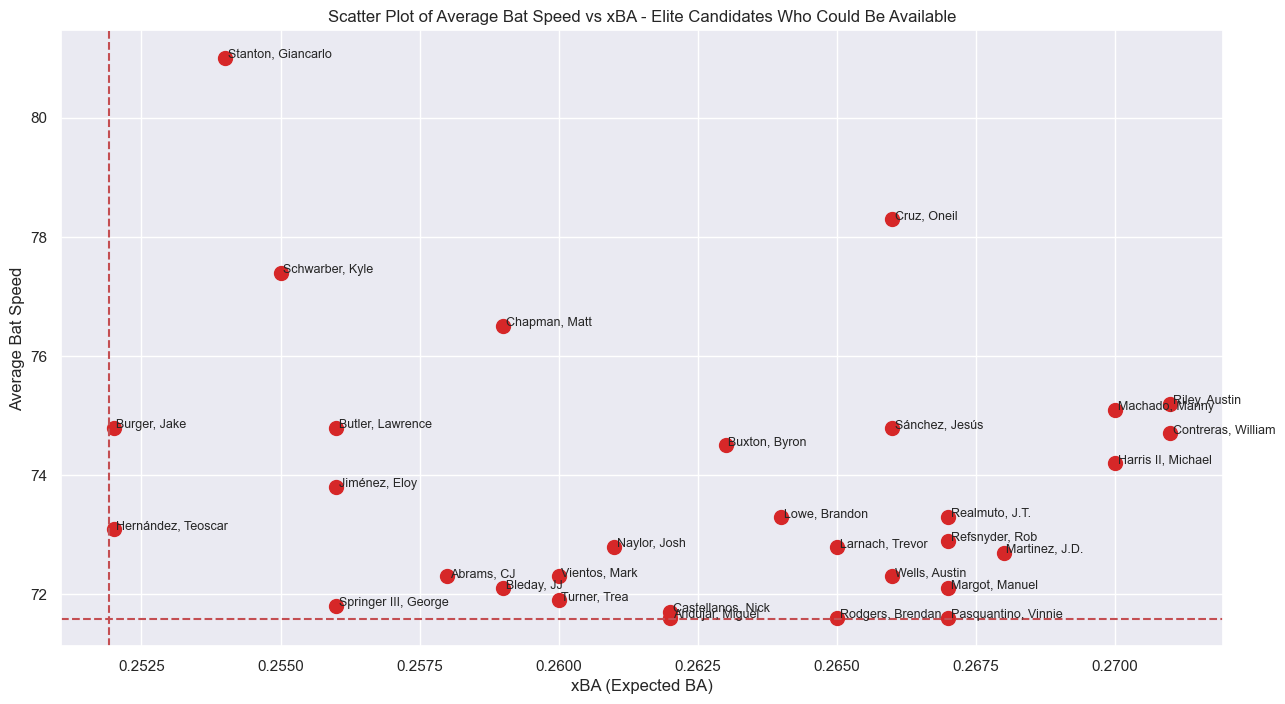

In [269]:
# Identify players who are within 0.02 of the xBA average
Elite = grouped[grouped['hit_class'] == "Elite"]
Elite_avail = Elite[Elite['xba'] <= 0.25192075471698117 + 0.02]


# Apply color for struggling
colors = ['tab:red']

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(Elite_avail['xba'], Elite_avail['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - Elite Candidates Who Could Be Available')
plt.grid(True)

# Plot averages
plt.axhline(y=71.5883018867924, color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=0.25192075471698117, color='r', linestyle='--', label = '_nolegend_')

# Plot the name
for i, row in Elite_avail.iterrows():
    plt.text(row['xba'] + 0.00005, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


In [270]:
Elite_avail

last_name, first_name  player_id  year   pa  home_run  k_percent  \
5          Martinez, J.D.     502110  2024  383        12       27.9   
12     Stanton, Giancarlo     519317  2024  329        20       30.1   
16   Springer III, George     543807  2024  469        14       19.2   
31      Castellanos, Nick     592206  2024  505        16       20.6   
33         Machado, Manny     592518  2024  479        18       19.6   
35         Realmuto, J.T.     592663  2024  303         8       23.8   
51     Hernández, Teoscar     606192  2024  515        26       27.8   
54           Turner, Trea     607208  2024  366        13       18.9   
59         Refsnyder, Rob     608701  2024  251         7       24.7   
61        Andujar, Miguel     609280  2024  286         4       13.3   
66          Buxton, Byron     621439  2024  335        16       26.6   
69         Margot, Manuel     622534  2024  281         4       15.7   
99           Naylor, Josh     647304  2024  476        26       17.0   
102         Jiménez, Eloy     650391  2024  282         5       19.9   
108         Chapman, Matt     656305  2024  518        19       24.1   
113       Schwarber, Kyle     656941  2024  518        28       27.2   
121        Sánchez, Jesús     660821  2024  398        15       25.9   
122    Contreras, William     661388  2024  526        16       20.0   
127         Riley, Austin     663586  2024  463        19       25.1   
128       Larnach, Trevor     663616  2024  283        11       20.5   
136      Rodgers, Brendan     663898  2024  415        10       22.4   
140         Lowe, Brandon     664040  2024  282        14       24.8   
155           Cruz, Oneil     665833  2024  443        18       32.3   
172            Bleday, JJ     668709  2024  483        15       18.0   
175         Vientos, Mark     668901  2024  293        19       25.3   
184         Wells, Austin     669224  2024  292         9       19.9   
190          Burger, Jake     669394  2024  415        24       26.7   
201      Butler, Lawrence     671732  2024  295        13       26.4   
202    Harris II, Michael     671739  2024  292         6       21.9   
241            Abrams, CJ     682928  2024  501        17       20.4   
249   Pasquantino, Vinnie     686469  2024  495        18       13.1   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
5          10.4        0.437            0.346             0.783  ...   
12          7.3        0.482            0.298             0.780  ...   
16         10.2        0.368            0.301             0.669  ...   
31          6.1        0.417            0.303             0.720  ...   
33          6.9        0.437            0.315             0.752  ...   
35          6.9        0.386            0.314             0.700  ...   
51          7.8        0.494            0.331             0.825  ...   
54          4.9        0.475            0.352             0.827  ...   
59         10.4        0.472            0.384             0.856  ...   
61          4.5        0.387            0.325             0.712  ...   
66          5.4        0.528            0.334             0.862  ...   
69          6.4        0.342            0.295             0.637  ...   
99          9.5        0.477            0.326             0.803  ...   
102         6.7        0.368            0.316             0.684  ...   
108        11.0        0.444            0.336             0.780  ...   
113        17.0        0.484            0.380             0.864  ...   
121         6.0        0.418            0.295             0.713  ...   
122         9.9        0.463            0.357             0.820  ...   
127         8.0        0.464            0.322             0.786  ...   
128         9.5        0.413            0.318             0.731  ...   
136         6.0        0.422            0.325             0.747  ...   
140         9.6        0.488            0.330             0.818  ...   
155         7.2        0.467            0.3

After extensively looking into each candidate, I found the following candidates who could be available in free agency:

*Eloy Jimenez*

*Manuel Margot*

*J.D. Martinez*

***See my presentation for a full breakdown and analysis***

#### *xwOBA vs. wOBA Analysis: Identifying More Acquisition Candidates*

To identify more acquisition candidates, I'll want to investigate the xWOBA and wOBA differences of each player. This may reveal some players who are more undervalued by teams (due to their seemingly reduced offensive production) and just require a little more patience.

In [271]:
# Calculate xwOBA - wOBA
grouped['diff'] = grouped['xwoba'] - grouped['woba']
grouped.head()

last_name, first_name  player_id  year   pa  home_run  k_percent  \
0     Blackmon, Charlie     453568  2024  372         8       16.9   
1     McCutchen, Andrew     457705  2024  437        16       26.1   
2        Turner, Justin     457759  2024  395         7       18.5   
3       Santana, Carlos     467793  2024  446        17       17.3   
4           Pham, Tommy     502054  2024  350         7       20.6   

   bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
0         8.3        0.402            0.328             0.730  ...   
1        11.7        0.405            0.336             0.741  ...   
2        10.6        0.365            0.347             0.712  ...   
3        10.3        0.429            0.330             0.759  ...   
4         8.6        0.396            0.331             0.727  ...   

   linedrives_percent  player_age  side   woba  AgeGroup       hit_class  \
0                23.8          37     L  0.307     35-39      Struggling   
1                21.9          37     R  0.442     35-39  Power Oriented   
2                28.5          39     R  0.323     35-39      Struggling   
3                22.7          38     S  0.310     35-39      Struggling   
4                30.5          36     R  0.161     35-39           Elite   

   Team              Name  Role   diff  
0   COL  Charlie Blackmon     1 -0.006  
1   PIT  Andrew McCutchen     1 -0.102  
2   SEA     Justin Turner     7  0.001  
3   MIN    Carlos Santana     5  0.017  
4   STL        Tommy Pham     7  0.180  

[5 rows x 41 columns]

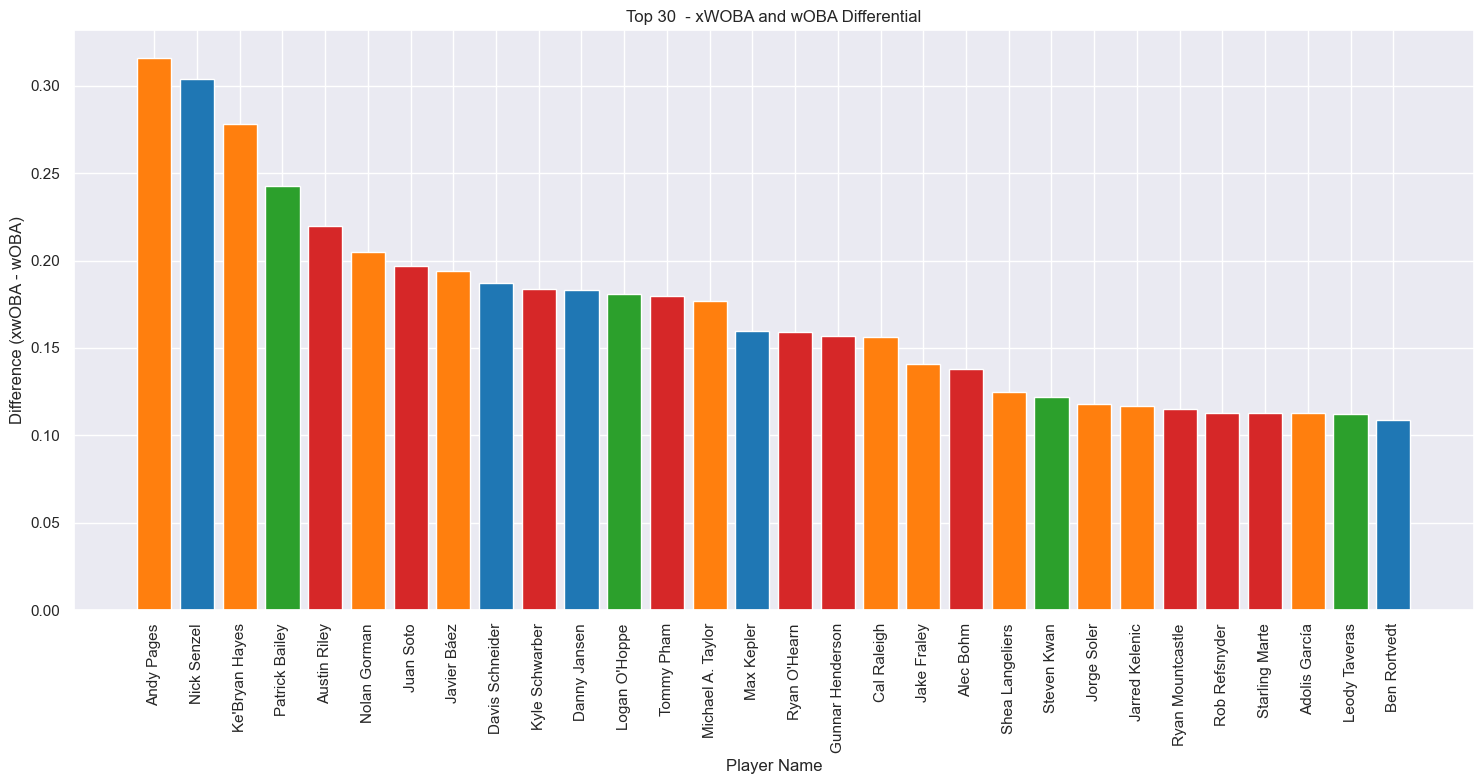

In [272]:
# Sort by 'diff'
grouped_sorted = grouped.sort_values(by='diff', ascending=False)

# Identify top 30 dff
Top30diff = grouped_sorted.head(30)

# Define the color map 
color_map = {'.BA Oriented': 'tab:green', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', 'Struggling': 'tab:blue'}

# Get the colors for the bars
colors = [color_map.get(classification, 'gray') for classification in Top30diff ['hit_class']]

# Plotting the bar chart
plt.figure(figsize=(15, 8))
plt.bar(Top30diff['Name'], Top30diff['diff'], color=colors)

# Adding labels and title
plt.xlabel('Player Name')
plt.ylabel('Difference (xwOBA - wOBA)')
plt.title('Top 30  - xWOBA and wOBA Differential')

# Rotate labels on the x-axis
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

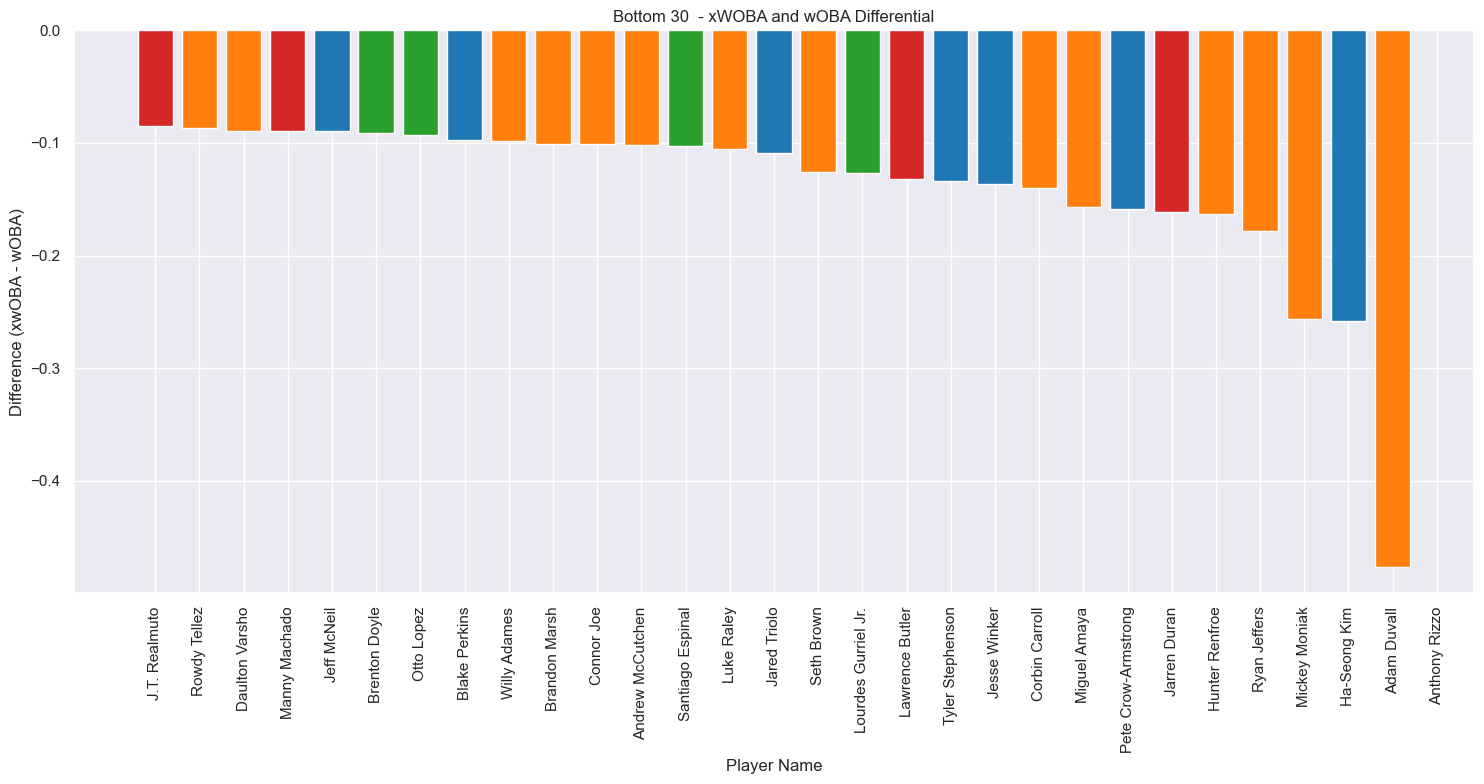

In [273]:
# Sort by 'diff'
grouped_sorted = grouped.sort_values(by='diff', ascending=False)

# Identify bottom 30 dff
bottom30diff = grouped_sorted.tail(50) # Although it notes 50 players, it actually does return 30 within the plot.

# Define the color map 
color_map = {'.BA Oriented': 'tab:green', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', 'Struggling': 'tab:blue'}

# Get the colors for the bars
colors = [color_map.get(classification, 'gray') for classification in bottom30diff ['hit_class']]

# Plotting the bar chart
plt.figure(figsize=(15, 8))
plt.bar(bottom30diff['Name'], bottom30diff['diff'], color=colors)

# Adding labels and title
plt.xlabel('Player Name')
plt.ylabel('Difference (xwOBA - wOBA)')
plt.title('Bottom 30  - xWOBA and wOBA Differential')

# Rotate labels on the x-axis
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [391]:
# EXTRA: Print out xwOBA wOBA differentials for 'elite' players identified in previous section
Eloy = grouped[grouped['player_id'] == 650391]
print(Eloy['diff'])
Manuel = grouped[grouped['player_id'] == 622534]
print(Manuel['diff'])
JD = grouped[grouped['player_id'] == 502110]
print(JD['diff'])

102    0.053
Name: diff, dtype: float64
69   -0.016
Name: diff, dtype: float64
5    0.043
Name: diff, dtype: float64


***See my presentation for a full breakdown and analysis***

# Player Development-based Insights: Data Exploration & Modelling

Leveraging my comprehensive understanding of bat speed & its implications on the MLB, I want to apply predictive analytics to answer the following:

1. Who are some players who could **significantly increase their performance due to a 0.1 - 2 mph increase** in their bat speed? - Candidates for Development
2. Who are some players who could **significantly decrease in performance due to a 0.1 - 1 mph loss in their bat speed?** - Candidates for Regression

Specifically, I'll be **estimating a player's xBA and xWOBA based on incremental changes in bat speed** for these 2 groups.

## Predictive Modelling Overview - Determining Predictors, Modelling Practices

To support my predictive models, I'll want to establish which variables are most correlated with these performance metrics (along side bat speed).

<Axes: >

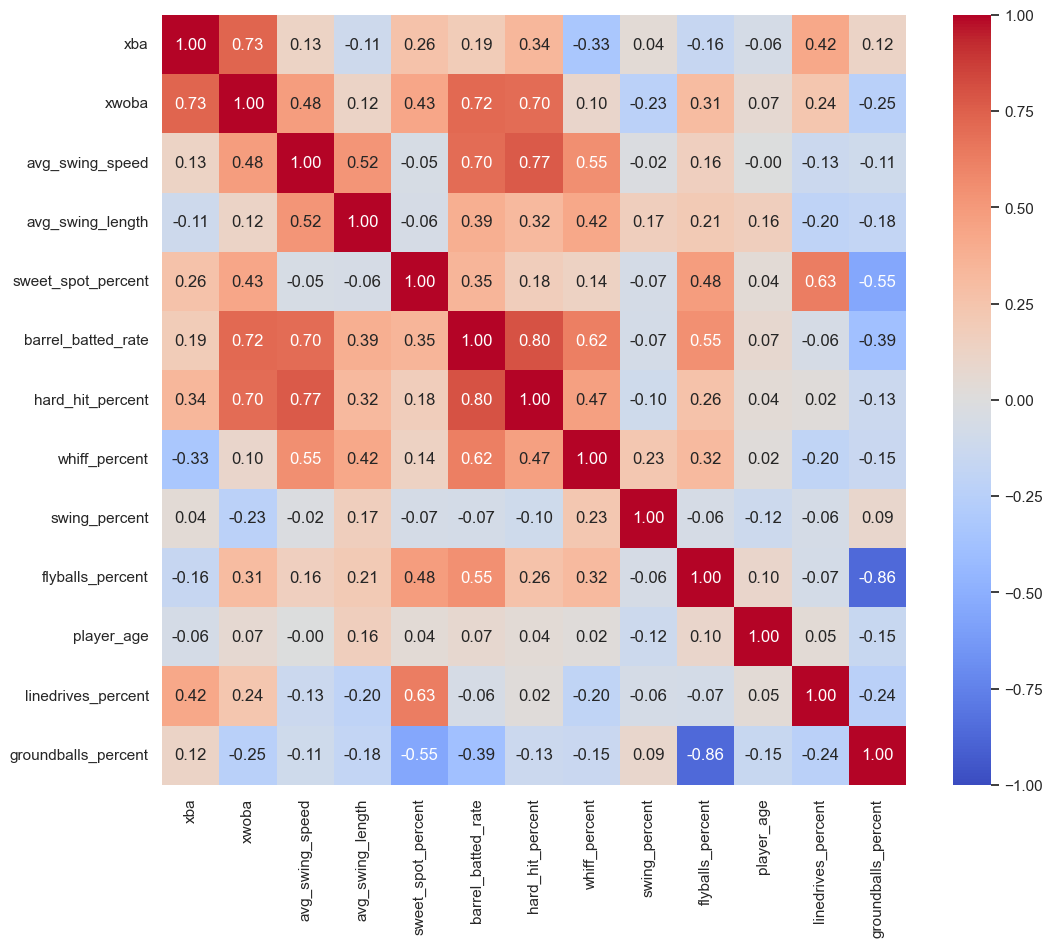

In [274]:
correlation_matrix = grouped[['xba', 'xwoba', 'avg_swing_speed', 'avg_swing_length', 'sweet_spot_percent', 'barrel_batted_rate', 
                     'hard_hit_percent', 'whiff_percent', 'swing_percent', 'flyballs_percent', 'player_age', 
                     'linedrives_percent', 'groundballs_percent']].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, center=0)


**Top 5 variabes most correlated with xBA** (ignoring xWOBA)
1. linedrives_percent (0.42)
2. hard_hit_percent (0.34)
3. whiff_percent (-0.33)
4. sweet_spot_percent (0.26)
5. barrel_batted_rate (0.19)

avg_swing_speed correlation with xBA was (0.13)


**Top 5 variables most correlated with xWOBA** (ignoring xBA)
1. barrel_batted_rate (0.72)
2. hard_hit_percent (0.70)
3. avg_swing_sped (0.48)
4. sweet_spot_percent (0.43)
5. flyballs_percent (0.31)

Based on the results, I've settled on the following predictors: 
**barrel_batted_rate, hard_hit_percent, avg_swing_speed, sweet_spot_percent, flyballs_percent**

### Data Modelling Practices:

***Why not use normalization?***
Whenever doing predictive analysis, I would typically normalize variables to establish a better correlation between my predictors and the target variables (normalizing limits the bias in the predictors). However, I have opted not to use normalization in this analysis for better interpretability. I plan to perform an interval analysis, so translating the normalized data would be time-consuming and possibly confusing.

***Which methods will I use to model my data?***
While there are various predictive models I can leverage, I'll only focus on the following methods for my analysis:
1. A Basic Linear Regression Model
2. XGBoost Model (Parameter-tuned)
3. Random Forest Regressor (parameter-tuned)

These models have ranging strengths and weaknesses, enabling me to determine the most ‘effective’ & accurate predictive model for my scenario. Parameter tuning in both the XGBoost and Random Forest Regressor will further support this process, enabling me to limit model overfitting/underfitting in certain scenarios.

***How will I evaluate my predictive models?***
I will use **cross-validation RMSE** (root mean squared error) to evaluate my models. RMSE provides me with the exact figure by which my xBA or xWOBA predictions deviate (on average), allowing me to understand the expected deviation in my final results. I'll contextualize RMSE by **taking it as the % of the range**, allowing me to understand the effectiveness of my predictive models fully. Cross-validation methods enable me to factor in train & test splits, being considered a "best practice" in data modelling.


**IMPORTANT NOTE:** Due to the nature of my predictive models, the output you see now may be different from what I have recorded! Please proceed with this in mind

## Candidates For Development

For purposes of this analysis, I've identified two player groups whom are 'ideal' candidates from a player-development perspective. I'll focus on hitters who could add a **0.1 - 1 mph** to their bat speed, being able to shift their current hitting classification to a more ideal one. I'll also focus on players **within 0.005 of the xBA** average, performing very close to the current average.

I recognize that bat speed isn't the only determinant in player development/improvement, so the results should be only be the start of this identification process. I just find it as a fun exercise to identify these potential hitters, potentially seeing them succeed due to subsequent increases in bat speed.

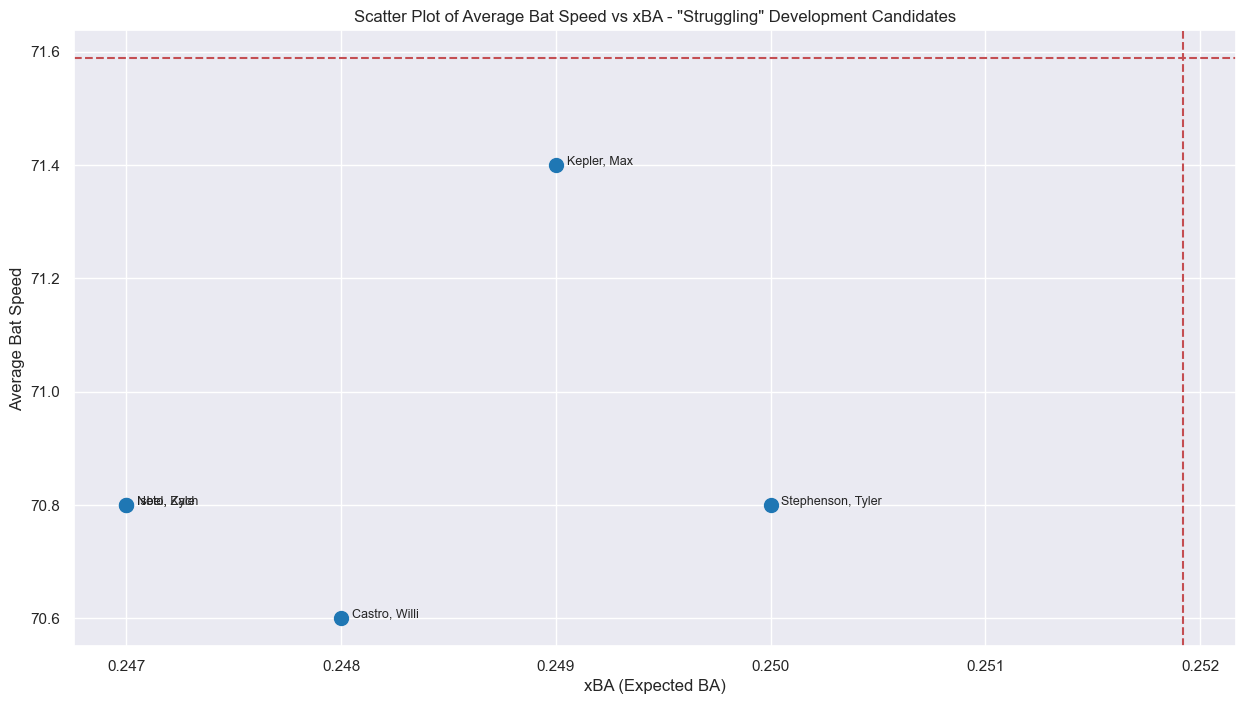

In [275]:
# Identify players who are within 1 mph of the bat speed average, 0.005 within the average xBA
Struggling = grouped[grouped['hit_class'] == "Struggling"]
Strug_filter = Struggling[Struggling['avg_swing_speed'] > 71.5883018867924 - 1]
Strug_Dev = Strug_filter[Strug_filter['xba'] >  0.25192075471698117 - 0.005]


# Apply color for struggling
colors = ['tab:blue']

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(Strug_Dev['xba'], Strug_Dev['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - "Struggling" Development Candidates')
plt.grid(True)

# Plot averages
plt.axhline(y=71.5883018867924, color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=0.25192075471698117, color='r', linestyle='--', label = '_nolegend_')

# Plot the name
for i, row in Strug_Dev.iterrows():
    plt.text(row['xba'] + 0.00005, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


In [276]:
# View Players Who Are Candidates For Development
Strug_Dev

last_name, first_name  player_id  year   pa  home_run  k_percent  \
46            Kepler, Max     596146  2024  362         8       20.4   
104         Castro, Willi     650489  2024  492        10       24.4   
135     Stephenson, Tyler     663886  2024  372        16       18.8   
143           Isbel, Kyle     664728  2024  319         7       18.5   
253            Neto, Zach     687263  2024  449        17       22.5   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
46          5.8        0.404            0.316             0.720  ...   
104         7.9        0.410            0.337             0.747  ...   
135         8.9        0.458            0.323             0.781  ...   
143         6.3        0.377            0.288             0.665  ...   
253         6.2        0.458            0.327             0.785  ...   

     linedrives_percent  player_age  side   woba  AgeGroup   hit_class  Team  \
46                 25.3          31     L  0.148     30-34  Struggling   MIN   
104                27.4          27     S  0.305     25-29  Struggling   MIN   
135                21.2          27     R  0.465     25-29  Struggling   CIN   
143                21.1          27     L  0.237     25-29  Struggling   KCR   
253                19.1          23     R  0.234     20-24  Struggling   LAA   

                 Name  Role   diff  
46         Max Kepler     6  0.160  
104      Willi Castro     1  0.015  
135  Tyler Stephenson     3 -0.134  
143        Kyle Isbel     9  0.055  
253         Zach Neto     2  0.095  

[5 rows x 41 columns]

Applying my initial criteria, I received **5 potential candidates** for development.

For purposes of this analysis, I only want to investigate **3 potential candidates** so I can do a full breakdown for them. As such, I'll need to drop-off 2 candidates from this shortlist.

To further narrow down my candidates, I'll cut out Max Kepler due to his age. While it's not impossible for Max Kepler to increase his bat speed at his age, the other 4 candidates (27 or below) have more potential to develop (arguably) in their careers.

To narrow down my shortlist to 3 candidates, I also decided to drop-off Kyle Isbel. There is no reason for his removal aside from him having the worst statistical metrics of the remaining candidates.

In [277]:
# Drop Max Kepler
Strug_Dev = Strug_Dev[Strug_Dev['player_id'] != 596146]
# Drop Kyle Isbel
Strug_Dev = Strug_Dev[Strug_Dev['player_id'] != 664728]


# Check the list of candidates
Strug_Dev

last_name, first_name  player_id  year   pa  home_run  k_percent  \
104         Castro, Willi     650489  2024  492        10       24.4   
135     Stephenson, Tyler     663886  2024  372        16       18.8   
253            Neto, Zach     687263  2024  449        17       22.5   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
104         7.9        0.410            0.337             0.747  ...   
135         8.9        0.458            0.323             0.781  ...   
253         6.2        0.458            0.327             0.785  ...   

     linedrives_percent  player_age  side   woba  AgeGroup   hit_class  Team  \
104                27.4          27     S  0.305     25-29  Struggling   MIN   
135                21.2          27     R  0.465     25-29  Struggling   CIN   
253                19.1          23     R  0.234     20-24  Struggling   LAA   

                 Name  Role   diff  
104      Willi Castro     1  0.015  
135  Tyler Stephenson     3 -0.134  
253         Zach Neto     2  0.095  

[3 rows x 41 columns]

### Development Candidate 1: Willi Castro


#### *Identify Similar Players To Willi Castro*

Let's begin by identifying players similar to Willi Castro


In [278]:
# Retrieve stats for Willi Castro
WilliCastro = grouped[grouped['player_id'] == 650489]
print(WilliCastro['player_age'])
print(WilliCastro['avg_swing_speed'])
print(WilliCastro['barrel_batted_rate'])
print(WilliCastro['flyballs_percent'])
print(WilliCastro['hard_hit_percent'])
print(WilliCastro['sweet_spot_percent'])
print(WilliCastro['avg_swing_length'])

104    27
Name: player_age, dtype: int64
104    70.6
Name: avg_swing_speed, dtype: float64
104    6.9
Name: barrel_batted_rate, dtype: float64
104    26.4
Name: flyballs_percent, dtype: float64
104    37.1
Name: hard_hit_percent, dtype: float64
104    38.4
Name: sweet_spot_percent, dtype: float64
104    7.1
Name: avg_swing_length, dtype: float64


In [279]:
# Create dataset of similar players
SimilarWC = grouped[
    (grouped['player_age'] >= 24) & (grouped['player_age'] <= 30) &
    (grouped['avg_swing_speed'] >= 67.6) & (grouped['avg_swing_speed'] <= 73.6) &
    (grouped['barrel_batted_rate'] >= 3.9) & (grouped['barrel_batted_rate'] <= 9.9) &
    (grouped['flyballs_percent'] >= 22.4) & (grouped['flyballs_percent'] <= 30.4) &
    (grouped['avg_swing_length'] >= 6.6) & (grouped['avg_swing_length'] <= 7.6) &
    (grouped['player_id'] != 650489) # exclude Willi castro from the group itself
]

SimilarWC

last_name, first_name  player_id  year   pa  home_run  k_percent  \
56          Bregman, Alex     608324  2024  509        19       13.0   
65         Taylor, Tyrone     621438  2024  264         6       22.0   
69         Margot, Manuel     622534  2024  281         4       15.7   
75      Cronenworth, Jake     630105  2024  500        15       18.2   
79         Crawford, J.P.     641487  2024  335         9       22.7   
82            Heim, Jonah     641680  2024  386        11       18.1   
97          Albies, Ozzie     645277  2024  394         8       15.5   
100         Toro, Abraham     647351  2024  356         6       16.9   
103       Torres, Gleyber     650402  2024  485        10       21.2   
111    Mullins II, Cedric     656775  2024  370        13       21.1   
112         O'Hearn, Ryan     656811  2024  374        12       12.6   
114          Thomas, Lane     657041  2024  395         8       23.5   
116          Wong, Connor     657136  2024  371        11       23.2   
118         Sheets, Gavin     657757  2024  392         8       21.4   
124        Perkins, Blake     663368  2024  318         6       25.2   
128       Larnach, Trevor     663616  2024  283        11       20.5   
132       India, Jonathan     663697  2024  473        11       21.1   
134        Vierling, Matt     663837  2024  428        14       21.7   
137       Lowe, Nathaniel     663993  2024  410        10       21.7   
139            France, Ty     664034  2024  388        11       23.2   
141       Bader, Harrison     664056  2024  349         8       21.2   
144            Bohm, Alec     664761  2024  514        13       13.8   
145     Wade Jr., LaMonte     664774  2024  283         4       22.6   
148          Peña, Jeremy     665161  2024  496        12       16.7   
152        Taveras, Leody     665750  2024  414         9       19.8   
158        Fermin, Freddy     666023  2024  265         6       17.0   
159       Hamilton, David     666152  2024  288         7       25.7   
166            Naylor, Bo     666310  2024  292         9       31.8   
169  Gurriel Jr., Lourdes     666971  2024  466        14       19.3   
171      Arozarena, Randy     668227  2024  487        16       24.8   
173        Steer, Spencer     668715  2024  497        18       20.5   
174       Reynolds, Bryan     668804  2024  525        19       22.7   
180        Marsh, Brandon     669016  2024  352        11       33.0   
182       Campusano, Luis     669134  2024  263         7       13.7   
183          Senzel, Nick     669222  2024  264         7       22.7   
184         Wells, Austin     669224  2024  292         9       19.9   
186        Suwinski, Jack     669261  2024  277         9       28.5   
188         Miranda, Jose     669304  2024  335         9       14.3   
199          García, Luis     671277  2024  412        14       15.8   
203       Bailey, Patrick     672275  2024  358         7       21.2   
205       Kelenic, Jarred     672284  2024  389        13       29.8   
210        Pérez, Wenceel     672761  2024  378         9       20.1   
213         Kim, Ha-Seong     673490  2024  464        11       16.6   
217        Burleson, Alec     676475  2024  443        20       13.1   
218       Caballero, José     676609  2024  365         8       27.9   
219          Meyers, Jake     676694  2024  390        12       23.6   
232         Jeffers, Ryan     680777  2024  363        18       20.4   
233           Gelof, Zack     680869  2024  392        15       34.9   
249   Pasquantino, Vinnie     686469  2024  495        18       13.1   
251            Lee, Korey     686676  2024  304        10       30.9   
252         Brennan, Will     686823  2024  272         8       12.9   
258        Gonzales, Nick     693304  2024  267         5       21.3   
264     Yoshida, Masataka     807799  2024  295         8       13.6   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
56          7.1        0.445            0.3

With our player list narrowed down, we can proceed with our predictive modelling.

#### *Multiple Linear Regression Model (RMSE for xBA = 0.0201, xWOBA = 0.0198)*

In [280]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']
Y_xWOBA = SimilarWC['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))


Cross-validation RMSE for xBA =  0.020148934190072767
Cross-validation RMSE for xWOBA =  0.019838538481495693


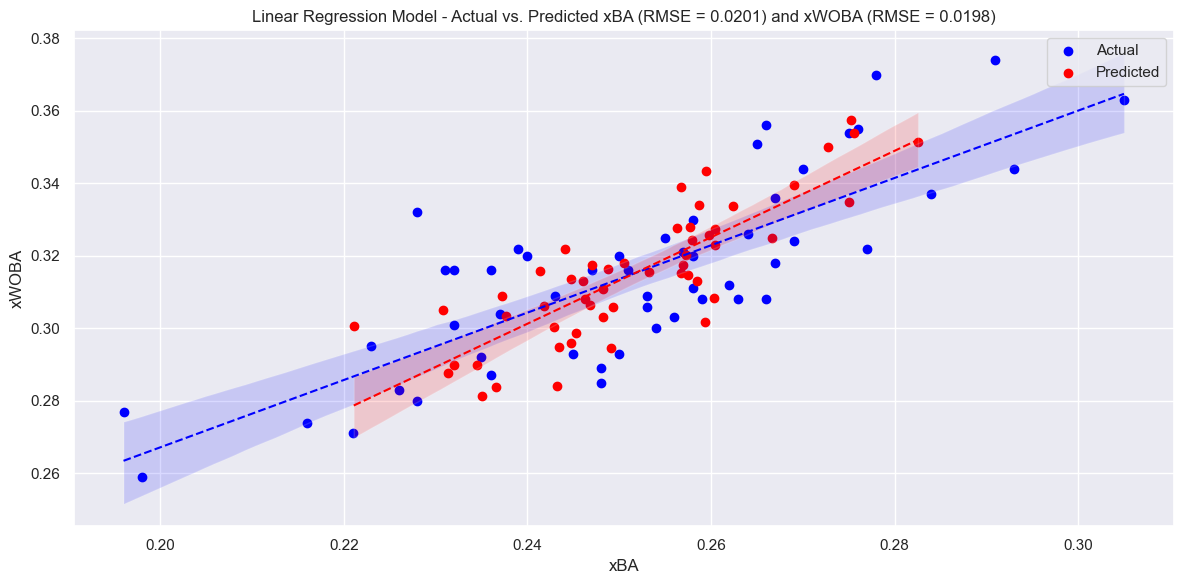

In [281]:
# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarWC['xba'], SimilarWC['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarWC['xba'], y=SimilarWC['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Linear Regression Model - Actual vs. Predicted xBA (RMSE = 0.0201) and xWOBA (RMSE = 0.0198)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *XGBoost Model (Parameter-tuned) (RMSE for xBA = 0.0198, xWOBA = 0.0211)*

In [282]:
!pip install xgboost

In [283]:
import xgboost as xgb

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']
Y_xWOBA = SimilarWC['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.024269386066231146
Cross-validation RMSE for xWOBA =  0.023796490721853015


Let's see if I can improve our accuracies by tuning the parameters

In [284]:
### Parameter Tuning for the xBA model ####

# Import GridSearchCV method form sklearn library
from sklearn.model_selection import GridSearchCV

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [30, 40, 50],
    'max_depth': [6, 7, 10],
    'colsample_bytree': [0.05, 0.1, 0.12],
    'min_child_weight': [0.03, 0.04, 0.05],
    'learning_rate': [0.07, 0.08, 0.09]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.05, 'learning_rate': 0.08, 'max_depth': 6, 'min_child_weight': 0.03, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.01958503544158329


Best Parameters for predicting xBA: 'colsample_bytree': 0.05, 'learning_rate': 0.08, 'max_depth': 6, 'min_child_weight': 0.03, 'n_estimators': 50

In [285]:
### Parameter Tuning for the xWOBA model ####

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xWOBA = SimilarWC['xwoba']

# Initialize the XGB Regressor
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xWOBA.fit(X, Y_xWOBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [30, 35, 38],
    'max_depth': [1, 2, 3],
    'colsample_bytree': [0.003, 0.004, 0.005],
    'min_child_weight': [0.015, 0.020, 0.025],
    'learning_rate': [0.15, 0.20, 0.30]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.003, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 0.015, 'n_estimators': 35}
Best Cross-validation RMSE with Best Parameters: -0.02080529632309186


Best Parameters for predicting xWOBA: 'colsample_bytree': 0.003, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 0.015, 'n_estimators': 35

Let's now apply these parameters to our XGBoost models

In [286]:
# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']
Y_xWOBA = SimilarWC['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.05, learning_rate = 0.08, max_depth = 6, min_child_weight = 0.03, n_estimators = 50)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.003, learning_rate = 0.2, max_depth = 1, min_child_weight = 0.015, n_estimators = 35)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.01981430994479606
Cross-validation RMSE for xWOBA =  0.02106549170042564


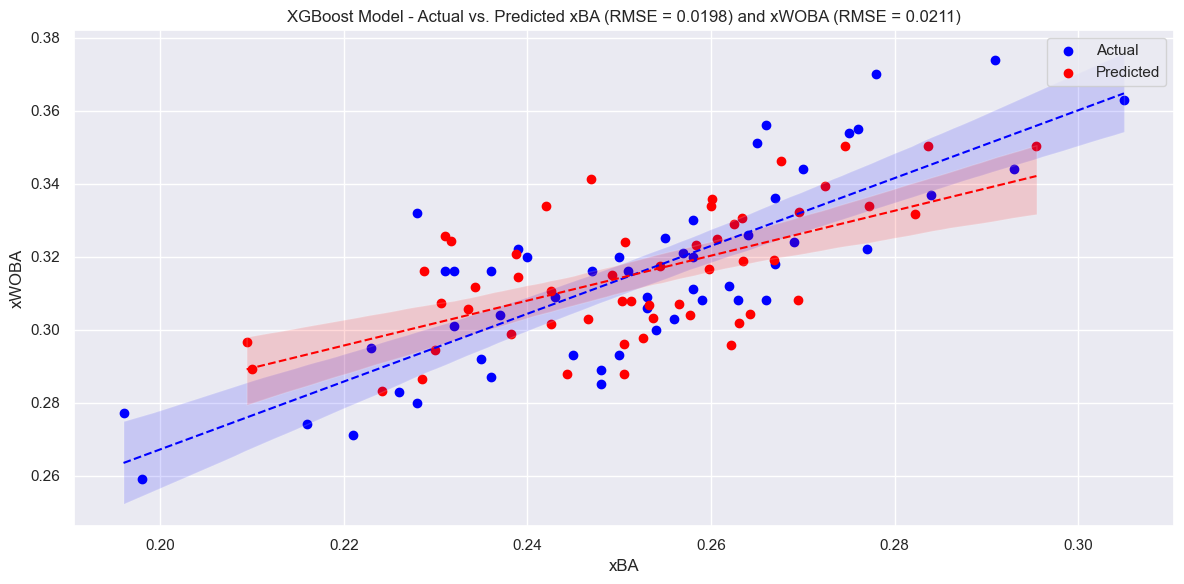

In [287]:
# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.05, learning_rate = 0.08, max_depth = 6, min_child_weight = 0.03, n_estimators = 50)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.003, learning_rate = 0.2, max_depth = 1, min_child_weight = 0.015, n_estimators = 35)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarWC['xba'], SimilarWC['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarWC['xba'], y=SimilarWC['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('XGBoost Model - Actual vs. Predicted xBA (RMSE = 0.0198) and xWOBA (RMSE = 0.0211)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


##### *Random Forest Regressor (RMSE for xBA = 0.0208, xWOBA = 0.0211)*

In [288]:
from sklearn.ensemble import RandomForestRegressor

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']
Y_xWOBA = SimilarWC['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth=3)
rf_model_xWOBA = RandomForestRegressor(max_depth=3)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.020904255917254685
Cross-validation RMSE for xWOBA =  0.022068504374407376


Let's see if I can improve the models' accuracies with parameter tuning

In [289]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xBA = SimilarWC['xba']
# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor()
# Fit the models
rf_model_xBA.fit(X, Y_xBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [40, 50, 70],
    'max_depth': [40, 50, 60],
    'max_features': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 50, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.0003925407744205197


The best parameters for predicting xBA: 'max_depth': 60, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40

In [290]:
## PARAMETER TUNING FOR xWOBA ##

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xWOBA = SimilarWC['xwoba']
# Initialize the Random Forest Regressor
rf_model_xWOBA = RandomForestRegressor()
# Fit the models
rf_model_xWOBA.fit(X, Y_xWOBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [40, 50, 60],
    'max_depth': [40, 50, 60],
    'max_features': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.00040209831120563406


The best parameters for predicting xWOBA: 'max_depth': 60, 'max_features': 1, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 60

Let's apply these new parameters:

In [291]:
# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']
Y_xWOBA = SimilarWC['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 60, max_features = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 40)
rf_model_xWOBA = RandomForestRegressor(max_depth = 60, max_features = 1, min_samples_leaf = 3, min_samples_split = 2, n_estimators = 60)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.020860276789325505
Cross-validation RMSE for xWOBA =  0.020621293155983732


After parameter tuning, I got an RMSE of 0.0213 for xBA, and 0.0224 for xWOBA

**NOTE:** Due to the nature of random forest models the printed output may not be the same as the numbers I list

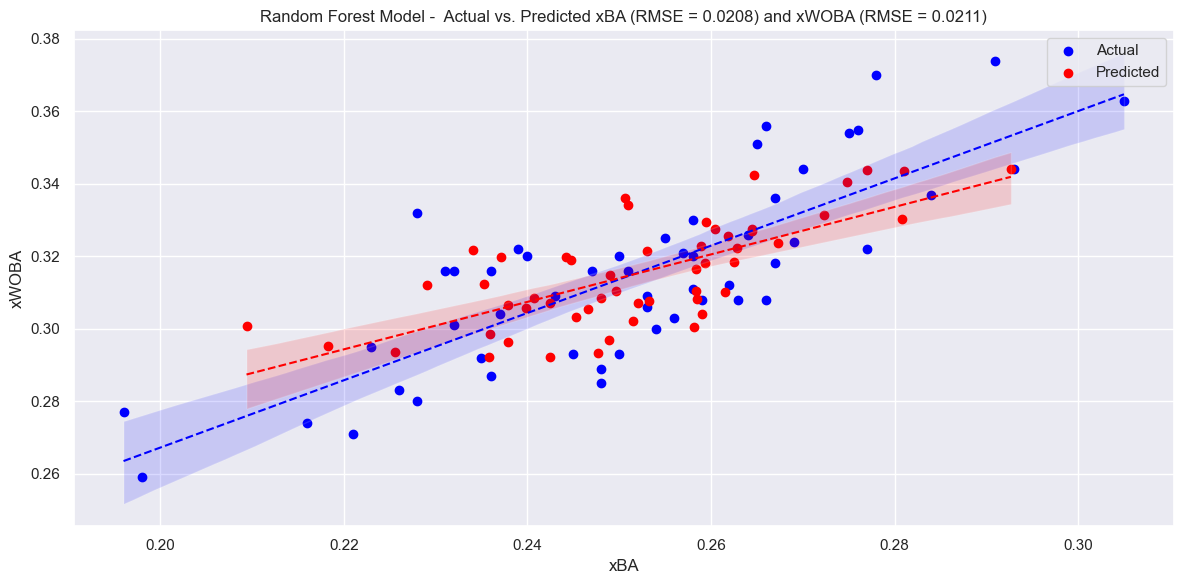

In [292]:
# Predicted values
predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarWC['xba'], SimilarWC['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_rf_xBA, predicted_rf_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarWC['xba'], y=SimilarWC['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_rf_xBA, y=predicted_rf_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Random Forest Model -  Actual vs. Predicted xBA (RMSE = 0.0208) and xWOBA (RMSE = 0.0211)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

##### *Summary of Predictive Models:*

![Willi Castro Pred Models](images/Willi%20Castro%20Pred%20Model.png)

#### *Final Results for Willi Castro*

In [293]:
## Reload Linear Regression Model ###

# Define features
X = SimilarWC[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarWC['xba']
Y_xWOBA = SimilarWC['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

In [294]:
# Define the Willi Castro's bat speed and the range of intervals
WC_bat_speed = 70.6
end_bat_speed = WC_bat_speed + 3.2
bat_speeds = np.arange(WC_bat_speed, end_bat_speed, 0.5) 

# Set Willi Castro's predictors
player_predictors = {
    'barrel_batted_rate': 6.9,
    'hard_hit_percent': 37.1,
    'sweet_spot_percent': 38.4,
    'flyballs_percent': 26.4
}

# Empty lists to store predictions
predicted_xBA_list = []
predicted_xWOBA_list = []

# Iterate over the range of bat speeds (70.6 mph - 73.6 mph)
for bat_speed in bat_speeds:
    # Create a data frame with the player's predictors and the current bat speed
    input_data = pd.DataFrame({
        'barrel_batted_rate': [player_predictors['barrel_batted_rate']],
        'hard_hit_percent': [player_predictors['hard_hit_percent']],
        'avg_swing_speed': [bat_speed],
        'sweet_spot_percent': [player_predictors['sweet_spot_percent']],
        'flyballs_percent': [player_predictors['flyballs_percent']]
    })
    
    # Predict xBA and xWOBA for each bat speed
    predicted_xBA = model_xBA.predict(input_data)
    predicted_xWOBA = model_xWOBA.predict(input_data)
    
    # Store prediction
    predicted_xBA_list.append(predicted_xBA[0]) 
    predicted_xWOBA_list.append(predicted_xWOBA[0])

# Convert the lists to arrays for further analysis or plotting
predicted_xBA_array = np.array(predicted_xBA_list)
predicted_xWOBA_array = np.array(predicted_xWOBA_list)

# Output
for i, bat_speed in enumerate(bat_speeds):
    print(f"Bat Speed: {bat_speed:.2f} mph -> Predicted xBA: {predicted_xBA_array[i]:.4f}, Predicted xWOBA: {predicted_xWOBA_array[i]:.4f}")


Bat Speed: 70.60 mph -> Predicted xBA: 0.2570, Predicted xWOBA: 0.3221
Bat Speed: 71.10 mph -> Predicted xBA: 0.2561, Predicted xWOBA: 0.3230
Bat Speed: 71.60 mph -> Predicted xBA: 0.2551, Predicted xWOBA: 0.3239
Bat Speed: 72.10 mph -> Predicted xBA: 0.2542, Predicted xWOBA: 0.3248
Bat Speed: 72.60 mph -> Predicted xBA: 0.2532, Predicted xWOBA: 0.3257
Bat Speed: 73.10 mph -> Predicted xBA: 0.2523, Predicted xWOBA: 0.3266
Bat Speed: 73.60 mph -> Predicted xBA: 0.2513, Predicted xWOBA: 0.3275


Below is a summary of the results:

![Willi Castro Pred Results Table](images/Willi%20Castro%20Pred%20Results%20Table.png)

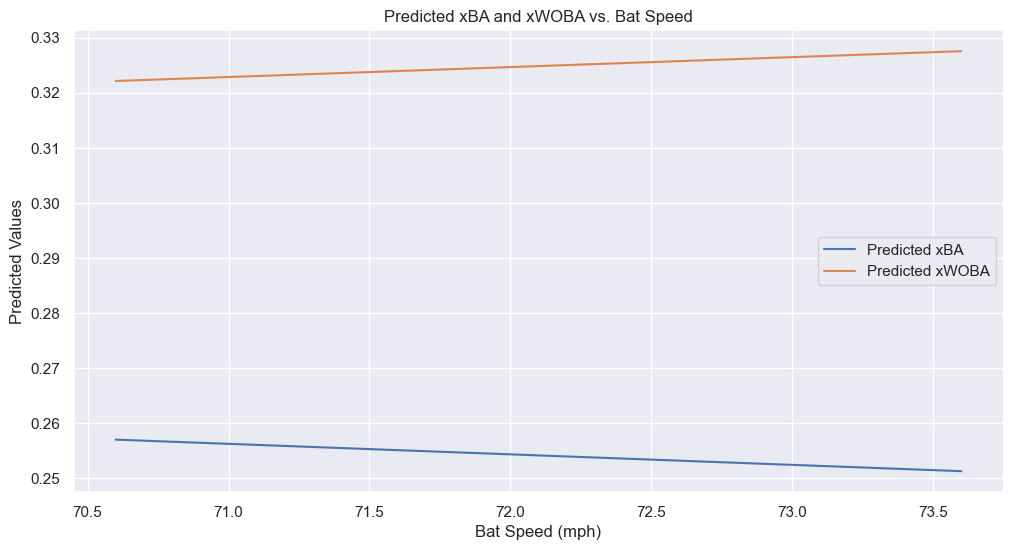

In [295]:
# Plot predicted values
plt.figure(figsize=(12, 6))
plt.plot(bat_speeds, predicted_xBA_array, label='Predicted xBA')
plt.plot(bat_speeds, predicted_xWOBA_array, label='Predicted xWOBA')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Predicted Values')
plt.title('Predicted xBA and xWOBA vs. Bat Speed')
plt.legend()
plt.grid(True)
plt.show()

### Development Candidate 2: Tyler Stephenson

#### *Identify Similar Players To Tyler Stephenson*

Let's begin by identifying players similar to Tyler Stephenson

In [296]:
# Retrieve stats for Willi Castro
TylerSteph = grouped[grouped['player_id'] == 663886]
print(TylerSteph['player_age'])
print(TylerSteph['avg_swing_speed'])
print(TylerSteph['barrel_batted_rate'])
print(TylerSteph['flyballs_percent'])
print(TylerSteph['hard_hit_percent'])
print(TylerSteph['sweet_spot_percent'])
print(TylerSteph['avg_swing_length'])

135    27
Name: player_age, dtype: int64
135    70.8
Name: avg_swing_speed, dtype: float64
135    10.2
Name: barrel_batted_rate, dtype: float64
135    29.9
Name: flyballs_percent, dtype: float64
135    44.3
Name: hard_hit_percent, dtype: float64
135    33.3
Name: sweet_spot_percent, dtype: float64
135    7.4
Name: avg_swing_length, dtype: float64


In [297]:
# Create dataset of similar players
SimilarTS = grouped[
    (grouped['player_age'] >= 24) & (grouped['player_age'] <= 30) &
    (grouped['avg_swing_speed'] >= 67.8) & (grouped['avg_swing_speed'] <= 73.8) &
    (grouped['barrel_batted_rate'] >= 7.2) & (grouped['barrel_batted_rate'] <= 13.2) &
    (grouped['flyballs_percent'] >= 25.9) & (grouped['flyballs_percent'] <= 34.9) &
    (grouped['avg_swing_length'] >= 6.9) & (grouped['avg_swing_length'] <= 7.9) &
    (grouped['player_id'] != 663886) # exclude Tyler Stephenson from the group itself
]

SimilarTS

last_name, first_name  player_id  year   pa  home_run  k_percent  \
40         Polanco, Jorge     593871  2024  331        12       30.5   
45      Lindor, Francisco     596019  2024  558        23       18.1   
47     Candelario, Jeimer     600869  2024  451        19       24.4   
68            Olson, Matt     621566  2024  514        21       27.4   
70     Santander, Anthony     623993  2024  506        36       19.4   
75      Cronenworth, Jake     630105  2024  500        15       18.2   
79         Crawford, J.P.     641487  2024  335         9       22.7   
85         Smith, Dominic     642086  2024  278         6       23.4   
93          Jansen, Danny     643376  2024  256         8       18.0   
106     De La Cruz, Bryan     650559  2024  505        18       27.1   
112         O'Hearn, Ryan     656811  2024  374        12       12.6   
117          DeJong, Paul     657557  2024  397        20       30.7   
128       Larnach, Trevor     663616  2024  283        11       20.5   
138             Happ, Ian     664023  2024  486        21       27.0   
139            France, Ty     664034  2024  388        11       23.2   
156    Chisholm Jr., Jazz     665862  2024  491        20       25.1   
161        Moniak, Mickey     666160  2024  326         8       26.1   
164          Benson, Will     666181  2024  331        12       39.6   
166            Naylor, Bo     666310  2024  292         9       31.8   
171      Arozarena, Randy     668227  2024  487        16       24.8   
172            Bleday, JJ     668709  2024  483        15       18.0   
174       Reynolds, Bryan     668804  2024  525        19       22.7   
179      Melendez Jr., MJ     669004  2024  342        14       24.6   
180        Marsh, Brandon     669016  2024  352        11       33.0   
184         Wells, Austin     669224  2024  292         9       19.9   
205       Kelenic, Jarred     672284  2024  389        13       29.8   
217        Burleson, Alec     676475  2024  443        20       13.1   
219          Meyers, Jake     676694  2024  390        12       23.6   
232         Jeffers, Ryan     680777  2024  363        18       20.4   
233           Gelof, Zack     680869  2024  392        15       34.9   
237        O'Hoppe, Logan     681351  2024  405        17       26.9   
246        Vaughn, Andrew     683734  2024  465        14       21.9   
247        Busch, Michael     683737  2024  428        16       30.8   
249   Pasquantino, Vinnie     686469  2024  495        18       13.1   
250        Doyle, Brenton     686668  2024  480        20       26.7   
258        Gonzales, Nick     693304  2024  267         5       21.3   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
40         10.3        0.362            0.302             0.664  ...   
45          8.1        0.465            0.335             0.800  ...   
47          6.0        0.425            0.277             0.702  ...   
68          9.3        0.427            0.313             0.740  ...   
70          7.9        0.532            0.310             0.842  ...   
75          8.0        0.410            0.321             0.731  ...   
79         11.3        0.347            0.299             0.646  ...   
85          9.0        0.390            0.317             0.707  ...   
93         11.3        0.392            0.316             0.708  ...   
106         5.1        0.395            0.282             0.677  ...   
112        10.4        0.452            0.356             0.808  ...   
117         4.5        0.440            0.285             0.725  ...   
128         9.5        0.413            0.318             0.731  ...   
138        13.0        0.452            0.340             0.792  ...   
139         7.5        0.370            0.307             0.677  ...   
156         8.8        0.445            0.328             0.773  ...   
161         4.9        0.360            0.264             0.624  ...   
164        10.0        0.389            0.2

With our player list narrowed down, we can proceed with our predictive modelling

#### *Multiple Linear Regression Model (RMSE for xBA = 0.0234, xWOBA = 0.0250)*

In [298]:
# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']
Y_xWOBA = SimilarTS['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))


Cross-validation RMSE for xBA =  0.02343010587055037
Cross-validation RMSE for xWOBA =  0.02504974053646098


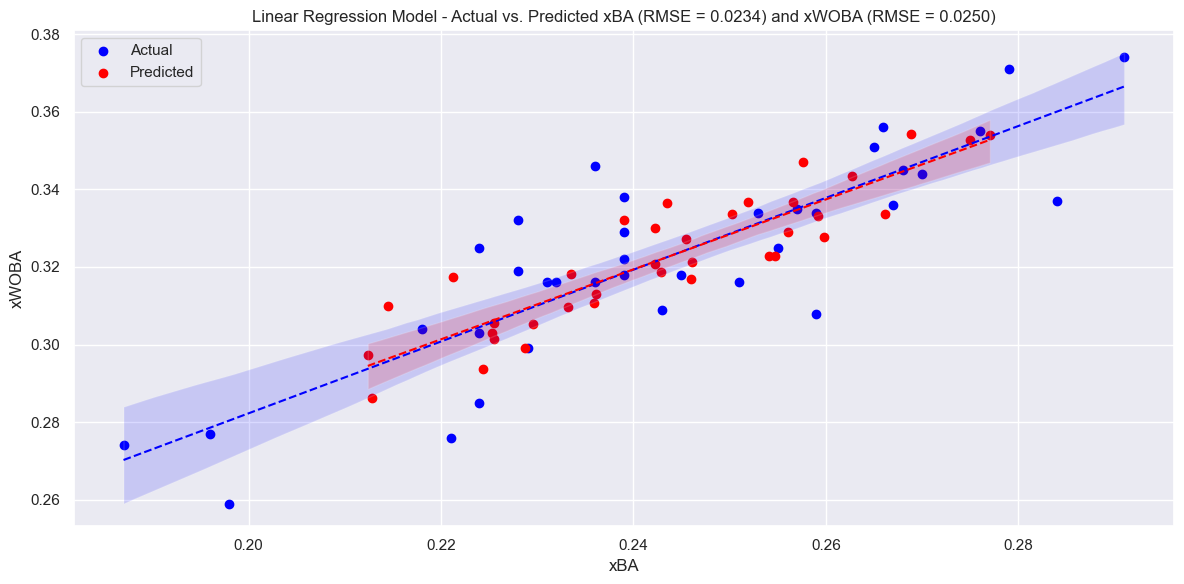

In [299]:
# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarTS['xba'], SimilarTS['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarTS['xba'], y=SimilarTS['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Linear Regression Model - Actual vs. Predicted xBA (RMSE = 0.0234) and xWOBA (RMSE = 0.0250)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()

#### *XGBoost Model (Parameter-tuned) (RMSE for xBA = 0.0241, xWOBA = 0.0226)*

In [300]:
# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']
Y_xWOBA = SimilarTS['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.0266403906090435
Cross-validation RMSE for xWOBA =  0.02767491280805619


Let's see if we can optimize these scores with some parameter tuning

In [301]:
### Parameter Tuning for the xBA model ####

# Import GridSearchCV method form sklearn library
from sklearn.model_selection import GridSearchCV

# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [10, 15, 20],
    'colsample_bytree': [0.025, 0.04, 0.05],
    'min_child_weight': [0.05, 0.06, 0.08],
    'learning_rate': [0.05, 0.06, 0.07]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.025, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 0.05, 'n_estimators': 30}
Best Cross-validation RMSE with Best Parameters: -0.02310075309907948


Best Parameters for predicting xBA: 'colsample_bytree': 0.025, 'learning_rate': 0.05, 'max_depth': 10, 'min_child_weight': 0.05, 'n_estimators': 30

In [302]:
### Parameter Tuning for the xWOBA model ####

# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xWOBA = SimilarTS['xwoba']

# Initialize the XGB Regressor
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xWOBA.fit(X, Y_xWOBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [10, 25, 30],
    'max_depth': [1, 2, 3],
    'colsample_bytree': [0.001, 0.002, 0.003],
    'min_child_weight': [0.015, 0.020, 0.025],
    'learning_rate': [0.3, 0.4, 0.6]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.001, 'learning_rate': 0.6, 'max_depth': 1, 'min_child_weight': 0.015, 'n_estimators': 30}
Best Cross-validation RMSE with Best Parameters: -0.021569476663022995


Best Parameters for predicting xWOBA: 'colsample_bytree': 0.001, 'learning_rate': 0.6, 'max_depth': 1, 'min_child_weight': 0.015, 'n_estimators': 30

Let's apply these new parameters:

In [303]:
# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']
Y_xWOBA = SimilarTS['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.025, learning_rate = 0.05, max_depth = 10, min_child_weight = 0.05, n_estimators = 30)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.001, learning_rate = 0.6, max_depth = 1, min_child_weight = 0.015, n_estimators = 30)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.02413600801640573
Cross-validation RMSE for xWOBA =  0.022611689967382928


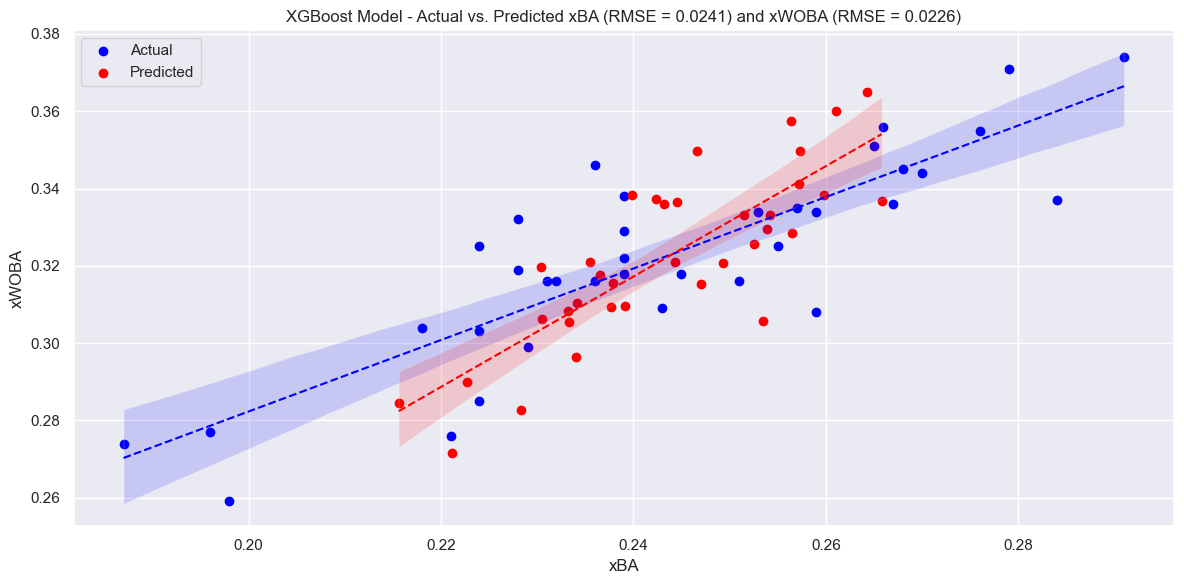

In [304]:
# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.025, learning_rate = 0.05, max_depth = 10, min_child_weight = 0.05, n_estimators = 30)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.001, learning_rate = 0.6, max_depth = 1, min_child_weight = 0.015, n_estimators = 30)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarTS['xba'], SimilarTS['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarTS['xba'], y=SimilarTS['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('XGBoost Model - Actual vs. Predicted xBA (RMSE = 0.0241) and xWOBA (RMSE = 0.0226)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *Random Forest Regressor (RMSE for xBA = 0.0220 , xWOBA = 0.0248)*

In [305]:
# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']
Y_xWOBA = SimilarTS['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth=3)
rf_model_xWOBA = RandomForestRegressor(max_depth=3)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.023568234824665895
Cross-validation RMSE for xWOBA =  0.026010781617507188


Let's see if I can tune these parameters to improve the model's accuracy

In [306]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xBA = SimilarTS['xba']
# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor()
# Fit the models
rf_model_xBA.fit(X, Y_xBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [40, 50, 70],
    'max_depth': [45, 50, 55],
    'max_features': [1, 2, 3],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 45, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 70}
Best Cross-validation RMSE with Best Parameters: -0.0004278299883054006


The best parameters for predicting xBA: 'max_depth': 45, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 40

In [307]:
## PARAMETER TUNING FOR xWOBA ##

# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xWOBA = SimilarTS['xwoba']
# Initialize the Random Forest Regressor
rf_model_xWOBA = RandomForestRegressor()
# Fit the models
rf_model_xWOBA.fit(X, Y_xWOBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [45, 50, 55],
    'max_depth': [45, 50, 55],
    'max_features': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 45}
Best Cross-validation RMSE with Best Parameters: -0.0005134816812652519


The best parameters for predicting xBA: 'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50

Let's apply these new parameters:

In [308]:
# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']
Y_xWOBA = SimilarTS['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 45, max_features = 2, min_samples_leaf = 3, min_samples_split = 3, n_estimators = 40)
rf_model_xWOBA = RandomForestRegressor(max_depth = 50, max_features = 1, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 50)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.021951967683027353
Cross-validation RMSE for xWOBA =  0.023766056020445864


After parameter tuning, I got an RMSE of 0.0220 for xBA, and 0.0248 for xWOBA

**NOTE:** Due to the nature of random forest models the printed output may not be the same as the numbers I list

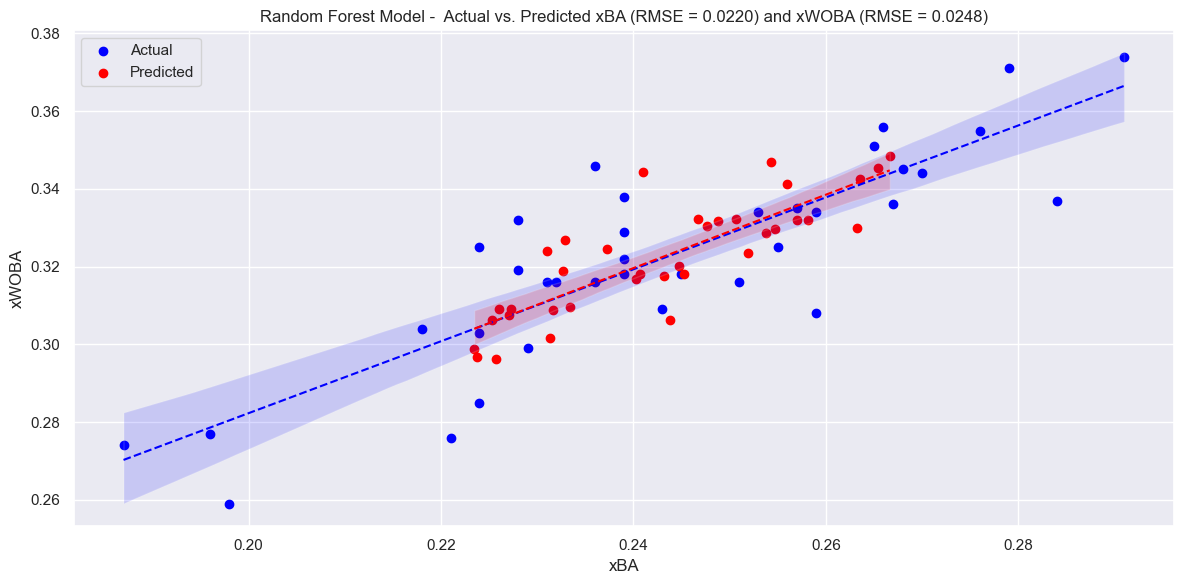

In [309]:
# Predicted values
predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarTS['xba'], SimilarTS['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_rf_xBA, predicted_rf_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarTS['xba'], y=SimilarTS['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_rf_xBA, y=predicted_rf_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Random Forest Model -  Actual vs. Predicted xBA (RMSE = 0.0220) and xWOBA (RMSE = 0.0248)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### *Summary of Predictive Models*

![Tyler Steph Pred Model Table](images/Tyler%20Steph%20Pred%20Model%20Table.png)

#### *Final Results for Tyler Stephenson*

In [310]:
# Reload Random Forest Model
# Define features
X = SimilarTS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarTS['xba']
Y_xWOBA = SimilarTS['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 45, max_features = 2, min_samples_leaf = 3, min_samples_split = 3, n_estimators = 40)
rf_model_xWOBA = RandomForestRegressor(max_depth = 50, max_features = 1, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 50)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

In [311]:
# Define the Tyler Stephenson's bat speed and the range of intervals
TS_bat_speed = 70.8
end_bat_speed = TS_bat_speed + 3.2
bat_speeds = np.arange(TS_bat_speed, end_bat_speed, 0.5) 

# Set Tyler Stephenson's predictors
player_predictors = {
    'barrel_batted_rate': 10.2,
    'hard_hit_percent': 44.3,
    'sweet_spot_percent': 33.3,
    'flyballs_percent': 29.9
}

# Empty lists to store predictions
predicted_xBA_list = []
predicted_xWOBA_list = []

# Iterate over the range of bat speeds (70.8 mph - 73.8 mph)
for bat_speed in bat_speeds:
    # Create a data frame with the player's predictors and the current bat speed
    input_data = pd.DataFrame({
        'barrel_batted_rate': [player_predictors['barrel_batted_rate']],
        'hard_hit_percent': [player_predictors['hard_hit_percent']],
        'avg_swing_speed': [bat_speed],
        'sweet_spot_percent': [player_predictors['sweet_spot_percent']],
        'flyballs_percent': [player_predictors['flyballs_percent']]
    })
    
    # Predicted values
    predicted_rf_xBA = rf_model_xBA.predict(input_data)
    predicted_rf_xWOBA = rf_model_xWOBA.predict(input_data)
    
    # Store prediction
    predicted_xBA_list.append(predicted_rf_xBA[0]) 
    predicted_xWOBA_list.append(predicted_rf_xWOBA[0])

# Convert the lists to arrays for further analysis or plotting
predicted_xBA_array = np.array(predicted_xBA_list)
predicted_xWOBA_array = np.array(predicted_xWOBA_list)

# Output
for i, bat_speed in enumerate(bat_speeds):
    print(f"Bat Speed: {bat_speed:.2f} mph -> Predicted xBA: {predicted_xBA_array[i]:.4f}, Predicted xWOBA: {predicted_xWOBA_array[i]:.4f}")

Bat Speed: 70.80 mph -> Predicted xBA: 0.2524, Predicted xWOBA: 0.3274
Bat Speed: 71.30 mph -> Predicted xBA: 0.2530, Predicted xWOBA: 0.3287
Bat Speed: 71.80 mph -> Predicted xBA: 0.2500, Predicted xWOBA: 0.3280
Bat Speed: 72.30 mph -> Predicted xBA: 0.2517, Predicted xWOBA: 0.3304
Bat Speed: 72.80 mph -> Predicted xBA: 0.2494, Predicted xWOBA: 0.3287
Bat Speed: 73.30 mph -> Predicted xBA: 0.2494, Predicted xWOBA: 0.3270
Bat Speed: 73.80 mph -> Predicted xBA: 0.2494, Predicted xWOBA: 0.3270


Below is a summary of the results:

![Tyler Stephenson Result Table](images/Tyler%20Stephenson%20Result%20Table.png)

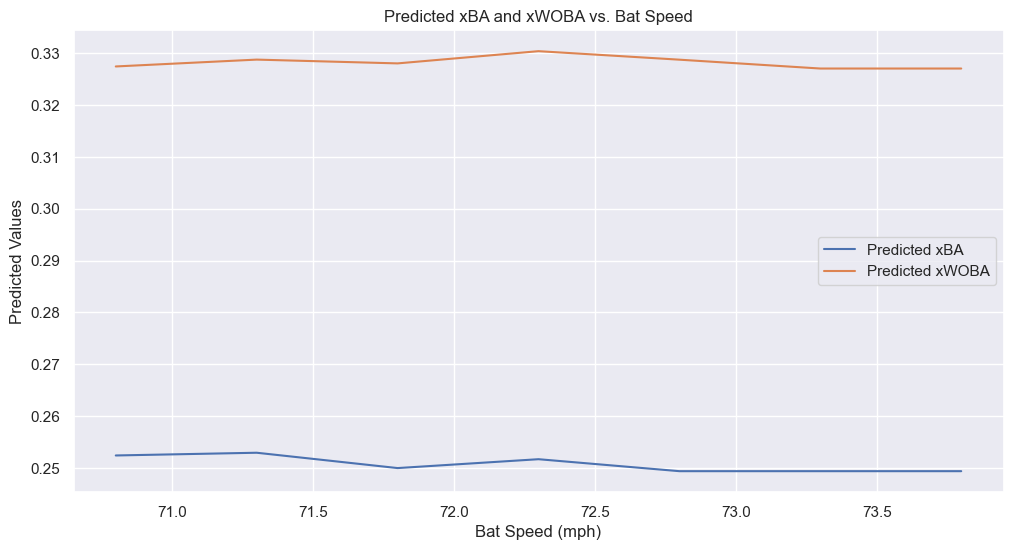

In [312]:
# Plot predicted values
plt.figure(figsize=(12, 6))
plt.plot(bat_speeds, predicted_xBA_array, label='Predicted xBA')
plt.plot(bat_speeds, predicted_xWOBA_array, label='Predicted xWOBA')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Predicted Values')
plt.title('Predicted xBA and xWOBA vs. Bat Speed')
plt.legend()
plt.grid(True)
plt.show()

### Development Candidate 3: Zach Neto

#### *Identify Similar Players To Zach Neto*

Let's begin by identifying players similar to Zach Neto

In [313]:
# Retrieve stats for Zach Neto
ZachNeto = grouped[grouped['player_id'] == 687263]
print(ZachNeto['player_age'])
print(ZachNeto['avg_swing_speed'])
print(ZachNeto['barrel_batted_rate'])
print(ZachNeto['flyballs_percent'])
print(ZachNeto['hard_hit_percent'])
print(ZachNeto['sweet_spot_percent'])
print(ZachNeto['avg_swing_length'])

253    23
Name: player_age, dtype: int64
253    70.8
Name: avg_swing_speed, dtype: float64
253    8.7
Name: barrel_batted_rate, dtype: float64
253    28.2
Name: flyballs_percent, dtype: float64
253    38.5
Name: hard_hit_percent, dtype: float64
253    30.1
Name: sweet_spot_percent, dtype: float64
253    7.2
Name: avg_swing_length, dtype: float64


In [314]:
# Create dataset of similar players
SimilarZN = grouped[
    (grouped['player_age'] >= 20) & (grouped['player_age'] <= 26) &
    (grouped['avg_swing_speed'] >= 67.8) & (grouped['avg_swing_speed'] <= 73.8) &
    (grouped['barrel_batted_rate'] >= 5.7) & (grouped['barrel_batted_rate'] <= 11.7) &
    (grouped['flyballs_percent'] >= 24.2) & (grouped['flyballs_percent'] <= 32.2) &
    (grouped['avg_swing_length'] >= 6.7) & (grouped['avg_swing_length'] <= 7.7) &
    (grouped['player_id'] != 687263) # exclude Zach Neto from the group itself
]

SimilarZN

last_name, first_name  player_id  year   pa  home_run  k_percent  \
152        Taveras, Leody     665750  2024  414         9       19.8   
156    Chisholm Jr., Jazz     665862  2024  491        20       25.1   
161        Moniak, Mickey     666160  2024  326         8       26.1   
166            Naylor, Bo     666310  2024  292         9       31.8   
172            Bleday, JJ     668709  2024  483        15       18.0   
173        Steer, Spencer     668715  2024  497        18       20.5   
179      Melendez Jr., MJ     669004  2024  342        14       24.6   
180        Marsh, Brandon     669016  2024  352        11       33.0   
184         Wells, Austin     669224  2024  292         9       19.9   
188         Miranda, Jose     669304  2024  335         9       14.3   
199          García, Luis     671277  2024  412        14       15.8   
205       Kelenic, Jarred     672284  2024  389        13       29.8   
217        Burleson, Alec     676475  2024  443        20       13.1   
225       Tovar, Ezequiel     678662  2024  533        19       28.5   
226     Rafaela, Ceddanne     678882  2024  453        13       24.5   
233           Gelof, Zack     680869  2024  392        15       34.9   
237        O'Hoppe, Logan     681351  2024  405        17       26.9   
238           Pages, Andy     681624  2024  391         9       25.1   
241            Abrams, CJ     682928  2024  501        17       20.4   
246        Vaughn, Andrew     683734  2024  465        14       21.9   
249   Pasquantino, Vinnie     686469  2024  495        18       13.1   
250        Doyle, Brenton     686668  2024  480        20       26.7   
252         Brennan, Will     686823  2024  272         8       12.9   
255           Keith, Colt     690993  2024  417        11       17.7   
257  Crow-Armstrong, Pete     691718  2024  258         5       22.5   
258        Gonzales, Nick     693304  2024  267         5       21.3   
263      Merrill, Jackson     701538  2024  450        17       18.2   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
152         8.0        0.358            0.292             0.650  ...   
156         8.8        0.445            0.328             0.773  ...   
161         4.9        0.360            0.264             0.624  ...   
166         7.5        0.353            0.261             0.614  ...   
172        10.6        0.449            0.330             0.779  ...   
173        10.7        0.427            0.324             0.751  ...   
179         7.0        0.406            0.264             0.670  ...   
180        10.2        0.399            0.318             0.717  ...   
184        12.0        0.426            0.347             0.773  ...   
188         4.8        0.492            0.349             0.841  ...   
199         5.1        0.459            0.328             0.787  ...   
205         6.9        0.405            0.291             0.696  ...   
217         4.3        0.455            0.307             0.762  ...   
225         3.0        0.459            0.296             0.755  ...   
226         3.3        0.410            0.295             0.705  ...   
233         7.7        0.367            0.267             0.634  ...   
237         5.9        0.434            0.314             0.748  ...   
238         6.6        0.392            0.307             0.699  ...   
241         7.0        0.445            0.322             0.767  ...   
246         6.5        0.403            0.297             0.700  ...   
249         7.3        0.450            0.314             0.764  ...   
250         7.5        0.465            0.324             0.789  ...   
252         5.9        0.397            0.305             0.702  ...   
255         6.7        0.378            0.302             0.680  ...   
257         4.3        0.357            0.253             0.610  ...   
258         4.1        0.387            0.293             0.680  ...   
263         4.7        0.486            0.3

With our player list narrowed down, we can proceed with our predictive modelling.

#### *Multiple Linear Regression Model (RMSE for xBA = 0.0268, xWOBA = 0.0254)*

In [315]:
# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']
Y_xWOBA = SimilarZN['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.026792590899442147
Cross-validation RMSE for xWOBA =  0.025445401300973242


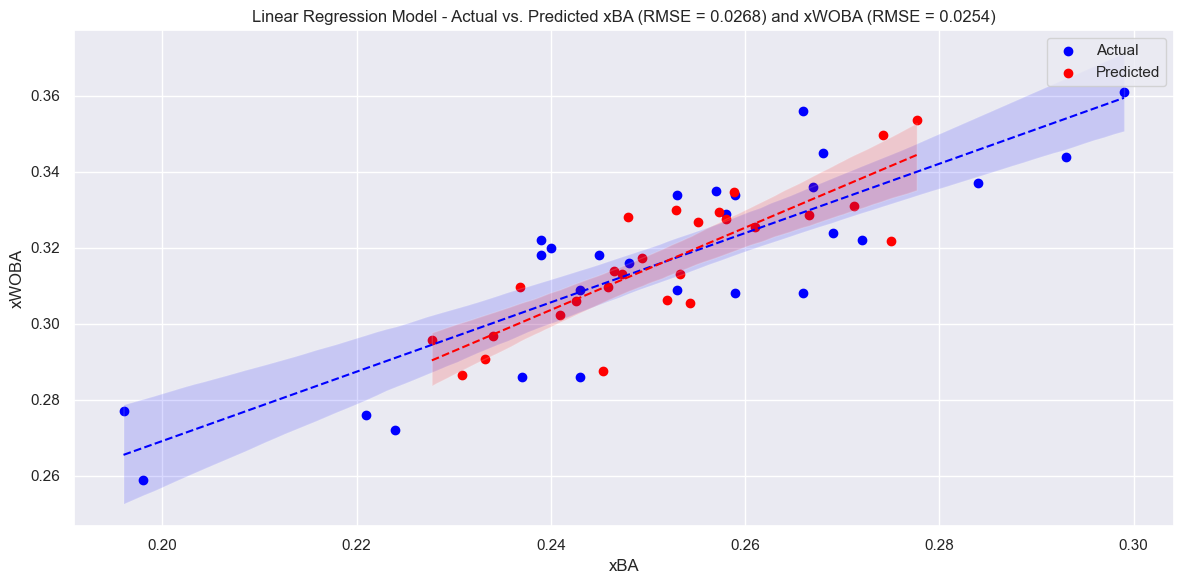

In [316]:
# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarZN['xba'], SimilarZN['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarZN['xba'], y=SimilarZN['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Linear Regression Model - Actual vs. Predicted xBA (RMSE = 0.0268) and xWOBA (RMSE = 0.0254)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *XGBoost Model (Parameter-tuned) (RMSE for xBA = 0.0246, xWOBA = 0.0222)*

In [317]:
# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']
Y_xWOBA = SimilarZN['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.036797901067156545
Cross-validation RMSE for xWOBA =  0.030374292325002186


Let's see if I can improve the model's accuracy thorugh parameter tuning

In [318]:
### Parameter Tuning for the xBA model ####

# Import GridSearchCV method form sklearn library
from sklearn.model_selection import GridSearchCV

# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [15, 20, 30],
    'max_depth': [3, 4, 6],
    'colsample_bytree': [0.025, 0.04, 0.05],
    'min_child_weight': [0.01, 0.02, 0.03],
    'learning_rate': [0.07, 0.08, 0.09]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.025, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 0.01, 'n_estimators': 20}
Best Cross-validation RMSE with Best Parameters: -0.022768647574846496


Best Parameters for predicting xBA: 'colsample_bytree': 0.025, 'learning_rate': 0.07, 'max_depth': 6, 'min_child_weight': 0.01, 'n_estimators': 20

In [319]:
### Parameter Tuning for the xWOBA model ####

# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xWOBA = SimilarZN['xwoba']

# Initialize the XGB Regressor
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xWOBA.fit(X, Y_xWOBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [15, 20, 30],
    'max_depth': [1, 2, 3],
    'colsample_bytree': [0.001, 0.002, 0.003],
    'min_child_weight': [0.005, 0.010, 0.015],
    'learning_rate': [0.3, 0.40, 0.50]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.001, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 0.005, 'n_estimators': 20}
Best Cross-validation RMSE with Best Parameters: -0.02132404317290807


Best Parameters for predicting xBA: 'colsample_bytree': 0.001, 'learning_rate': 0.3, 'max_depth': 1, 'min_child_weight': 0.005, 'n_estimators': 20

Let's now apply these parameters to our XGBoost model

In [320]:
# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']
Y_xWOBA = SimilarZN['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.025, learning_rate = 0.07, max_depth = 6, min_child_weight = 0.01, n_estimators = 20)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.001, learning_rate = 0.3, max_depth = 1, min_child_weight = 0.005, n_estimators = 20)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.024611465430711636
Cross-validation RMSE for xWOBA =  0.022244989638500398


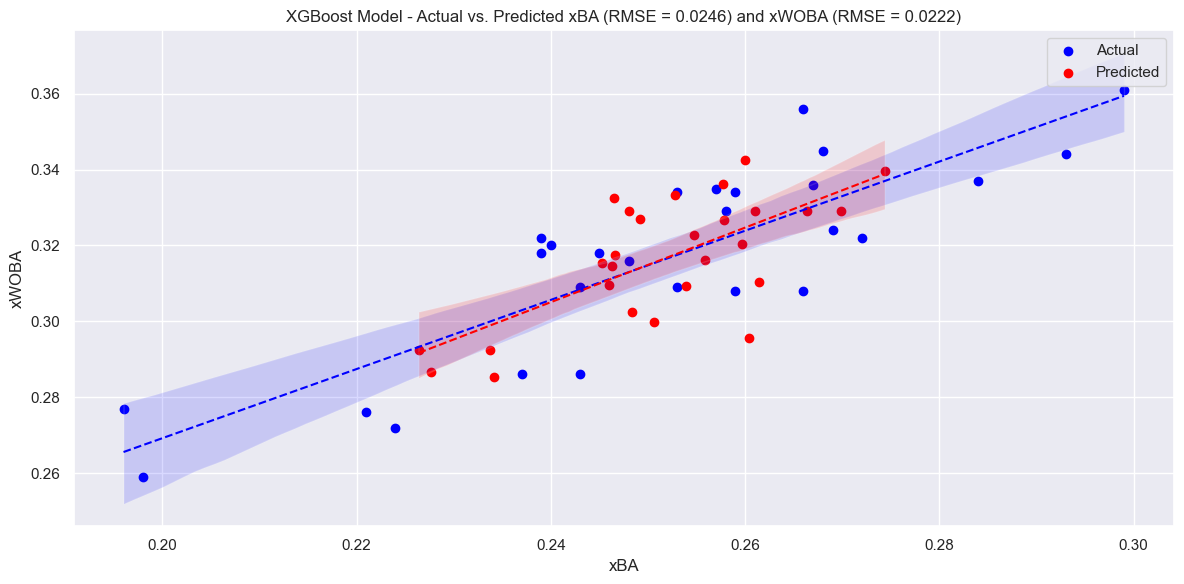

In [321]:
# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.025, learning_rate = 0.07, max_depth = 6, min_child_weight = 0.01, n_estimators = 20)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.001, learning_rate = 0.3, max_depth = 1, min_child_weight = 0.005, n_estimators = 20)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarZN['xba'], SimilarZN['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarZN['xba'], y=SimilarZN['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('XGBoost Model - Actual vs. Predicted xBA (RMSE = 0.0246) and xWOBA (RMSE = 0.0222)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *Random Forest Regressor (RMSE for xBA = 0.0236, xWOBA = 0.0223)*

In [322]:
# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']
Y_xWOBA = SimilarZN['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth=3)
rf_model_xWOBA = RandomForestRegressor(max_depth=3)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.028309929621674078
Cross-validation RMSE for xWOBA =  0.026241299878190752


Let's see if I can improve the models' accuracies with parameter tuning

In [323]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xBA = SimilarZN['xba']
# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor()
# Fit the models
rf_model_xBA.fit(X, Y_xBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [20, 30, 40],
    'max_depth': [60, 70, 80],
    'max_features': [1, 2, 3],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [3, 4, 5]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 70, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 20}
Best Cross-validation RMSE with Best Parameters: -0.0004827539462725658


The best parameters for predicting xBA: 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 20

In [324]:
## PARAMETER TUNING FOR xWOBA ##

# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xWOBA = SimilarZN['xwoba']
# Initialize the Random Forest Regressor
rf_model_xWOBA = RandomForestRegressor()
# Fit the models
rf_model_xWOBA.fit(X, Y_xWOBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [60, 70, 80],
    'max_depth': [20, 30, 50],
    'max_features': [1, 2, 3],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 50, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 60}
Best Cross-validation RMSE with Best Parameters: -0.0004804487216685702


The best parameters for predicting xWOBA: 'max_depth': 20, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 80

Let's apply these new parameters:

In [325]:
# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']
Y_xWOBA = SimilarZN['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 80, max_features = 2, min_samples_leaf = 3, min_samples_split = 5, n_estimators = 20)
rf_model_xWOBA = RandomForestRegressor(max_depth = 20, max_features = 1, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 80)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.02421185206093156
Cross-validation RMSE for xWOBA =  0.023016129422254335


After parameter tuning, I got an RMSE of 0.0235 for xBA, and 0.0223 for xWOBA

**NOTE:** Due to the nature of random forest models the printed output may not be the same as the numbers I list

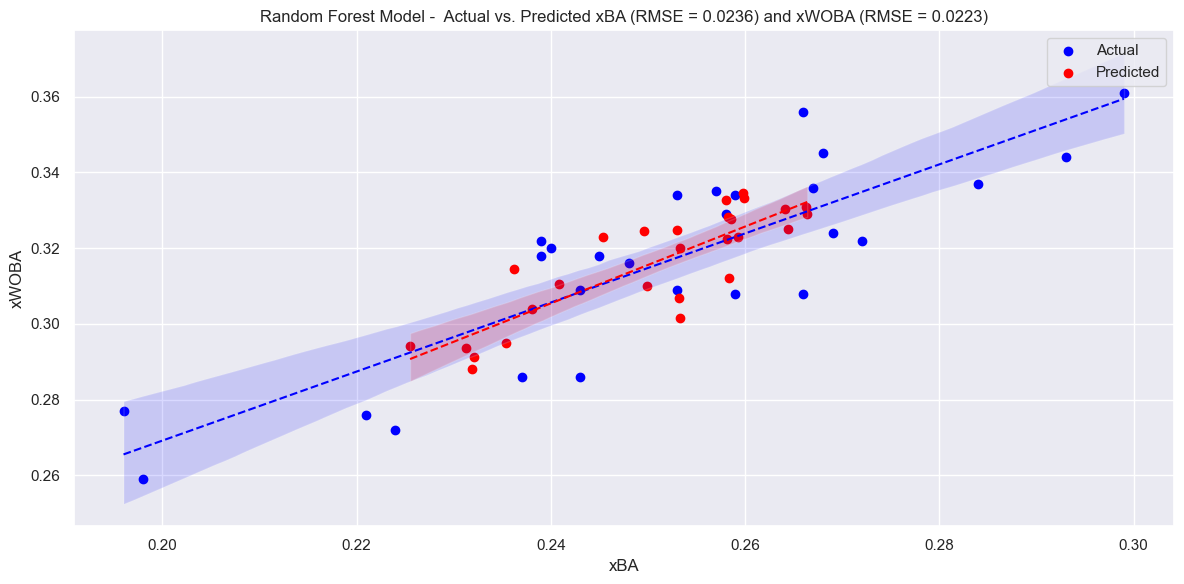

In [326]:
# Predicted values
predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarZN['xba'], SimilarZN['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_rf_xBA, predicted_rf_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarZN['xba'], y=SimilarZN['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_rf_xBA, y=predicted_rf_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Random Forest Model -  Actual vs. Predicted xBA (RMSE = 0.0236) and xWOBA (RMSE = 0.0223)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### *Summary of Predictive Models:*

![Zach Neto Pred Model](images/Zach%20Neto%20Pred%20Table.png)

#### *Final Results for Zach Neto*

In [327]:
## Reload Decision Tree Model ##

# Define features
X = SimilarZN[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarZN['xba']
Y_xWOBA = SimilarZN['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 80, max_features = 2, min_samples_leaf = 3, min_samples_split = 5, n_estimators = 20)
rf_model_xWOBA = RandomForestRegressor(max_depth = 20, max_features = 1, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 80)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Predicted values
predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

In [328]:
# Define the Zach Neto's bat speed and the range of intervals
ZN_bat_speed = 70.8
end_bat_speed = ZN_bat_speed + 3.2
bat_speeds = np.arange(ZN_bat_speed, end_bat_speed, 0.5) 

# Set Zach Neto's predictors
player_predictors = {
    'barrel_batted_rate': 8.7,
    'hard_hit_percent': 38.5,
    'sweet_spot_percent': 30.1,
    'flyballs_percent': 28.2
}

# Empty lists to store predictions
predicted_xBA_list = []
predicted_xWOBA_list = []

# Iterate over the range of bat speeds (70.8 mph - 73.8 mph)
for bat_speed in bat_speeds:
    # Create a data frame with the player's predictors and the current bat speed
    input_data = pd.DataFrame({
        'barrel_batted_rate': [player_predictors['barrel_batted_rate']],
        'hard_hit_percent': [player_predictors['hard_hit_percent']],
        'avg_swing_speed': [bat_speed],
        'sweet_spot_percent': [player_predictors['sweet_spot_percent']],
        'flyballs_percent': [player_predictors['flyballs_percent']]
    })
    
    # Predicted values
    predicted_rf_xBA = rf_model_xBA.predict(input_data)
    predicted_rf_xWOBA = rf_model_xWOBA.predict(input_data)
    
    # Store prediction
    predicted_xBA_list.append(predicted_rf_xBA[0]) 
    predicted_xWOBA_list.append(predicted_rf_xWOBA[0])

# Convert the lists to arrays for further analysis or plotting
predicted_xBA_array = np.array(predicted_xBA_list)
predicted_xWOBA_array = np.array(predicted_xWOBA_list)

# Output
for i, bat_speed in enumerate(bat_speeds):
    print(f"Bat Speed: {bat_speed:.2f} mph -> Predicted xBA: {predicted_xBA_array[i]:.4f}, Predicted xWOBA: {predicted_xWOBA_array[i]:.4f}")


Bat Speed: 70.80 mph -> Predicted xBA: 0.2432, Predicted xWOBA: 0.3036
Bat Speed: 71.30 mph -> Predicted xBA: 0.2432, Predicted xWOBA: 0.3047
Bat Speed: 71.80 mph -> Predicted xBA: 0.2390, Predicted xWOBA: 0.3083
Bat Speed: 72.30 mph -> Predicted xBA: 0.2390, Predicted xWOBA: 0.3087
Bat Speed: 72.80 mph -> Predicted xBA: 0.2390, Predicted xWOBA: 0.3052
Bat Speed: 73.30 mph -> Predicted xBA: 0.2390, Predicted xWOBA: 0.3050
Bat Speed: 73.80 mph -> Predicted xBA: 0.2390, Predicted xWOBA: 0.3050


Below is a summary of the results:

![Zach Neto Pred Result Table](images/Zach%20Neto%20Pred%20Result%20Table.png)

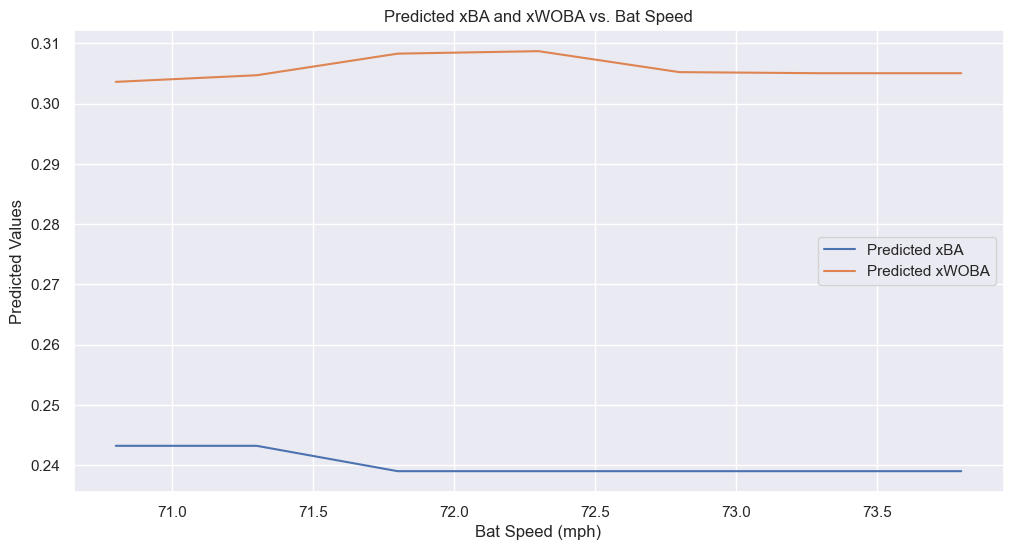

In [329]:
plt.figure(figsize=(12, 6))
plt.plot(bat_speeds, predicted_xBA_array, label='Predicted xBA')
plt.plot(bat_speeds, predicted_xWOBA_array, label='Predicted xWOBA')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Predicted Values')
plt.title('Predicted xBA and xWOBA vs. Bat Speed')
plt.legend()
plt.grid(True)
plt.show()

## Candidates for Regression

To identify candidates for regression, I'll focus on players who are not in the "Struggling" classification, but very close to the average bat speed and xBA thresholds (**within 0.005 xBA** of the average, **0.1 - 0.5 mph** of the average bat speed). 

Upon identifying these candidates, I'll apply the predictive model I identified earlier, observing how each players' performance would decline as their bat speed decreases.

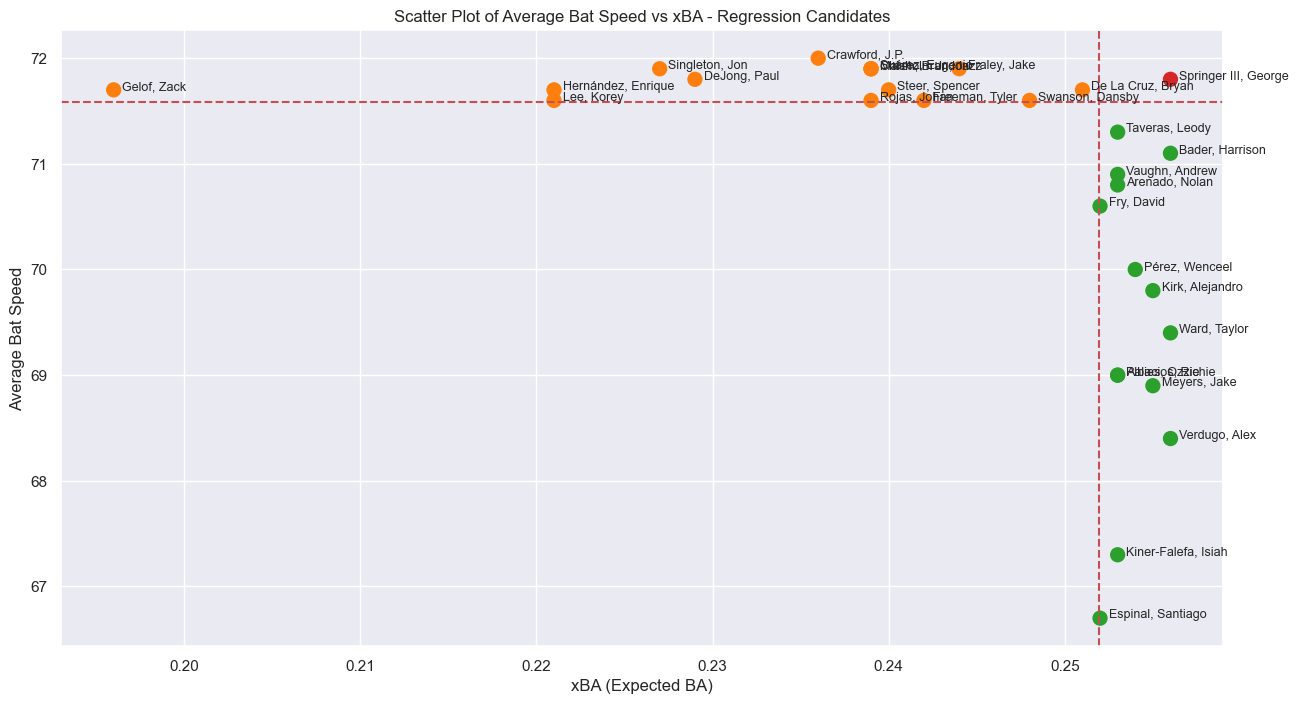

In [330]:
# Identify players who are within 0.5 mph of the bat speed average & 0.005 of the xBA average
NotStruggling = grouped[grouped['hit_class'] != "Struggling"]
Filter = NotStruggling[NotStruggling['avg_swing_speed'] < 71.5883018867924 + 0.5]
Regr = Filter[Filter['xba'] <  0.25192075471698117 + 0.005]


# Define a color map for the 'hit_class' categories
color_map = {'Elite':'tab:red', 'Power Oriented':'tab:orange', '.BA Oriented':'tab:green'}
# Map the 'hit_class' values to colors
colors = Regr['hit_class'].map(color_map)

# Create the scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(Regr['xba'], Regr['avg_swing_speed'], color=colors, s=100)
plt.xlabel('xBA (Expected BA)')
plt.ylabel('Average Bat Speed')
plt.title('Scatter Plot of Average Bat Speed vs xBA - Regression Candidates')
plt.grid(True)

# Plot averages
plt.axhline(y=71.5883018867924, color='r', linestyle='--', label = '_nolegend_')
plt.axvline(x=0.25192075471698117, color='r', linestyle='--', label = '_nolegend_')

# Plot the name
for i, row in Regr.iterrows():
    plt.text(row['xba'] + 0.0005, row['avg_swing_speed'], 
             row['last_name, first_name'], fontsize=9, ha='left')


In [331]:
Regr

last_name, first_name  player_id  year   pa  home_run  k_percent  \
16   Springer III, George     543807  2024  469        14       19.2   
20        Suárez, Eugenio     553993  2024  475        18       27.6   
22         Arenado, Nolan     571448  2024  480        12       13.8   
24     Hernández, Enrique     571771  2024  311         7       20.6   
25         Singleton, Jon     572138  2024  324        10       27.5   
62        Swanson, Dansby     621020  2024  434         9       25.1   
67           Ward, Taylor     621493  2024  489        16       25.2   
79         Crawford, J.P.     641487  2024  335         9       22.7   
80           Fraley, Jake     641584  2024  284         3       19.4   
94    Kiner-Falefa, Isiah     643396  2024  334         7       14.1   
97          Albies, Ozzie     645277  2024  394         8       15.5   
106     De La Cruz, Bryan     650559  2024  505        18       27.1   
115         Verdugo, Alex     657077  2024  504        10       15.3   
117          DeJong, Paul     657557  2024  397        20       30.7   
141       Bader, Harrison     664056  2024  349         8       21.2   
152        Taveras, Leody     665750  2024  414         9       19.8   
156    Chisholm Jr., Jazz     665862  2024  491        20       25.1   
173        Steer, Spencer     668715  2024  497        18       20.5   
180        Marsh, Brandon     669016  2024  352        11       33.0   
187     Espinal, Santiago     669289  2024  255         8       12.2   
200        Freeman, Tyler     671289  2024  360         7       13.6   
206       Kirk, Alejandro     672386  2024  257         3       14.4   
210        Pérez, Wenceel     672761  2024  378         9       20.1   
219          Meyers, Jake     676694  2024  390        12       23.6   
227          Rojas, Johan     679032  2024  290         3       18.3   
229      Palacios, Richie     680700  2024  301         5       21.9   
233           Gelof, Zack     680869  2024  392        15       34.9   
239            Fry, David     681807  2024  325        12       20.9   
246        Vaughn, Andrew     683734  2024  465        14       21.9   
251            Lee, Korey     686676  2024  304        10       30.9   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
16         10.2        0.368            0.301             0.669  ...   
20          8.4        0.428            0.309             0.737  ...   
22          7.1        0.390            0.324             0.714  ...   
24          8.0        0.336            0.277             0.613  ...   
25         11.1        0.367            0.321             0.688  ...   
62          8.8        0.350            0.297             0.647  ...   
67          9.6        0.399            0.313             0.712  ...   
79         11.3        0.347            0.299             0.646  ...   
80          6.3        0.375            0.331             0.706  ...   
94          4.2        0.417            0.332             0.749  ...   
97          6.1        0.407            0.310             0.717  ...   
106         5.1        0.395            0.282             0.677  ...   
115         8.1        0.366            0.294             0.660  ...   
117         4.5        0.440            0.285             0.725  ...   
141         4.6        0.393            0.307             0.700  ...   
152         8.0        0.358            0.292             0.650  ...   
156         8.8        0.445            0.328             0.773  ...   
173        10.7        0.427            0.324             0.751  ...   
180        10.2        0.399            0.318             0.717  ...   
187         5.9        0.381            0.291             0.672  ...   
200         7.5        0.331            0.305             0.636  ...   
206         9.3        0.324            0.307             0.631  ...   
210         7.1        0.386            0.298             0.684  ...   
219         6.4        0.390            0.2

Upon applying my initial criteria, there are 30 candidates for regression. To narrow down this list, I'll only focus on players 33 and above. This criteria was based on the insights from earlier, establishing that bat speed tends to regress as a player's age increases.

In [332]:
# Select players 33 and above
Regr = Regr[Regr['player_age'] >= 33]
Regr

last_name, first_name  player_id  year   pa  home_run  k_percent  \
16  Springer III, George     543807  2024  469        14       19.2   
22        Arenado, Nolan     571448  2024  480        12       13.8   

    bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
16        10.2        0.368            0.301             0.669  ...   
22         7.1        0.390            0.324             0.714  ...   

    linedrives_percent  player_age  side   woba  AgeGroup     hit_class  Team  \
16                22.6          34     R  0.323     30-34         Elite   TOR   
22                26.9          33     R  0.318     30-34  .BA Oriented   STL   

               Name  Role   diff  
16  George Springer     1  0.007  
22    Nolan Arenado     5 -0.020  

[2 rows x 41 columns]

Having just 2 candidates left, I can proceed with my analysis.

Similarly to last section, I'll be predicting for each candidate's xBA and xWOBA based on incremental changes to their bat speeds. In this case, I will fixate on decreases to the player's bat speed, assessing how their performance changes. 

To provide for a more effective analysis, I'll apply the same criteria as the previous section to limit my player pool. However, I've made a few modifications to ensure a larger player pool. Through this, I'll be able to reduce the risk of overfitting while also securing a reasonable sample size. The criteria will be as follows:

* Within 4 years of the player's age (older or younger)
* Within 3 mph (above or below) the player's bat speed
* Within 4% of the player's barrel batted rate (above or below)
* Within 5% of the player's fly ball percent (above or below)
* Within 0.75 ft of the player's swing length (above or below)




### Regression Candidate 1: George Springer

#### *Identifying players similar to George Springer*

Let's begin by identifying candidates similar to George Springer

In [333]:
# Retrieve stats for George Springer
GeorgeSpringer = grouped[grouped['player_id'] == 543807]
print(GeorgeSpringer['player_age'])
print(GeorgeSpringer['avg_swing_speed'])
print(GeorgeSpringer['barrel_batted_rate'])
print(GeorgeSpringer['flyballs_percent'])
print(GeorgeSpringer['hard_hit_percent'])
print(GeorgeSpringer['sweet_spot_percent'])
print(GeorgeSpringer['avg_swing_length'])

16    34
Name: player_age, dtype: int64
16    71.8
Name: avg_swing_speed, dtype: float64
16    8.5
Name: barrel_batted_rate, dtype: float64
16    21.6
Name: flyballs_percent, dtype: float64
16    38.3
Name: hard_hit_percent, dtype: float64
16    30.5
Name: sweet_spot_percent, dtype: float64
16    7.4
Name: avg_swing_length, dtype: float64


In [334]:
# Create dataset of similar players
SimilarGS = grouped[
    (grouped['player_age'] >= 30) & (grouped['player_age'] <= 38) &
    (grouped['avg_swing_speed'] >= 68.8) & (grouped['avg_swing_speed'] <= 74.8) &
    (grouped['barrel_batted_rate'] >= 4.5) & (grouped['barrel_batted_rate'] <= 12.5) &
    (grouped['flyballs_percent'] >= 16.6) & (grouped['flyballs_percent'] <= 26.6) &
    (grouped['avg_swing_length'] >= 6.65) & (grouped['avg_swing_length'] <= 8.15) &
    (grouped['player_id'] != 543807) # exclude George Springer from the group itself
]

SimilarGS

last_name, first_name  player_id  year   pa  home_run  k_percent  \
4             Pham, Tommy     502054  2024  350         7       20.6   
7            Altuve, Jose     514888  2024  526        15       18.1   
8         Marte, Starling     516782  2024  266         7       21.1   
35         Realmuto, J.T.     592663  2024  303         8       23.8   
38      Yelich, Christian     592885  2024  315        11       18.4   
39       Bogaerts, Xander     593428  2024  312         6       17.6   
42      Profar, Jurickson     595777  2024  503        19       14.3   
44             Cave, Jake     595909  2024  265         6       27.2   
48             Bell, Josh     605137  2024  504        18       19.4   
52           Marte, Ketel     606466  2024  496        30       17.9   
58          Winker, Jesse     608385  2024  423        11       21.7   
59         Refsnyder, Rob     608701  2024  251         7       24.7   
60          Meneses, Joey     608841  2024  313         3       20.1   
62        Swanson, Dansby     621020  2024  434         9       25.1   
65         Taylor, Tyrone     621438  2024  264         6       22.0   
75      Cronenworth, Jake     630105  2024  500        15       18.2   
105           Díaz, Yandy     650490  2024  492        10       15.7   
110           Joe, Connor     656582  2024  350         7       20.6   
141       Bader, Harrison     664056  2024  349         8       21.2   
145     Wade Jr., LaMonte     664774  2024  283         4       22.6   
264     Yoshida, Masataka     807799  2024  295         8       13.6   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
4           8.6        0.396            0.331             0.727  ...   
7           6.5        0.434            0.348             0.782  ...   
8           6.4        0.416            0.328             0.744  ...   
35          6.9        0.386            0.314             0.700  ...   
38         12.7        0.504            0.406             0.910  ...   
39          5.4        0.373            0.308             0.681  ...   
42         11.1        0.479            0.393             0.872  ...   
44          6.0        0.401            0.298             0.699  ...   
48          7.7        0.418            0.307             0.725  ...   
52         10.3        0.561            0.369             0.930  ...   
58         13.0        0.409            0.368             0.777  ...   
59         10.4        0.472            0.384             0.856  ...   
60          6.7        0.302            0.291             0.593  ...   
62          8.8        0.350            0.297             0.647  ...   
65          4.9        0.400            0.289             0.689  ...   
75          8.0        0.410            0.321             0.731  ...   
105         7.5        0.391            0.325             0.716  ...   
110         8.9        0.369            0.314             0.683  ...   
141         4.6        0.393            0.307             0.700  ...   
145        16.3        0.384            0.404             0.788  ...   
264         7.5        0.429            0.366             0.795  ...   

     linedrives_percent  player_age  side   woba  AgeGroup       hit_class  \
4                  30.5          36     R  0.161     35-39           Elite   
7                  27.0          34     R  0.363     30-34    .BA Oriented   
8                  31.4          35     R  0.236     35-39           Elite   
35                 27.2          33     R  0.415     30-34           Elite   
38                 23.4          32     L    NaN     30-34           Elite   
39                 25.1          31     R  0.298     30-34    .BA Oriented   
42                 24.7          31     S  0.278     30-34           Elite   
44                 28.8          31     L  0.307     30-34      Struggling   
48                 21.1          31     S  0.289     30-34      Struggling   
52                 22.1          30     S  0.393     3

With our player pool narrowed down, we can proceed with our predictive modelling.

#### *Multiple Linear Regression Model (RMSE for xBA = 0.0212, xWOBA = 0.0235)*

In [335]:
# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']
Y_xWOBA = SimilarGS['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.021194922687826873
Cross-validation RMSE for xWOBA =  0.0235041592991238


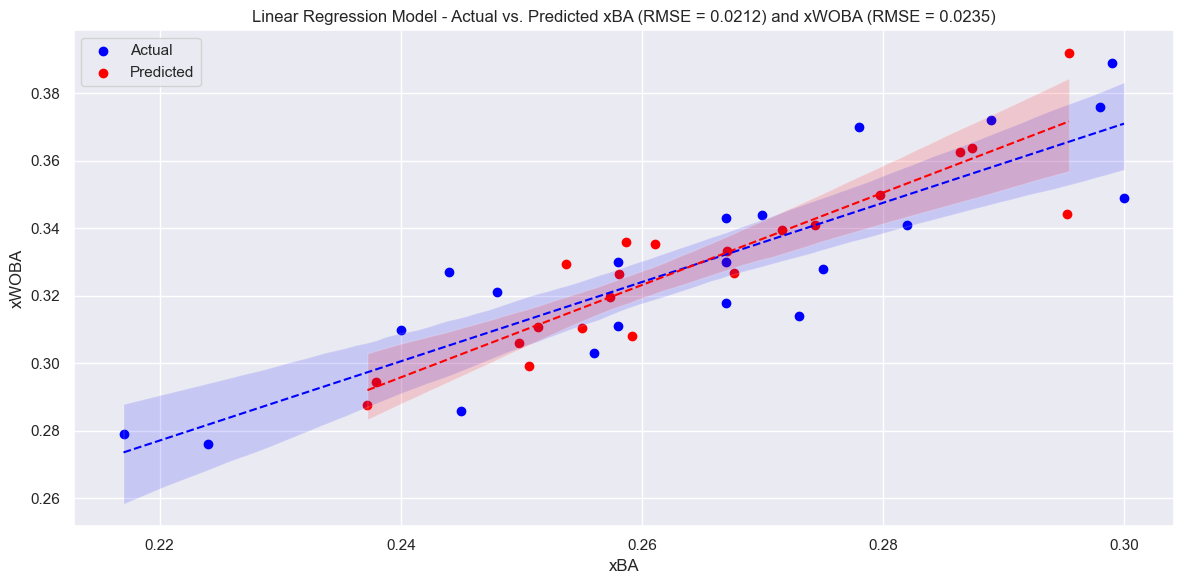

In [336]:
# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarGS['xba'], SimilarGS['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarGS['xba'], y=SimilarGS['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Linear Regression Model - Actual vs. Predicted xBA (RMSE = 0.0212) and xWOBA (RMSE = 0.0235)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *XGBoost Model (Parameter-tuned) (RMSE for xBA = 0.0207, xWOBA = 0.0235)*

In [337]:
# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']
Y_xWOBA = SimilarGS['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.024087467984353583
Cross-validation RMSE for xWOBA =  0.032061919303340236


Let's see if I can prove the model's accuracy by tuning the prameters

In [338]:
### Parameter Tuning for the xBA model ####

# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [20, 30, 40],
    'max_depth': [1, 3, 6],
    'colsample_bytree': [0.01, 0.03, 0.05],
    'min_child_weight': [0.01, 0.02, 0.03],
    'learning_rate': [0.03, 0.05, 0.07]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.01, 'learning_rate': 0.07, 'max_depth': 1, 'min_child_weight': 0.01, 'n_estimators': 40}
Best Cross-validation RMSE with Best Parameters: -0.020225483147230213


Best Parameters for predicting xBA: 'colsample_bytree': 0.01, 'learning_rate': 0.07, 'max_depth': 1, 'min_child_weight': 0.01, 'n_estimators': 40

In [339]:
### Parameter Tuning for the xWOBA model ####

# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xWOBA = SimilarGS['xwoba']

# Initialize the XGB Regressor
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xWOBA.fit(X, Y_xWOBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [10, 20, 30],
    'max_depth': [1, 2, 3],
    'colsample_bytree': [0.001, 0.002, 0.003],
    'min_child_weight': [0.01, 0.015, 0.020],
    'learning_rate': [0.15, 0.20, 0.25]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.001, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 0.01, 'n_estimators': 30}
Best Cross-validation RMSE with Best Parameters: -0.023191391926269823


Best Parameters for predicting xWOBA: 'colsample_bytree': 0.001, 'learning_rate': 0.2, 'max_depth': 1, 'min_child_weight': 0.01, 'n_estimators': 30

Let's now apply these new parameters:

In [340]:
# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']
Y_xWOBA = SimilarGS['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.01, learning_rate = 0.07, max_depth = 1, min_child_weight = 0.01, n_estimators = 40)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.001, learning_rate = 0.2, max_depth = 1, min_child_weight = 0.01, n_estimators = 30)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.020653566343018726
Cross-validation RMSE for xWOBA =  0.023478300529775235


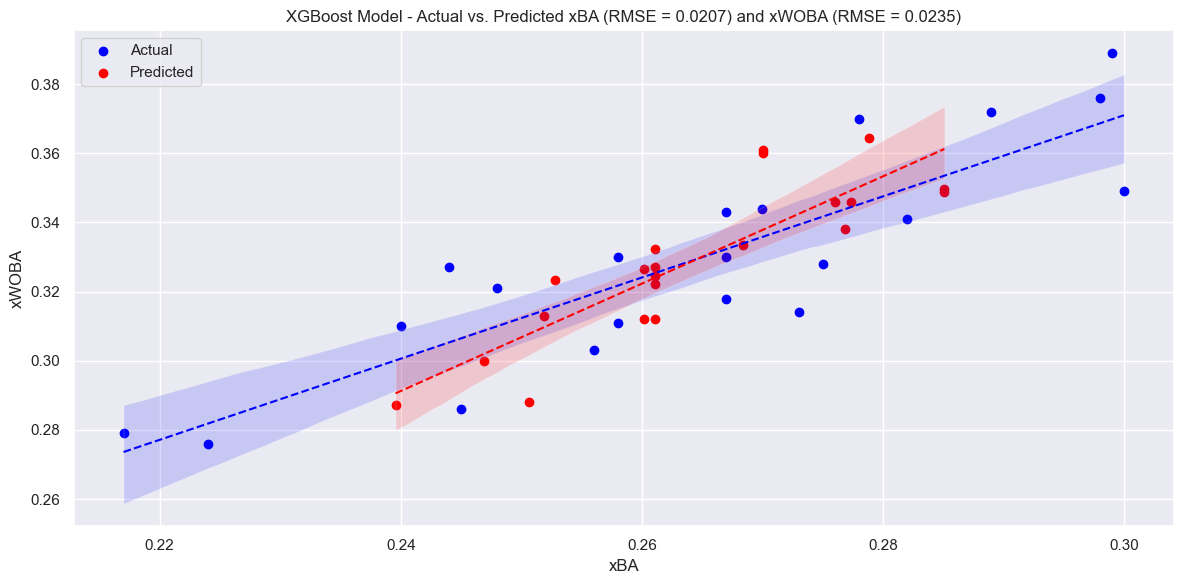

In [341]:
# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.01, learning_rate = 0.07, max_depth = 1, min_child_weight = 0.01, n_estimators = 40)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 0.001, learning_rate = 0.2, max_depth = 1, min_child_weight = 0.01, n_estimators = 30)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarGS['xba'], SimilarGS['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarGS['xba'], y=SimilarGS['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('XGBoost Model - Actual vs. Predicted xBA (RMSE = 0.0207) and xWOBA (RMSE = 0.0235)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *Random Forest Regressor (RMSE for xA = 0.0203, xWOBA = 0.0228)*

In [342]:
# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']
Y_xWOBA = SimilarGS['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth=3)
rf_model_xWOBA = RandomForestRegressor(max_depth=3)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.021705308537578544
Cross-validation RMSE for xWOBA =  0.02320598199760489


Let's see if I can improve the model's accuracy by tuning its parameters

In [343]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xBA = SimilarGS['xba']
# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor()
# Fit the models
rf_model_xBA.fit(X, Y_xBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [60, 70, 80],
    'max_depth': [30, 40, 50],
    'max_features': [3, 4, 5],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [2, 3, 4]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 40, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}
Best Cross-validation RMSE with Best Parameters: -0.0004024973995298501


The best parameters for predicting xBA: 'max_depth': 50, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 80

In [344]:
## PARAMETER TUNING FOR xWOBA ##

# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xWOBA = SimilarGS['xwoba']
# Initialize the Random Forest Regressor
rf_model_xWOBA = RandomForestRegressor()
# Fit the models
rf_model_xWOBA.fit(X, Y_xWOBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [45, 50, 55],
    'max_depth': [40, 50, 60],
    'max_features': [3, 5, 7],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 60, 'max_features': 7, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 45}
Best Cross-validation RMSE with Best Parameters: -0.000518736664748565


The best parameters for predicting xWOBA: 'max_depth': 60, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 55

Let's apply these new parameters:

In [345]:
# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']
Y_xWOBA = SimilarGS['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 50, max_features = 3, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 80)
rf_model_xWOBA = RandomForestRegressor(max_depth = 60, max_features = 5, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 55)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.02086799852623806
Cross-validation RMSE for xWOBA =  0.02433223940331356


After parameter tuning, I got an RMSE of 0.0204 for xOBA, and 0.0228 for xWOBA

**NOTE:** Due to the nature of random forest models the printed output may not be the same as the numbers I list

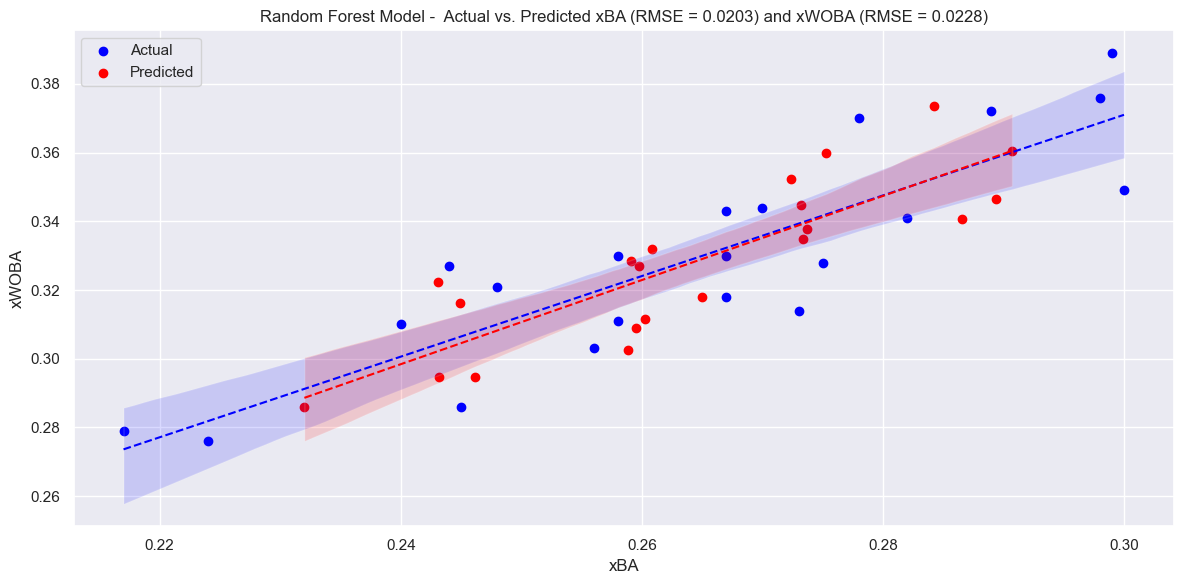

In [346]:
# Predicted values
predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarGS['xba'], SimilarGS['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_rf_xBA, predicted_rf_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarGS['xba'], y=SimilarGS['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_rf_xBA, y=predicted_rf_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Random Forest Model -  Actual vs. Predicted xBA (RMSE = 0.0203) and xWOBA (RMSE = 0.0228)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### *Summary of Predictive Models:*

![George Springer Pred Table](images/George%20Springer%20Pred%20Table.png)

#### *Final Results for George Springer*

In [347]:
## Reload Decision Tree Regressor ##

# Define features
X = SimilarGS[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarGS['xba']
Y_xWOBA = SimilarGS['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 50, max_features = 3, min_samples_leaf = 2, min_samples_split = 3, n_estimators = 80)
rf_model_xWOBA = RandomForestRegressor(max_depth = 60, max_features = 5, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 55)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

RandomForestRegressor(max_depth=60, max_features=5, n_estimators=55)

In [348]:
# Define the George Springer's bat speed and the range of intervals
GS_bat_speed = 71.8
end_bat_speed = GS_bat_speed - 3.2
bat_speeds = np.arange(GS_bat_speed, end_bat_speed, -0.5) 

# Set George Springers's predictors
player_predictors = {
    'barrel_batted_rate': 8.5,
    'hard_hit_percent': 38.3,
    'sweet_spot_percent': 30.5,
    'flyballs_percent': 21.6
}

# Empty lists to store predictions
predicted_xBA_list = []
predicted_xWOBA_list = []

# Iterate over the range of bat speeds (71.8 mph - 68.8 mph)
for bat_speed in bat_speeds:
    # Create a data frame with the player's predictors and the current bat speed
    input_data = pd.DataFrame({
        'barrel_batted_rate': [player_predictors['barrel_batted_rate']],
        'hard_hit_percent': [player_predictors['hard_hit_percent']],
        'avg_swing_speed': [bat_speed],
        'sweet_spot_percent': [player_predictors['sweet_spot_percent']],
        'flyballs_percent': [player_predictors['flyballs_percent']]
    })
    
    # Predicted values
    predicted_rf_xBA = rf_model_xBA.predict(input_data)
    predicted_rf_xWOBA = rf_model_xWOBA.predict(input_data)
    
    # Store prediction
    predicted_xBA_list.append(predicted_rf_xBA[0]) 
    predicted_xWOBA_list.append(predicted_rf_xWOBA[0])

# Convert the lists to arrays for further analysis or plotting
predicted_xBA_array = np.array(predicted_xBA_list)
predicted_xWOBA_array = np.array(predicted_xWOBA_list)

# Output
for i, bat_speed in enumerate(bat_speeds):
    print(f"Bat Speed: {bat_speed:.2f} mph -> Predicted xBA: {predicted_xBA_array[i]:.4f}, Predicted xWOBA: {predicted_xWOBA_array[i]:.4f}")

Bat Speed: 71.80 mph -> Predicted xBA: 0.2585, Predicted xWOBA: 0.3277
Bat Speed: 71.30 mph -> Predicted xBA: 0.2479, Predicted xWOBA: 0.3198
Bat Speed: 70.80 mph -> Predicted xBA: 0.2475, Predicted xWOBA: 0.3201
Bat Speed: 70.30 mph -> Predicted xBA: 0.2470, Predicted xWOBA: 0.3206
Bat Speed: 69.80 mph -> Predicted xBA: 0.2467, Predicted xWOBA: 0.3233
Bat Speed: 69.30 mph -> Predicted xBA: 0.2467, Predicted xWOBA: 0.3233
Bat Speed: 68.80 mph -> Predicted xBA: 0.2474, Predicted xWOBA: 0.3251


In [349]:
# Retrieve stats for George Springer
GeorgeSpringer = grouped[grouped['player_id'] == 543807]
print(GeorgeSpringer['xba'])
print(GeorgeSpringer['xwoba'])

16    0.256
Name: xba, dtype: float64
16    0.33
Name: xwoba, dtype: float64


Below is a summary of the results:

![George Springer Pred Result](images/George%20Springer%20Pred%20Result.png)

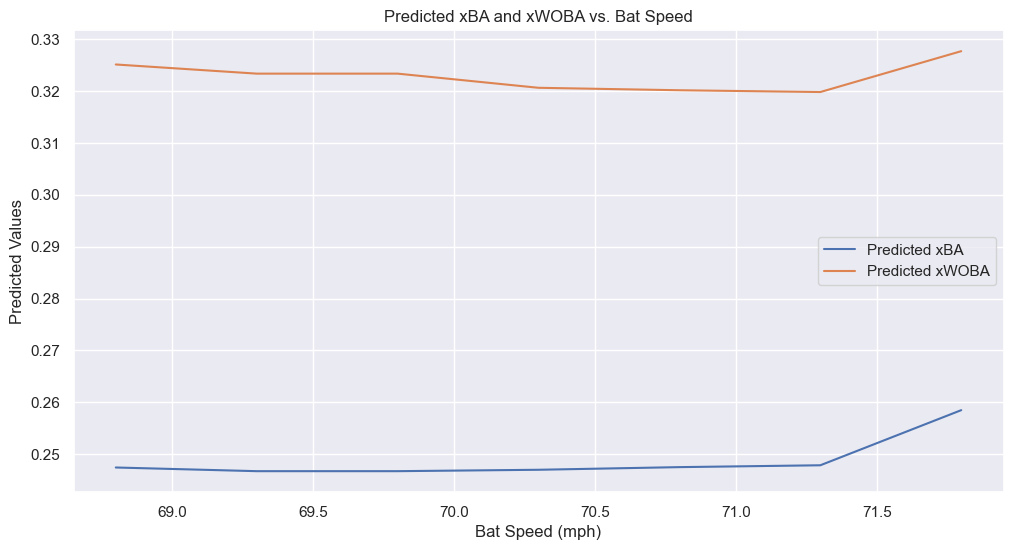

In [350]:
# Plot predicted values
plt.figure(figsize=(12, 6))
plt.plot(bat_speeds, predicted_xBA_array, label='Predicted xBA')
plt.plot(bat_speeds, predicted_xWOBA_array, label='Predicted xWOBA')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Predicted Values')
plt.title('Predicted xBA and xWOBA vs. Bat Speed')
plt.legend()
plt.grid(True)
plt.show()

### Regression Candidate 2: Nolan Arenado

#### *Identify Candidates Similar to Nolan Arenado*

Let's begin by identifying candidates similar to Nolan Arenado

In [351]:
# Retrieve stats for Nolan Arenado
NolanArenado = grouped[grouped['player_id'] == 571448]
print(NolanArenado['player_age'])
print(NolanArenado['avg_swing_speed'])
print(NolanArenado['barrel_batted_rate'])
print(NolanArenado['flyballs_percent'])
print(NolanArenado['hard_hit_percent'])
print(NolanArenado['sweet_spot_percent'])
print(NolanArenado['avg_swing_length'])

22    33
Name: player_age, dtype: int64
22    70.8
Name: avg_swing_speed, dtype: float64
22    3.2
Name: barrel_batted_rate, dtype: float64
22    24.5
Name: flyballs_percent, dtype: float64
22    29.9
Name: hard_hit_percent, dtype: float64
22    36.0
Name: sweet_spot_percent, dtype: float64
22    8.3
Name: avg_swing_length, dtype: float64


**NOTE:** Due to Arenado's unique characteristics I modified some of my criteria to allow for a larger player pool for my predictive models (initially, there were only 4 players within the pool). The changes are als follows

* Within 4 years of the player's age --> Within 5 years of the player's age
* Within 4% of the player's barrel batted rate --> Within 5% of the player's barrel batted rate
* Within 5% of the player's flyball percent --> Within 5.5% of the player's flyball percent
* Within 0.75 ft of the player's swing length --> Within 1 ft of the player's swing length

In [352]:
# Create dataset of similar players
SimilarNA = grouped[
    (grouped['player_age'] >= 28) & (grouped['player_age'] <= 38) &
    (grouped['avg_swing_speed'] >= 67.8) & (grouped['avg_swing_speed'] <= 73.8) &
    (grouped['barrel_batted_rate'] >= 0) & (grouped['barrel_batted_rate'] <= 8.2) &
    (grouped['flyballs_percent'] >= 19) & (grouped['flyballs_percent'] <= 30) &
    (grouped['avg_swing_length'] >= 7.3) & (grouped['avg_swing_length'] <= 9.05) &
    (grouped['player_id'] != 571448) # exclude Nolan Arenado from the group itself
]

SimilarNA

last_name, first_name  player_id  year   pa  home_run  k_percent  \
3         Santana, Carlos     467793  2024  446        17       17.3   
7            Altuve, Jose     514888  2024  526        15       18.1   
15         Semien, Marcus     543760  2024  545        18       13.9   
24     Hernández, Enrique     571771  2024  311         7       20.6   
38      Yelich, Christian     592885  2024  315        11       18.4   
42      Profar, Jurickson     595777  2024  503        19       14.3   
48             Bell, Josh     605137  2024  504        18       19.4   
50         Arcia, Orlando     606115  2024  447        11       20.8   
54           Turner, Trea     607208  2024  366        13       18.9   
58          Winker, Jesse     608385  2024  423        11       21.7   
69         Margot, Manuel     622534  2024  281         4       15.7   
73           Gordon, Nick     624503  2024  275         8       24.4   
79         Crawford, J.P.     641487  2024  335         9       22.7   
82            Heim, Jonah     641680  2024  386        11       18.1   
92        Dubón, Mauricio     643289  2024  311         4       12.9   
110           Joe, Connor     656582  2024  350         7       20.6   
111    Mullins II, Cedric     656775  2024  370        13       21.1   
116          Wong, Connor     657136  2024  371        11       23.2   
118         Sheets, Gavin     657757  2024  392         8       21.4   
137       Lowe, Nathaniel     663993  2024  410        10       21.7   
158        Fermin, Freddy     666023  2024  265         6       17.0   
169  Gurriel Jr., Lourdes     666971  2024  466        14       19.3   
183          Senzel, Nick     669222  2024  264         7       22.7   
264     Yoshida, Masataka     807799  2024  295         8       13.6   

     bb_percent  slg_percent  on_base_percent  on_base_plus_slg  ...  \
3          10.3        0.429            0.330             0.759  ...   
7           6.5        0.434            0.348             0.782  ...   
15          9.2        0.404            0.312             0.716  ...   
24          8.0        0.336            0.277             0.613  ...   
38         12.7        0.504            0.406             0.910  ...   
42         11.1        0.479            0.393             0.872  ...   
48          7.7        0.418            0.307             0.725  ...   
50          6.0        0.353            0.274             0.627  ...   
54          4.9        0.475            0.352             0.827  ...   
58         13.0        0.409            0.368             0.777  ...   
69          6.4        0.342            0.295             0.637  ...   
73          4.0        0.369            0.258             0.627  ...   
79         11.3        0.347            0.299             0.646  ...   
82          6.0        0.345            0.277             0.622  ...   
92          3.9        0.366            0.285             0.651  ...   
110         8.9        0.369            0.314             0.683  ...   
111         6.8        0.401            0.283             0.684  ...   
116         5.7        0.440            0.350             0.790  ...   
118         9.2        0.374            0.309             0.683  ...   
137        12.9        0.382            0.354             0.736  ...   
158         6.4        0.424            0.352             0.776  ...   
169         4.3        0.412            0.307             0.719  ...   
183        10.6        0.335            0.286             0.621  ...   
264         7.5        0.429            0.366             0.795  ...   

     linedrives_percent  player_age  side   woba  AgeGroup       hit_class  \
3                  22.7          38     S  0.310     35-39      Struggling   
7                  27.0          34     R  0.363     30-34    .BA Oriented   
15                 23.7          33     R  0.265     30-34    .BA Oriented   
24                 25.2          32     R  0.310     30-34  Power Oriented   
38          

While this is still somewhat of a limited player pool, it should be sufficient for my analysis. As such, I'll proceed with my analysis

#### *Multiple Linear Regression Model (RMSE for xBA = 0.0264, xWOBA = 0.0232)*

In [353]:
# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']
Y_xWOBA = SimilarNA['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.026422218051879585
Cross-validation RMSE for xWOBA =  0.02324018897336838


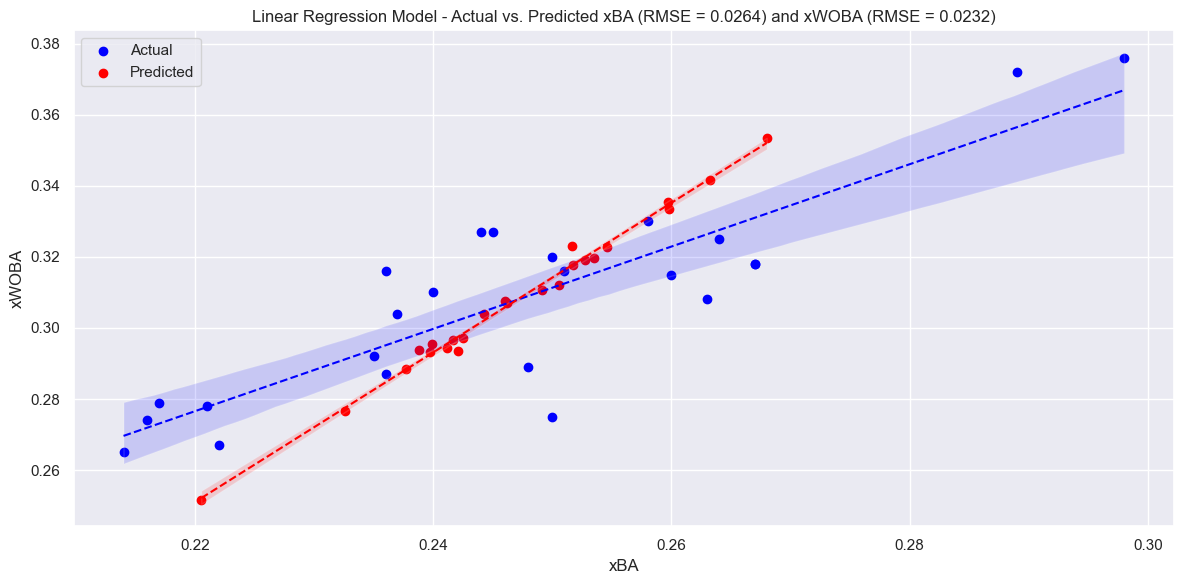

In [354]:
# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarNA['xba'], SimilarNA['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarNA['xba'], y=SimilarNA['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Linear Regression Model - Actual vs. Predicted xBA (RMSE = 0.0264) and xWOBA (RMSE = 0.0232)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *XGBoost Model (Parameter-tuned) (RMSE for xBA = 0.0213, xWOBA = 0.0269)*

In [355]:
# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']
Y_xWOBA = SimilarNA['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

Cross-validation RMSE for xBA =  0.02303392390342451
Cross-validation RMSE for xWOBA =  0.026995374472159935


Let's see if I can improve the model's accuracy through parameter tuning

In [356]:
### Parameter Tuning for the xBA model ####

# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor()

# Fit the models
model_xBA.fit(X, Y_xBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [15, 20, 35, 50],
    'max_depth': [3, 5, 7, 10, 15],
    'colsample_bytree': [0.75, 1, 3],
    'min_child_weight': [0.75, 1, 3],
    'learning_rate': [0.1, 0.2, 0.3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 0.75, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.02056958816071805


Best Parameters for predicting xBA: 'colsample_bytree': 0.75, 'learning_rate': 0.3, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 50

In [357]:
### Parameter Tuning for the xWOBA model ####

# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xWOBA = SimilarNA['xwoba']

# Initialize the XGB Regressor
model_xWOBA = xgb.XGBRegressor()

# Fit the models
model_xWOBA.fit(X, Y_xWOBA)

# Define the parameters to try
param_grid = {
    'n_estimators': [15, 20, 35, 50],
    'max_depth': [3, 5, 7, 10, 15],
    'colsample_bytree': [0.75, 1, 3],
    'min_child_weight': [0.75, 1, 3],
    'learning_rate': [0.1, 0.2, 0.3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50}
Best Cross-validation RMSE with Best Parameters: -0.018851731450275945


Best Parameters for predicting xWOBA: 'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 50

Let's now apply these new parameters

In [358]:
# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']
Y_xWOBA = SimilarNA['xwoba']

# Initialize the XGB Regressor
model_xBA = xgb.XGBRegressor(colsample_bytree = 0.75, learning_rate = 0.3, max_depth = 3, min_child_weight = 3, n_estimators = 50)
model_xWOBA = xgb.XGBRegressor(colsample_bytree = 1, learning_rate = 0.3, max_depth = 5, min_child_weight = 0.5, n_estimators = 50)

# Fit the models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_xBA = cross_val_score(model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_xBA)))

# Calculate cross-validation scores for xWOBA
scores_xWOBA = cross_val_score(model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_xWOBA)))

# Predicted values
predicted_xBA = model_xBA.predict(X)
predicted_xWOBA = model_xWOBA.predict(X)

Cross-validation RMSE for xBA =  0.021351758349515783
Cross-validation RMSE for xWOBA =  0.02693883873694558


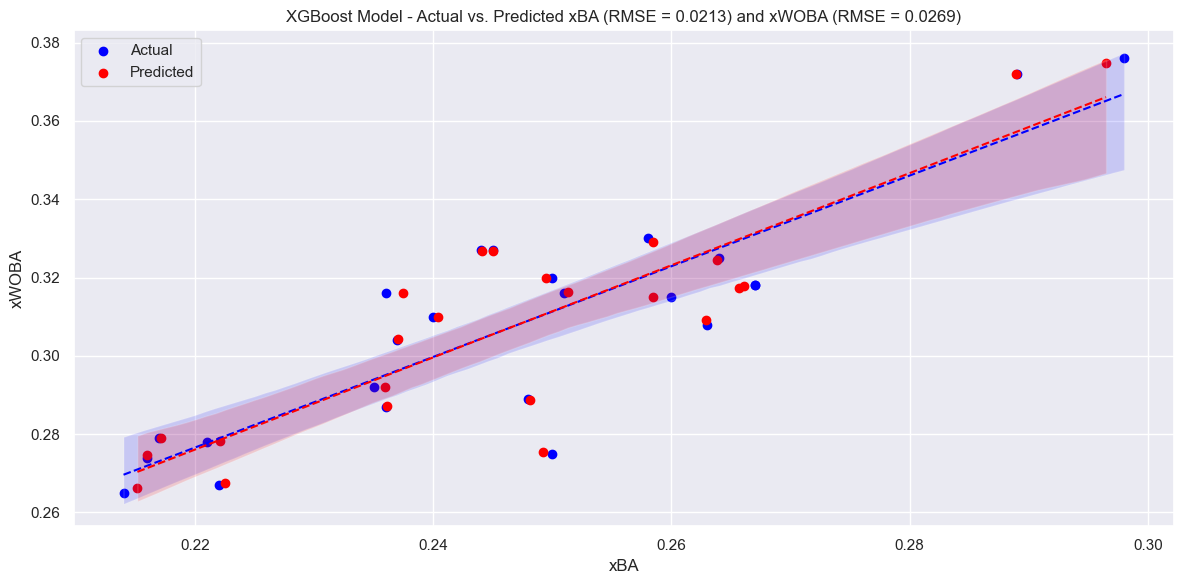

In [359]:
# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarNA['xba'], SimilarNA['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_xBA, predicted_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarNA['xba'], y=SimilarNA['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_xBA, y=predicted_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('XGBoost Model - Actual vs. Predicted xBA (RMSE = 0.0213) and xWOBA (RMSE = 0.0269)')
plt.legend()
plt.grid(True)


# Show the plot
plt.tight_layout()
plt.show()


#### *Random Forest Regressor (Parameter-tuned) (RMSE for xBA = 0.0223, xWOBA = 0.0247)*

In [360]:
# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']
Y_xWOBA = SimilarNA['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth=3)
rf_model_xWOBA = RandomForestRegressor(max_depth=3)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.021173168247818223
Cross-validation RMSE for xWOBA =  0.022430932556346275


Let's see if I can tune these parameters to improve the model's accuracy

In [361]:
## PARAMETER TUNING FOR xBA ##

# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xBA = SimilarNA['xba']
# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor()
# Fit the models
rf_model_xBA.fit(X, Y_xBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [5, 15, 25, 50],
    'max_depth': [1, 3, 5, 7, 10],
    'max_features': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 7, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
Best Cross-validation RMSE with Best Parameters: -0.0003344615999999999


The best parameters for predicting xBA: 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 5

In [362]:
## PARAMETER TUNING FOR xWOBA ##

# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]
# Define target variables
Y_xWOBA = SimilarNA['xwoba']
# Initialize the Random Forest Regressor
rf_model_xWOBA = RandomForestRegressor()
# Fit the models
rf_model_xWOBA.fit(X, Y_xWOBA)
                                     
# Define the parameters to try
param_grid = {
    'n_estimators': [5, 15, 25, 50],
    'max_depth': [1, 3, 5, 7, 10],
    'max_features': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_model_xWOBA, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X, Y_xWOBA)

# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-validation RMSE with Best Parameters:", grid_search.best_score_)

Best Parameters: {'max_depth': 3, 'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 15}
Best Cross-validation RMSE with Best Parameters: -0.00046117343684746597


The best parameters for predicting xWOBA: 'max_depth': 10, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5

Let's apply these new parameters

In [363]:
# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']
Y_xWOBA = SimilarNA['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 10, max_features = 2, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 5)
rf_model_xWOBA = RandomForestRegressor(max_depth = 10, max_features = 3, min_samples_leaf = 1, min_samples_split = 5, n_estimators = 5)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.024349749852603297
Cross-validation RMSE for xWOBA =  0.024763124994522222


After parameter tuning, I got an RMSE of 0.0223 for xBA, and 0.0247 for xWOBA

**NOTE:** Due to the nature of random forest models the printed output may not be the same as the numbers I list

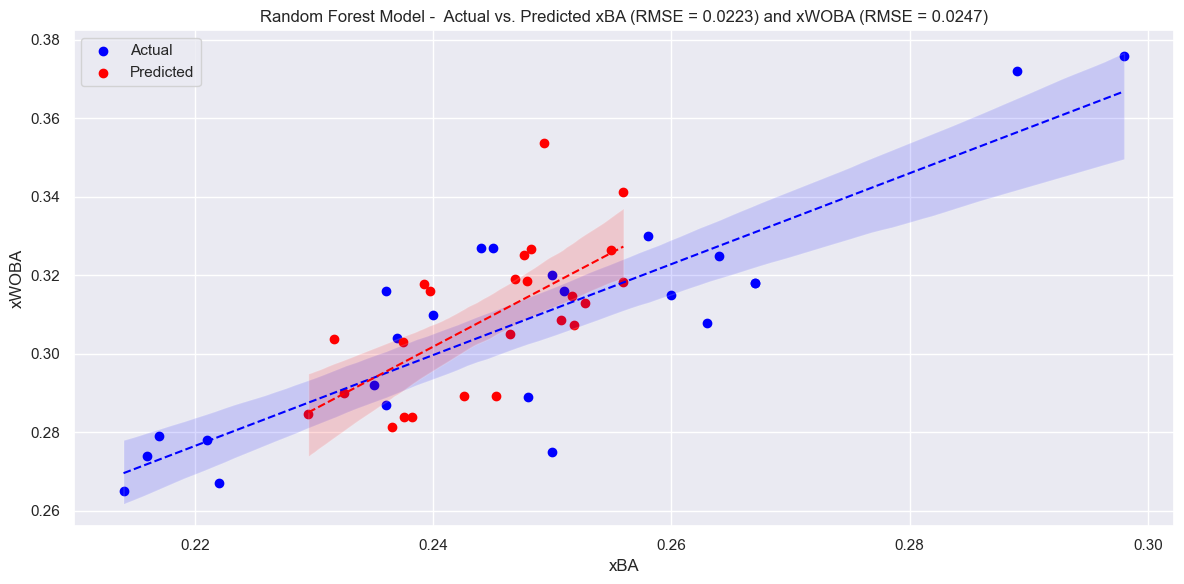

In [364]:
# Predicted values
predicted_rf_xBA = rf_model_xBA.predict(X)
predicted_rf_xWOBA = rf_model_xWOBA.predict(X)

# Build the frame
plt.figure(figsize=(12, 6))
# Data points of actual vs. predicted xBA & xWOBA values
plt.scatter(SimilarNA['xba'], SimilarNA['xwoba'], color='blue', label='Actual')
plt.scatter(predicted_rf_xBA, predicted_rf_xWOBA, color='red', label='Predicted')
# Add a trend line
sns.regplot(x=SimilarNA['xba'], y=SimilarNA['xwoba'], scatter=False, color='blue', line_kws={'linestyle': '--', 'linewidth': 1.5})
sns.regplot(x=predicted_rf_xBA, y=predicted_rf_xWOBA, scatter=False, color='red', line_kws={'linestyle': '--', 'linewidth': 1.5})
# Labels and title
plt.xlabel('xBA')
plt.ylabel('xWOBA')
plt.title('Random Forest Model -  Actual vs. Predicted xBA (RMSE = 0.0223) and xWOBA (RMSE = 0.0247)')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### *Summary of Predictive Models*

![Nolan Arenado Model Table](images/Nolan%20Arenado%20Model%20Table.png)

#### *Final Results for Nolan Arenado*

In [365]:
# Reload Multiple Linear Regression
# Define features
X = SimilarNA[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = SimilarNA['xba']
Y_xWOBA = SimilarNA['xwoba']

# Initialize models
model_xBA = LinearRegression()
model_xWOBA = LinearRegression()

# Fit models
model_xBA.fit(X, Y_xBA)
model_xWOBA.fit(X, Y_xWOBA)

LinearRegression()

In [366]:
# Define the Nolan Arenado's bat speed and the range of intervals
NA_bat_speed = 70.8
end_bat_speed = NA_bat_speed - 3.2
bat_speeds = np.arange(NA_bat_speed, end_bat_speed, -0.5) 

# Set Nolan Arenado's predictors
player_predictors = {
    'barrel_batted_rate': 3.2,
    'hard_hit_percent': 29.9,
    'sweet_spot_percent': 36.0,
    'flyballs_percent': 24.5
}

# Empty lists to store predictions
predicted_xBA_list = []
predicted_xWOBA_list = []

# Iterate over the range of bat speeds (70.8 mph - 67.8 mph)
for bat_speed in bat_speeds:
    # Create a data frame with the player's predictors and the current bat speed
    input_data = pd.DataFrame({
        'barrel_batted_rate': [player_predictors['barrel_batted_rate']],
        'hard_hit_percent': [player_predictors['hard_hit_percent']],
        'avg_swing_speed': [bat_speed],
        'sweet_spot_percent': [player_predictors['sweet_spot_percent']],
        'flyballs_percent': [player_predictors['flyballs_percent']]
    })
    
    # Predicted values
    predicted_xBA = model_xBA.predict(input_data)
    predicted_xWOBA = model_xWOBA.predict(input_data)
    
    # Store prediction
    predicted_xBA_list.append(predicted_xBA[0]) 
    predicted_xWOBA_list.append(predicted_xWOBA[0])

# Convert the lists to arrays for further analysis or plotting
predicted_xBA_array = np.array(predicted_xBA_list)
predicted_xWOBA_array = np.array(predicted_xWOBA_list)

# Output
for i, bat_speed in enumerate(bat_speeds):
    print(f"Bat Speed: {bat_speed:.2f} mph -> Predicted xBA: {predicted_xBA_array[i]:.4f}, Predicted xWOBA: {predicted_xWOBA_array[i]:.4f}")

Bat Speed: 70.80 mph -> Predicted xBA: 0.2277, Predicted xWOBA: 0.2694
Bat Speed: 70.30 mph -> Predicted xBA: 0.2270, Predicted xWOBA: 0.2674
Bat Speed: 69.80 mph -> Predicted xBA: 0.2264, Predicted xWOBA: 0.2653
Bat Speed: 69.30 mph -> Predicted xBA: 0.2257, Predicted xWOBA: 0.2633
Bat Speed: 68.80 mph -> Predicted xBA: 0.2251, Predicted xWOBA: 0.2612
Bat Speed: 68.30 mph -> Predicted xBA: 0.2244, Predicted xWOBA: 0.2592
Bat Speed: 67.80 mph -> Predicted xBA: 0.2238, Predicted xWOBA: 0.2571


Below is a summary of the results:

![Nolan Arenado Pred Result](images/Nolan%20Arenado%20Pred%20Result.png)

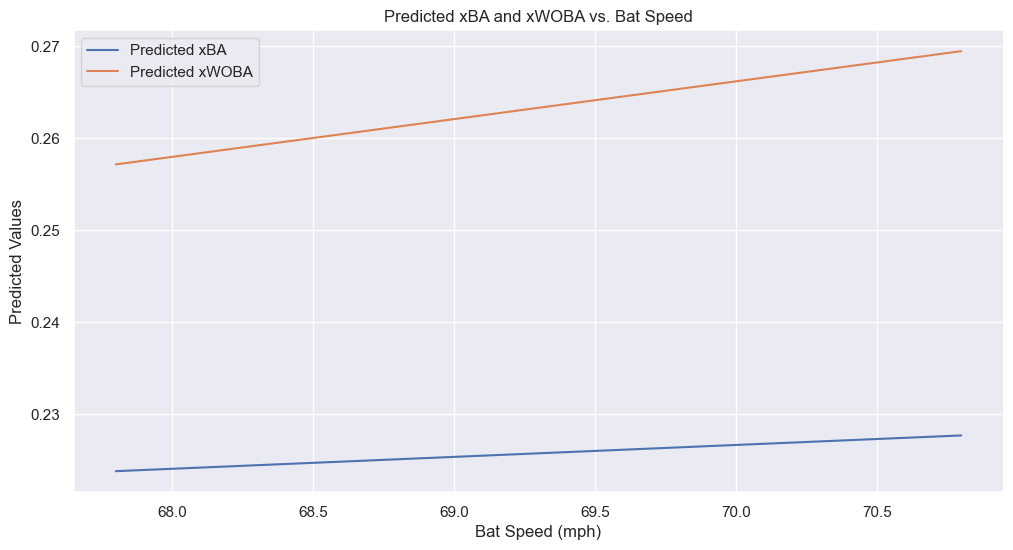

In [367]:
plt.figure(figsize=(12, 6))
plt.plot(bat_speeds, predicted_xBA_array, label='Predicted xBA')
plt.plot(bat_speeds, predicted_xWOBA_array, label='Predicted xWOBA')
plt.xlabel('Bat Speed (mph)')
plt.ylabel('Predicted Values')
plt.title('Predicted xBA and xWOBA vs. Bat Speed')
plt.legend()
plt.grid(True)
plt.show()

### Additional Analysis: Analyzing The Varying Levels Of Regression Of Players

As evidenced by the predictive results, there appear to be varying levels of regression among different players. But what factors play a role in this regression? And what are the different rates at which players regress? To answer these questions I performed some additional analysis.

For this section, I'll just use a basic linear regression model as the basis projection. These models have shown consistent results throughout the entirety of my analysis, so there should be little issue with its accuracy. I'll also re-use my predictors from earlier, keeping my results consistent.

With this in mind, I can proceed with my analysis:

In [373]:
# Define features
X = grouped[['barrel_batted_rate', 'hard_hit_percent', 'avg_swing_speed', 'sweet_spot_percent', 'flyballs_percent']]

# Define target variables
Y_xBA = grouped['xba']
Y_xWOBA = grouped['xwoba']

# Initialize the Random Forest Regressor
rf_model_xBA = RandomForestRegressor(max_depth = 7, max_features = 2, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 50)
rf_model_xWOBA = RandomForestRegressor(max_depth = 5, max_features = 2, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 50)

# Fit the models
rf_model_xBA.fit(X, Y_xBA)
rf_model_xWOBA.fit(X, Y_xWOBA)

# Calculate cross-validation scores for xBA
scores_rf_xBA = cross_val_score(rf_model_xBA, X, Y_xBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xBA = ", np.sqrt(-np.mean(scores_rf_xBA)))

# Calculate cross-validation scores for xWOBA
scores_rf_xWOBA = cross_val_score(rf_model_xWOBA, X, Y_xWOBA, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation RMSE for xWOBA = ", np.sqrt(-np.mean(scores_rf_xWOBA)))

Cross-validation RMSE for xBA =  0.02120177976935241
Cross-validation RMSE for xWOBA =  0.022607159337944157


In [374]:
# Define the range of bat speed intervals (-3.00 mph, decrease by 0.5mph for the intervals)
bat_speed_intervals = np.arange(0, -3.5, -0.5)  


# Initialize the 'results' DataFrame
results = pd.DataFrame()

# Iterate over each player in the 'grouped' dataset
for index, row in grouped.iterrows():
    player_id = row['player_id'] 
    base_bat_speed = row['avg_swing_speed']
    
    # Store predictions hre
    predicted_xBA_list = []
    predicted_xWOBA_list = []
    
    # Iterate over the bat speed intervals
    for interval in bat_speed_intervals:
        # Calculate the current bat speed for the interval
        current_bat_speed = base_bat_speed - interval
        
        # Prepare the input data with the current bat speed and other predictors
        input_data = pd.DataFrame({
            'barrel_batted_rate': [row['barrel_batted_rate']],
            'hard_hit_percent': [row['hard_hit_percent']],
            'avg_swing_speed': [current_bat_speed],
            'sweet_spot_percent': [row['sweet_spot_percent']],
            'flyballs_percent': [row['flyballs_percent']]
        })
        
        # Predict xBA and xWOBA using the existing models
        predicted_xBA = rf_model_xBA.predict(input_data)[0]
        predicted_xWOBA = rf_model_xWOBA.predict(input_data)[0]
        
        # Store the predictions
        predicted_xBA_list.append(predicted_xBA)
        predicted_xWOBA_list.append(predicted_xWOBA)
    
    # Create a row for the current player with all predictions
    player_results = pd.DataFrame({
        'player_id': [player_id],
        'player_name': [row['Name']],  # Assuming 'Name' column contains player names
        **{f"xBA {interval:.2f}mph": [pred] for interval, pred in zip(bat_speed_intervals, predicted_xBA_list)},
        **{f"xWOBA {interval:.2f}mph": [pred] for interval, pred in zip(bat_speed_intervals, predicted_xWOBA_list)}
    })
    
    # Append the player results to the main 'results' DataFrame
    results = pd.concat([results, player_results], ignore_index=True)

results

player_id       player_name  xBA 0.00mph  xBA -0.50mph  xBA -1.00mph  \
0       453568  Charlie Blackmon     0.246381      0.246381      0.245133   
1       457705  Andrew McCutchen     0.242679      0.240692      0.240458   
2       457759     Justin Turner     0.247136      0.247136      0.247276   
3       467793    Carlos Santana     0.231906      0.232337      0.230860   
4       502054        Tommy Pham     0.264287      0.262487      0.261915   
..         ...               ...          ...           ...           ...   
260     694384    Nolan Schanuel     0.253530      0.253530      0.253530   
261     694671    Wyatt Langford     0.255980      0.256266      0.257353   
262     696285       Jacob Young     0.249191      0.247256      0.248221   
263     701538   Jackson Merrill     0.274601      0.269880      0.267684   
264     807799  Masataka Yoshida     0.256744      0.257630      0.254944   

     xBA -1.50mph  xBA -2.00mph  xBA -2.50mph  xBA -3.00mph  xWOBA 0.00mph  \
0        0.246131      0.246587      0.246194      0.246051       0.296687   
1        0.239802      0.239802      0.240262      0.242472       0.317407   
2        0.246616      0.246616      0.246616      0.244383       0.312603   
3        0.232142      0.228858      0.229152      0.230302       0.310264   
4        0.261638      0.261525      0.261525      0.263879       0.327315   
..            ...           ...           ...           ...            ...   
260      0.253231      0.253231      0.252913      0.249737       0.312048   
261      0.257353      0.256224      0.256224      0.256224       0.323705   
262      0.247829      0.248346      0.247013      0.246587       0.281293   
263      0.267627      0.264677      0.262992      0.262672       0.343204   
264      0.256803      0.254944      0.253582      0.252882       0.321406   

     xWOBA -0.50mph  xWOBA -1.00mph  xWOBA -1.50mph  xWOBA -2.00mph  \
0          0.296687        0.296463        0.296039        0.296039   
1          0.314290        0.314078        0.313867        0.313774   
2          0.312253        0.303171        0.302657        0.302262   
3          0.310551        0.311052        0.311052        0.306277   
4          0.327560        0.326851        0.326549        0.327038   
..              ...             ...             ...             ...   
260        0.305177        0.303827        0.303313        0.303313   
261        0.325871        0.329601        0.333899        0.333899   
262        0.280563        0.280254        0.280254        0.279952   
263        0.340448        0.339688        0.339605        0.338873   
264        0.321643        0.321432        0.324192        0.324437   

     xWOBA -2.50mph  xWOBA -3.00mph  
0          0.295830        0.295830  
1          0.315398        0.319571  
2          0.302262        0.301076  
3          0.307480        0.307270  
4          0.328123        0.330218  
..              ...             ...  
260        0.302952        0.301543  
261        0.332929        0.332929  
262        0.279371        0.278748  
263        0.338977        0.339354  
264        0.323398        0.323235  

[265 rows x 16 columns]

For purposes of this analysis, I'll primarily focus on players **30 and above**. These players are more likely to regress in bat speed due to older age.

In [375]:
# Merging the 'woba' column from wOBA into grouped on the 'player_id' column
results = pd.merge(results, grouped[['player_id', 'player_age']], on='player_id', how='left')
# Add in hit_class (it will be needed later)
results = pd.merge(results, grouped[['player_id', 'hit_class']], on='player_id', how='left')


# Filter for players 30 and above
Above30 = results[results['player_age'] >= 30]

Let's now analyze the results and draw some insights

In [376]:
# Calculate total decreases in xBA and xWOBA
Above30['xba_total_diff'] = Above30['xBA 0.00mph'] - Above30['xBA -3.00mph']
Above30['xwoba_total_diff'] = Above30['xWOBA 0.00mph'] - Above30['xWOBA -3.00mph']

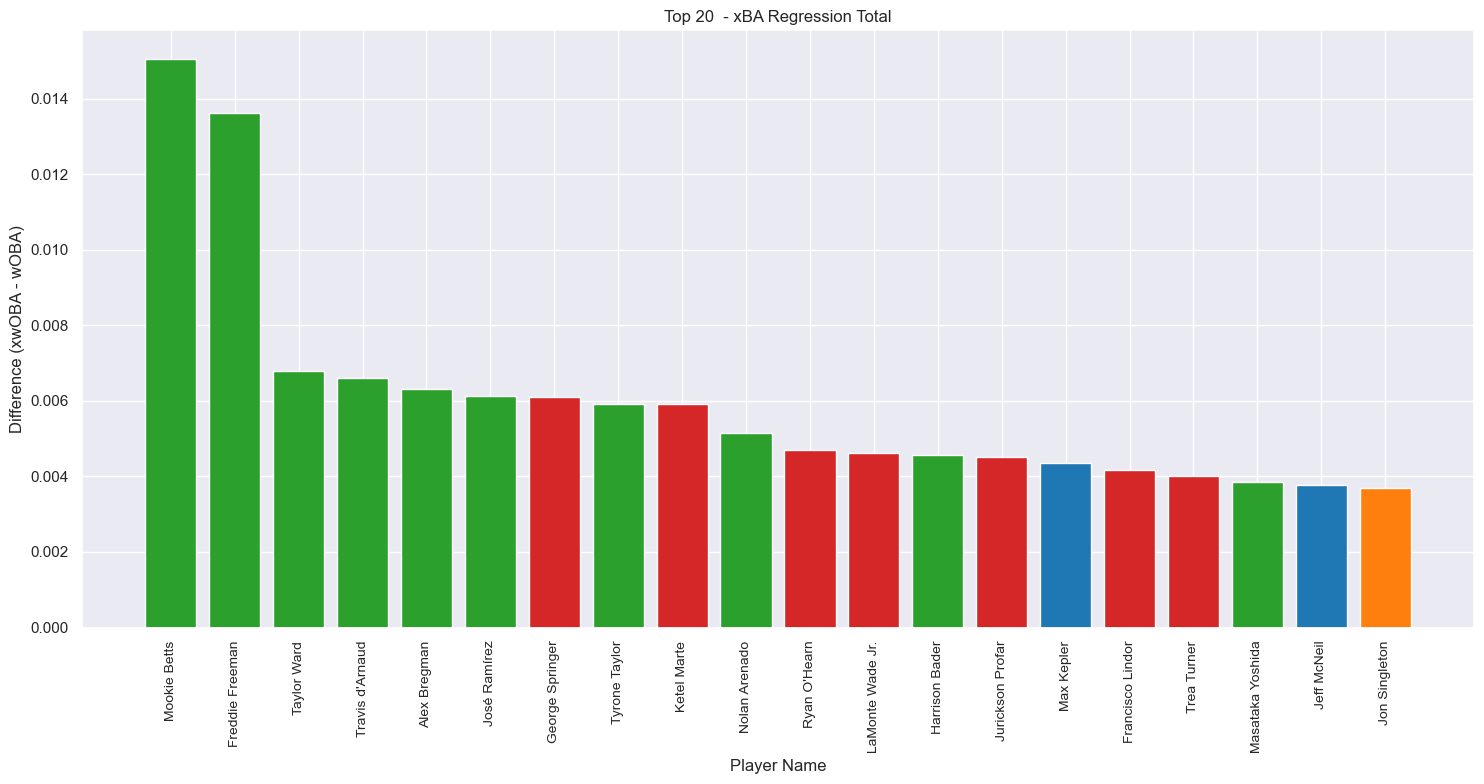

In [388]:
# Sort by 'xba_total_diff'
Above30_sorted1 = Above30.sort_values(by='xba_total_diff', ascending=False)

# Identify top 30 dff
Top20_xbadiff = Above30_sorted1.head(20)

# Define the color map 
color_map = {'.BA Oriented': 'tab:green', 'Elite': 'tab:red', 'Power Oriented': 'tab:orange', 'Struggling': 'tab:blue'}

# Get the colors for the bars
colors = [color_map.get(classification, 'gray') for classification in Top30_xbadiff['hit_class']]

# Plotting the bar chart
plt.figure(figsize=(15,8))
plt.bar(Top20_xbadiff['player_name'], Top20_xbadiff['xba_total_diff'], color=colors)

# Adding labels and title
plt.xlabel('Player Name')
plt.ylabel('Difference (xwOBA - wOBA)')
plt.title('Top 20  - xBA Regression Total')

# Rotate labels on the x-axis
plt.xticks(rotation=90, fontsize=10)



plt.tight_layout()
plt.show()


***See my presentation for a full breakdown and analysis***

# Summary & Conclusion

Please see my presentation for an entire recap of my insights & analysis

Link to presentation: https://www.canva.com/design/DAGOT5eoigA/cOZjWLsLBVtNujAeWy5goA/edit?utm_content=DAGOT5eoigA&utm_campaign=designshare&utm_medium=link2&utm_source=sharebutton